In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Edits (major):

# changed params file to boxsize 120 arcmin, dx = 4 for 2 degree patch, otherwise noise cov and pinv are taking 
# up too much space
# covariance matrix definition changed to the one below

In [3]:
import numpy as np, sys, os, scipy as sc, healpy as H, warnings, pickle, gzip
sys_folder = '../modules/'
sys.path.append(sys_folder)

import flatsky, tools, misc, moving_lens, inpaint, foregrounds as fg

import scipy.ndimage as ndimage
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_defs
cosmology.setCosmology('planck15')
from astropy.cosmology import FlatLambdaCDM

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu_r

In [4]:
#others
perform_inpainting = False #True
use_pol_for_inpainting = False
mask = None
perform_oned_fitting = 1   

In [5]:
# read params file, if we need it

# params or supply a params file
paramfile = 'params_bullter_cluster.ini'

param_dict = misc.fn_get_param_dict(paramfile)

if not perform_oned_fitting:
    param_dict['boxsize'], param_dict['dx'] = 120., 2.

# boxsize, dx = param_dict['boxsize'], param_dict['dx']
boxsize, dx = 60, 1.0

boxsize_am = boxsize
Tcmb = param_dict['T_cmb']
dls_file = param_dict['dls_file']
lmax, nside =  param_dict['lmax'],  param_dict['nside']
mask_file = param_dict['mask_file']

In [6]:
#get ra, dec or map-pixel grid
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [7]:
#read Cls now
if (0):#not use_pol_for_inpainting:
    el, dl = np.loadtxt(dls_file, usecols = [0,1], unpack = 1)
else:
    el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(dls_file, unpack = 1)
    dl_all = np.asarray([dl_tt, dl_ee, dl_bb, dl_te])

dl_fac = el * (el + 1) / 2 / np.pi

# Missing steps in original
cl_all = ( Tcmb**2. * dl_all ) / ( dl_fac )
cl_all = cl_all * 1e12                            # I'm guessing K^2 to uK^2 conversion??

# original
# cl_all = dl_all / dl_fac * 1e12

cl_tt, cl_ee, cl_bb, cl_te = cl_all
print(len(el), cl_tt.shape)

27658 (27658,)


In [8]:
# Set up beam

beamval = 1.2 #arcmins
bl2d = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)

In [9]:
# Set up noise

noiseval = 22.5 #uK-arcmin # 22.5 actual
npix = nx ** 2 
npix_cov = npix ** 2
noofsims_for_cov =  500000 #1500

nl = tools.get_nl(noiseval, el)
noofsims_for_cov

500000

-------

In [10]:
# Set up sims for noise covariance matrix

noise_sims = list()

for i in tqdm(range(noofsims_for_cov)):
    noise_map, g0 = flatsky.make_gaussian_realisation(mapparams, el, nl)
    noise_sims.append(noise_map)
    
noise_sims = np.asarray(noise_sims).flatten().reshape(noofsims_for_cov, npix)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:05<00:00, 1520.58it/s]


In [11]:
# ask -- the calcCov function in this version of tools uses sample covariance not population covariance??
# also using calcCov takes up too much memory space (26GB +) for such a numpy matrix. I used direct matmul instead.

# This takes up too much space for large number of sims.

noise_cov = np.matmul(noise_sims.T , noise_sims) / (noofsims_for_cov)
print(noise_cov.shape)
np.save("output/noise_cov_100k_22.5uK_60_dx1.npy", noise_cov)

(3600, 3600)


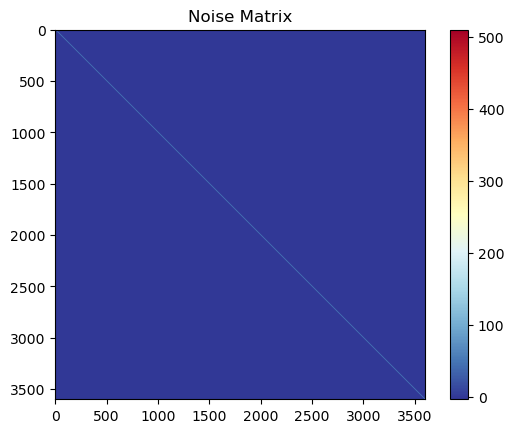

In [10]:
noise_cov = np.load("output/noise_cov_500k_22.5uK_60_dx1.npy", allow_pickle = True)
plt.imshow(noise_cov, cmap = cmap); colorbar(); title("Noise Matrix"); show()
# plt.imshow(noise_cov_inv, cmap = cmap); colorbar(); title("Noise Matrix"); show()

---------------

In [13]:
# Invert noise covariance matrix and save it

noise_cov_inv = np.linalg.pinv(noise_cov)
np.save("output/noise_cov_inv_100k_22.5uK_60_dx1.npy", noise_cov_inv)

In [10]:
# Read in an inverted noise covariance matrix

noise_cov_inv = np.load("output/noise_cov_inv_500k_22.5uK_60_dx1.npy", allow_pickle = True)

------------------

# ML only #

In [11]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [12]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 0.00031894842783610026
check me. 
		time taken for get dot product = 0.00012734731038411458
(1, 120, 120) (1,) (1,)
1
(1, 120, 120) (1,) (1,)


/home/dchanda2002/MovingLensBC/transverse_velocity/scripts/../modules/moving_lens.py:623: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec_tmp = np.asarray( [phi, theta, 0.] )


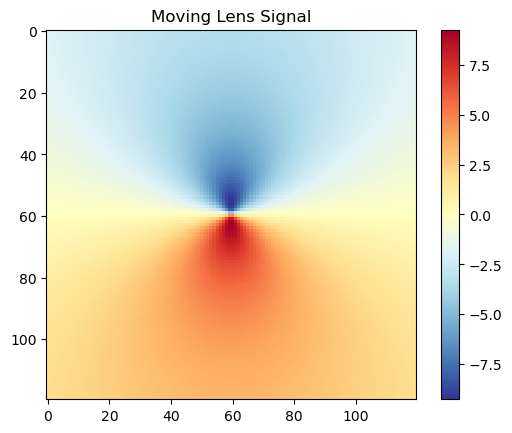

In [14]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Moving Lens Signal"); show()

-----------------

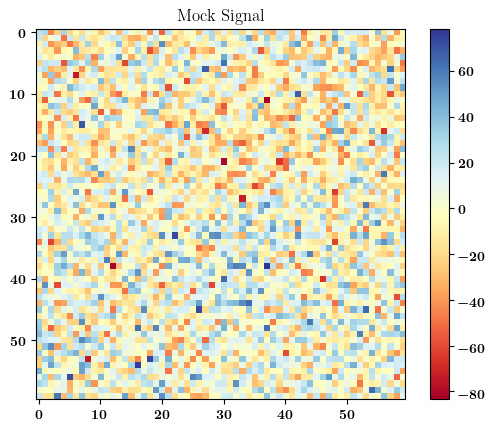

In [75]:
# Make a mock

ml_signal = mvl_arr[0]
noise_signal, a = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = ml_signal + noise_signal
plt.imshow(mock_signal, cmap = cmap); colorbar(); title("Mock Signal"); show()

In [24]:
# Attempt a simple Emcee with amplitude of ML signal(even though there's just one param here :/ but at least it samples the
# distribution)

# To save shallow copy space, use global memory for now

cov = noise_cov
cov_inv = noise_cov_inv # np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(amplitude):
    # cov_inv = np.ones_like(noise_cov)  # for testing

    d = data.flatten() ## - np.mean(MAP.flatten())
    m = abs(amplitude) * ml_signal.flatten() ## - np.mean(MODEL.flatten())
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amplitude):
    if (abs(amplitude) < 5) & (abs(amplitude) > -5):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(amplitude):
    prior = log_prior(amplitude)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(amplitude)


In [108]:
sample_amp = np.arange(-5,5,0.1)
likelihood = [log_likelihood(amp) for amp in tqdm(sample_amp)]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11434.23it/s]


In [109]:
like = likelihood - max(likelihood)
like = np.exp(like)
like/=max(like)
amp_mode=sample_amp[np.argmax(like)]

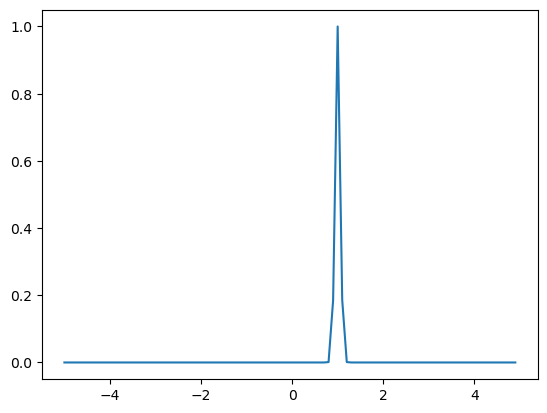

In [110]:
plt.plot(sample_amp, like)

In [25]:
# Then try using emcee

from multiprocessing import Pool

initial = np.random.rand(32, 1) + 0.5  # centered around an amplitude of 1
nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 1000, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

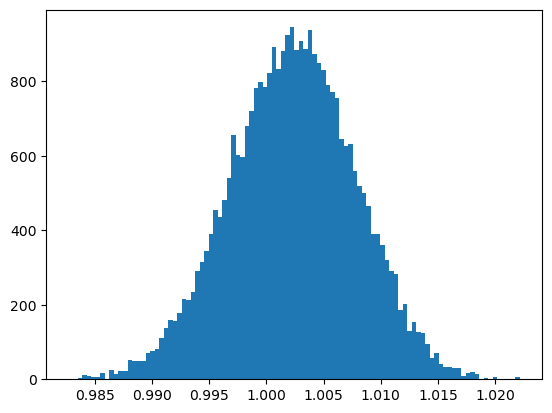

In [26]:
plt.hist(samples, bins = 100)
plt.show()

In [27]:
sixteen = np.percentile(samples, 16.)
eightyfour = np.percentile(samples, 84.)
mean = np.percentile(samples, 50.) # not really mean; change later
lowerr = mean - sixteen
higherr = eightyfour - mean

In [28]:
from IPython.display import display, Math
estimate, low, high = mean, lowerr, higherr
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(estimate, low, high, "Amplitude")
display(Math(txt))

<IPython.core.display.Math object>

In [29]:
print("Stddev:", np.std(samples))

Stddev: 0.005488550777252931


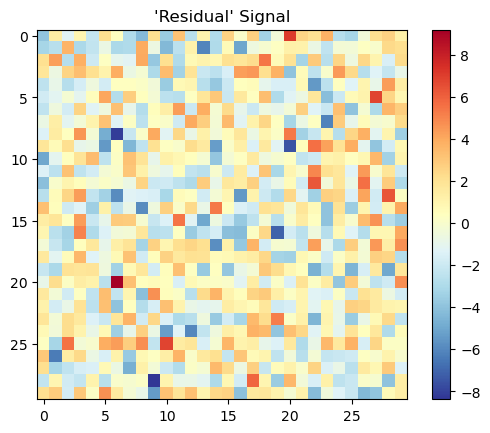

In [75]:
plt.imshow(mock_signal - amp_mode*ml_signal, cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

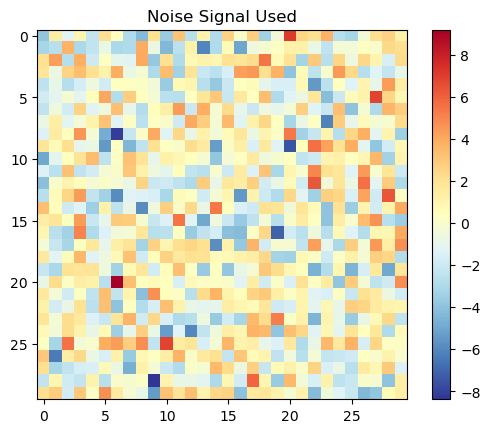

In [76]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

---------------

In [126]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(theta):
    
    velocity, mass = theta
    d = data.flatten() ## - np.mean(MAP.flatten())
    
    v_phi = [v_phi_1]
    phi = [phi_1]
    theta = [theta_1]
    redshift = [redshift_1]
    
    M200c = [mass]
    v_th = [velocity]
    
    noofclus = len(M200c)
    ra_list = dec_list = np.zeros(len(M200c))
    
    mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, 
                                                    dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, 
                                                    param_dict, bl = bl2d)
    m = mvl_arr[0].flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(theta):
    velocity, mass = theta
    if (velocity < 4700) & (velocity > 4300) & (mass < 1.5e16) & (mass > 1.5e14):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(theta):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [127]:
v_init = (np.random.rand(32, 1) - 0.5) *500 + 4500
m_init = (np.random.rand(32, 1) - 0.5) *5e14 + 1.5e15
initial = np.hstack([v_init, m_init])

In [128]:
# Try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = True)
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 300, progress = True)
    samples = sampler.get_chain(flat = True)

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now






0.00.0
0.00.0 0.00.00.00.0    
0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.300.0
 

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30
0.00.0
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=13.783, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=13.179, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.147, z=0.30
 

0.00.0
 		time taken for gettting deflection vector = 9.953975677490234e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.672, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.006, z=0.300.0

		time taken for gettting deflection vector = 9.606679280598958e-05

		time taken for gettting deflection vector = 9.311437606811524e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30i=0: (ra,dec)=(0.000,0.000

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.0
0.00.00.0
 
0.0get moving lens dipole now0.0get moving lens dipole now0.0 0.0 
 0.0
0.00.0
 

0.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.942, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=18.006, z=0.30 

0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.807, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.009, z=0.300.0 0.0
0.0

		time taken for gettting deflection vector = 5.435943603515625e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.080, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.468, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=13.831, z=0.30 



0.0i=0: (ra,dec)=(0.000,0.000), mass=13.831, z=0.30
		time taken for gettting deflection vector = 4.246632258097331e-05
0.0		time taken for gettting deflection vector = 5.497932434082031e-

/home/dchanda2002/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


check me. 		time taken for get dot product = 6.238619486490885e-07
		time taken for get dot product = 7.073084513346354e-07
get moving lens dipole now
check me. check me. 
0.0
		time taken for get dot product = 5.642573038736979e-07 0.0
check me. 

i=0: (ra,dec)=(0.000,0.000), mass=14.358, z=0.30
		time taken for get dot product = 5.563100179036459e-07
check me. 
		time taken for gettting deflection vector = 4.986921946207682e-05		time taken for get dot product = 7.62939453125e-07

check me. 

		time taken for get dot product = 4.967053731282552e-07		time taken for get dot product = 5.165735880533854e-07

check me. check me. 
check me. 
		time taken for get dot product = 9.854634602864584e-07

		time taken for get dot product = 5.086263020833333e-07		time taken for get dot product = 5.006790161132813e-07

check me. 
		time taken for get dot product = 5.125999450683594e-07
check me. 
		time taken for get dot product = 4.847844441731771e-07


  1%|▊                                                                                  | 1/100 [00:01<01:58,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.00.0

 
 
0.00.00.00.0    0.00.00.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=10.625, z=0.300.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.334, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.003, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.791, z=0.30
 0.0

 
		time taken for gettting deflection vector = 4.652738571166992e-05i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.828, z=0.30



0.0
		time taken for gettting deflection vector = 6.251732508341471e-050.0

		time taken for gettting deflection vector = 5.5448214213053385e-05
 


i=0: (ra,dec)=(0.000,0.000), mass=16.734, z=0.30		time taken for gettting deflection vector = 4.62

  2%|█▋                                                                                 | 2/100 [00:02<01:49,  1.11s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.00.00.0   0.0get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=12.041, z=0.300.0


get moving lens dipole now
get moving lens dipole now		time taken for gettting deflection vector = 4.925727844238281e-05i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.300.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=16.329, z=0.30 

 
 
0.0

0.0
		time taken for gettting deflection vector = 4.9396355946858725e-050.0  0.0
0.0
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=16.705, z=0.300.0		time taken for gettting deflection vector = 5.2030881245930986e-050.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30		time taken for gettting deflection vector = 4.9392382303873696e-05


 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.229, z=0.30i=0: (ra,dec)=(0.000,0.000)

  3%|██▍                                                                                | 3/100 [00:03<01:45,  1.09s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0


0.0
0.0 0.0  

0.0 0.0
 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.730, z=0.30 
0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.668, z=0.300.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30		time taken for gettting deflection vector = 4.734595616658529e-05i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30
 


		time taken for gettting deflection vector = 5.260705947875977e-05  0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.074, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.030, z=0.30
0.0

		time taken for gettting deflection vector = 5.1093101501464846e-05		time taken for gettting deflection vector = 4.696051279703776e-05
0.0		time taken for g

  4%|███▎                                                                               | 4/100 [00:04<01:54,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
get moving lens dipole now 0.00.0get moving lens dipole now0.0




  0.00.00.0
0.0
 
 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.860, z=0.300.0 0.0


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.334, z=0.30 

 get moving lens dipole now		time taken for gettting deflection vector = 7.013479868570964e-050.0
		time taken for gettting deflection vector = 6.63002332051595e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.30

0.00.0  

0.0

i=0: (ra,dec)=(0.000,0.000), mass=16.184, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.0		time taken for gettting deflection vector = 7.217725118001302e-05		time taken for gettting deflection vector = 7.75

  5%|████▏                                                                              | 5/100 [00:05<01:53,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.00.0
 
0.00.0get moving lens dipole nowget moving lens dipole now0.0

 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.046, z=0.30
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.551, z=0.30
get moving lens dipole now0.00.0
 0.00.0

0.0
0.00.00.0
 		time taken for gettting deflection vector = 4.639228185017904e-05
0.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30		time taken for gettting deflection vector = 5.088647206624349e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.772, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=13.177, z=0.300.0
0.0

0.0
		time taken for gettting deflection vector = 4.426240921020508e-05		time taken for gettting deflection vector = 4.958709081013997e-05 i=0: (ra,dec)=(0.000,0.000), mass=14.529, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15

  6%|████▉                                                                              | 6/100 [00:07<01:58,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now



0.0get moving lens dipole now


0.00.00.00.00.00.00.0     0.00.0 0.00.0

0.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=13.439, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.053, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.244, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.609, z=0.300.0

 
i=0: (ra,dec)=(0.000,0.000), mass=14.016, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.499, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.30

		time taken for gettting deflection vector = 4.602670669555664e-05		time taken for gettting deflection vector = 4.6253204345703125e-050.0

		time taken for gettting deflection vector = 4.4123331705729166e-050.0
		time taken for gettting deflection vector = 5.3

  7%|█████▊                                                                             | 7/100 [00:08<02:00,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.740, z=0.300.0
get moving lens dipole now0.0 0.0


 
 get moving lens dipole now0.0
0.00.00.0 0.0 0.0
0.0
0.0
 
		time taken for gettting deflection vector = 6.07609748840332e-05
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.566, z=0.300.0
 0.0
 		time taken for gettting deflection vector = 4.358291625976563e-05get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=11.248, z=0.30


0.0



0.0		time taken for gettting deflection vector = 5.0469239552815756e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.911, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.814, z=0.30

  8%|██████▋                                                                            | 8/100 [00:10<02:02,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now



0.00.0 0.0
get moving lens dipole now0.00.0
 
get moving lens dipole now 0.0 0.0
get moving lens dipole now 0.0 0.00.0
0.0
0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.641, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30



 

		time taken for gettting deflection vector = 4.450082778930664e-050.00.0
		time taken for gettting deflection vector = 5.586544672648112e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.589, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.968, z=0.300.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30  


i=0: (ra,dec)=(0.000,0.000), mass=14.037, z=0.30
0.0		time taken for gettting deflection vector = 5.414485931396484e-05		time taken for gettting deflection vector = 4.920164744059245e-05
i=0: (ra,dec)=(0.000,0.000

  9%|███████▍                                                                           | 9/100 [00:11<02:06,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0

0.0  0.0 
get moving lens dipole now0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30
 0.0
0.0 


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30 0.0

0.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.581, z=0.30		time taken for gettting deflection vector = 4.836718241373698e-05i=0: (ra,dec)=(0.000,0.000), mass=14.226, z=0.30 get moving lens dipole now0.0
0.0		time taken for gettting deflection vector = 5.2030881245930986e-050.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=16.217, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.522, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.725, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.30
i=0: (ra,dec)=(0.00

 10%|████████▏                                                                         | 10/100 [00:12<02:04,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now0.0
 

0.0

0.0
0.0
  
0.0
0.00.00.00.00.0 0.0 
0.0 0.0 
 0.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.364, z=0.30  
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=16.270, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.416, z=0.30


 
0.0		time taken for gettting deflection vector = 5.01553217569987e-05i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.466, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.616, z=0.30

		time taken for gettting deflection vector = 5.9767564137776694e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.103, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.30


0.0i=0: (r

 11%|█████████                                                                         | 11/100 [00:14<02:03,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now

0.0
0.00.0

0.00.0 

get moving lens dipole now 0.00.00.00.0   0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.300.0 0.0
 
0.0 0.0

 



 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.895, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30




		time taken for gettting deflection vector = 4.761616388956706e-05i=0: (ra,dec)=(0.000,0.000), mass=14.793, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.369, z=0.30		time taken for gettting deflection vector = 5.934635798136393e-05		time taken for gettting deflection vector = 4.5466423034667966e-05



 12%|█████████▊                                                                        | 12/100 [00:15<02:03,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0

0.00.0
  0.0get moving lens dipole now0.00.00.0
 0.0

  0.00.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30 
		time taken for gettting deflection vector = 5.405743916829427e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.321, z=0.30		time taken for gettting deflection vector = 6.049076716105143e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.576, z=0.30		time taken for gettting deflection vector = 6.803671518961589e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=13.264, z=0.30		time take

 13%|██████████▋                                                                       | 13/100 [00:17<02:05,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole now0.0 0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.836, z=0.300.00.0get moving lens dipole now
 

		time taken for gettting deflection vector = 0.00011962652206420898
i=0: (ra,dec)=(0.000,0.000), mass=14.168, z=0.300.0
get moving lens dipole now0.0

0.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30
0.0


0.0 
0.0  		time taken for gettting deflection vector = 5.497535069783529e-05		time taken for gettting deflection vector = 9.349584579467773e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.986, z=0.30 0.0get moving lens dipole nowget moving lens dipole now0.0

0.0
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30		time taken for gettting deflection vector = 4.7540664672851564e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.30
0.00.0


		time taken for gettting deflec

 14%|███████████▍                                                                      | 14/100 [00:18<02:10,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0
0.0 get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 
0.0
 
0.00.0
0.00.00.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30  
  i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.300.00.00.0

 0.00.00.0
0.0
 
0.0 		time taken for gettting deflection vector = 4.818042119344076e-05		time taken for gettting deflection vector = 4.780292510986328e-050.0 



i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.686, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.593, z=0.30i=0: (ra,dec

 15%|████████████▎                                                                     | 15/100 [00:20<02:09,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 


0.00.00.0get moving lens dipole nowget moving lens dipole now


 0.0 0.00.0

get moving lens dipole now0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30

 0.0get moving lens dipole now 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=16.129, z=0.30
0.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
0.00.0 
0.0

		time taken for gettting deflection vector = 4.951953887939453e-05i=0: (ra,dec)=(0.000,0.000), mass=14.432, z=0.30
0.0

 
		time taken for gettting deflection vector = 0.00010259548823038737		time taken for gettting deflection vector = 5.941390991210937e-05i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.30 

 16%|█████████████                                                                     | 16/100 [00:22<02:09,  1.54s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0

get moving lens dipole now
0.0
0.0 
0.0
 
0.0 
0.0

 
0.00.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.300.00.00.0 0.0
		time taken for gettting deflection vector = 4.8442681630452475e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.300.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.736, z=0.300.0
0.00.0

 
		time taken for gettting deflection vector = 4.8669179280598957e-05i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30
		time taken for gettting deflection vector = 6.624857584635417e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.453, 

 17%|█████████████▉                                                                    | 17/100 [00:23<02:05,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



get moving lens dipole nowget moving lens dipole now

0.0
 0.00.00.0
 
0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30 get moving lens dipole now
0.00.0 0.00.0
 0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.483, z=0.30 0.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.300.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.138, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.30
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.30 

0.00.0		time taken for gettting deflection vector = 5.941390991210937e-05i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.30
 
 		time taken for gettting deflection vector = 6.14166259765625e-05i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30
		time taken for gettting deflection vector = 4.9837430318196614e-

 18%|██████████████▊                                                                   | 18/100 [00:24<02:02,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 

0.0 get moving lens dipole now0.00.0


get moving lens dipole now0.0get moving lens dipole now0.0

0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.30
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.639, z=0.30
 get moving lens dipole now0.0		time taken for gettting deflection vector = 4.6753883361816405e-05		time taken for gettting deflection vector = 4.953145980834961e-050.0

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.300.0


 i=0: (ra,dec)=(0.000,0.000), mass=14.540, z=0.30

		time taken for gettting deflection vector = 6.239016850789388e-05 
		time taken for gettting deflection vector = 4.671017328898112e-05
0.00.0
 
0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=1

 19%|███████████████▌                                                                  | 19/100 [00:26<01:54,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0 

0.0
0.0 0.0


0.00.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.300.0

0.0 0.0 0.0 		time taken for gettting deflection vector = 5.150238672892253e-050.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30  
0.00.0
 0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.482, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.003, z=0.30
 		time taken for gettting deflection vector = 8.654594421386719e-05

		time taken for gettting deflection vector = 4.79578971862793e-05		time taken for gettting deflection vector = 5.85

 20%|████████████████▍                                                                 | 20/100 [00:27<01:52,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now
0.0 0.00.0
0.0
 
 0.00.00.00.00.0
0.0    

0.00.0 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.758, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.479, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.30
   i=0: (ra,dec)=(0.000,0.000), mass=14.440, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30
0.00.00.0 



0.0


		time taken for gettting deflection vector = 5.270242691040039e-050.0
		time taken for gettting deflection vector = 4.570484161376953e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.551, z=0.30		time taken for gettting deflection vector = 4.6181678771972654e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.068, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.

 21%|█████████████████▏                                                                | 21/100 [00:28<01:48,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0  get moving lens dipole now0.0 
0.00.0
0.0get moving lens dipole now


 i=0: (ra,dec)=(0.000,0.000), mass=15.312, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.772, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.785, z=0.30get moving lens dipole now
0.00.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=14.854, z=0.30

		time taken for gettting deflection vector = 5.195140838623047e-05		time taken for gettting deflection vector = 4.610220591227214e-05 
0.0
  
 
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.623, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.799, z=0.300.0		time taken for gettting deflection vector = 5.6914488474527995e-05
0.0
 		time taken for gettting deflection vector = 5.081892013549805e-05


0.00.0
 		time taken for gettting d

 22%|██████████████████                                                                | 22/100 [00:30<01:41,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.00.0
get moving lens dipole nowget moving lens dipole now0.0 
 0.0
0.0

0.0 
0.0
0.00.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.300.0
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30 0.0
0.00.00.00.0
0.0 
   0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.778, z=0.30		time taken for gettting deflection vector = 7.017453511555989e-050.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.284, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.208, z=0.30
		time taken for gettting deflection vector = 4.236300786336263e-05i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30




		time taken for gettting deflection vector = 5.05407651

 23%|██████████████████▊                                                               | 23/100 [00:31<01:38,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 



0.0 0.0get moving lens dipole now0.0

0.0  0.00.00.0get moving lens dipole now0.00.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.110, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.30
		time taken for gettting deflection vector = 5.1863988240559895e-05 		time taken for gettting deflection vector = 4.84466552734375e-05
get moving lens dipole now0.00.0  
 
0.0 		time taken for gettting deflection vector = 5.222956339518229e-05
0.0
0.0		time taken for gettting deflection vector = 6.073315938313802e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.30 0.00.0
0.0


0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30i=0: (ra,dec)=(0.000,0.00

 24%|███████████████████▋                                                              | 24/100 [00:32<01:38,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0
 


0.0
0.00.0  0.0  
0.00.00.0  0.00.00.00.00.00.0 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.345, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.354, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.099, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=14.556, z=0.30
		time taken for gettting deflection vector = 5.044142405192057e-05
 i=0: (ra,dec)=(0.000,0.000), mass=14.343, z=0.30



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30		time taken for gettting deflection vector = 4.5462449391682944e-050.0 


		time taken for gettting deflection vector = 4.792213439941406e-05 		time taken for gettting deflection vector = 5

 25%|████████████████████▌                                                             | 25/100 [00:33<01:33,  1.25s/it]

get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
 0.0 


0.00.00.00.0 0.0
 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.300.0


0.0 0.0  0.00.0get moving lens dipole now
		time taken for gettting deflection vector = 5.4764747619628904e-050.0
 		time taken for gettting deflection vector = 5.420843760172526e-050.0

0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.318, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30get moving lens dipole now0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.572, z=0.30 
0.0
		time taken for gettting deflection vector = 4.589160283406575e-05i=0: (ra,dec)=(0.000,0.000), mass=15.229, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30		time taken for gettting deflection vector = 4.8

 26%|█████████████████████▎                                                            | 26/100 [00:35<01:35,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now







0.0 
0.00.00.0
0.00.00.0   0.00.00.0   0.00.00.00.0 0.00.00.0 

0.0 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.300.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.507, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.323, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.970, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30		time taken for gettting deflection vector = 5.077521006266276e-05		time taken for gettting deflection vector = 4.7083695729573565e-05

		time taken

 27%|██████████████████████▏                                                           | 27/100 [00:36<01:32,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

 
0.0
0.0 


0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.300.0 0.0
get moving lens dipole now0.0
0.0 0.0  		time taken for gettting deflection vector = 5.373160044352214e-050.0
 0.00.0
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.574, z=0.30 get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.300.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30		time taken for gettting deflection vector = 4.789829254150391e-05

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30		time taken for gettting deflection vector = 5.348523457845052e-05
		time taken for gettting deflection vector = 5.02268473

 28%|██████████████████████▉                                                           | 28/100 [00:37<01:29,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole nowget moving lens dipole now
 0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.742, z=0.300.0

0.0
0.00.0 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
 
		time taken for gettting deflection vector = 5.738735198974609e-05
0.0 0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.300.0





0.0		time taken for gettting deflection vector = 5.8317184448242186e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30 
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.683, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.779, z=0.300.0
0.0		time taken for gettting deflection vector = 4.86453374226888e-05

0.00.0 
0.0


		time taken for gettting deflection vector = 5.

 29%|███████████████████████▊                                                          | 29/100 [00:38<01:25,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
 
get moving lens dipole nowget moving lens dipole now


0.0 0.00.0get moving lens dipole now0.00.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.332, z=0.30
  0.00.0		time taken for gettting deflection vector = 4.970630009969075e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.902, z=0.30get moving lens dipole now  


i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.00.0



0.0
0.0		time taken for gettting deflection vector = 4.7890345255533856e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.0 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.448, z=0.30

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.642, z=0.30		time taken for gettting deflection vector = 5.956888198852539e-050.0
 

 0.00.00.0		time taken for gettting deflection vector = 4.8951307932535806e-05
		time taken for gettting

 30%|████████████████████████▌                                                         | 30/100 [00:39<01:25,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


get moving lens dipole now0.00.00.0 0.0 
0.0
 
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.300.00.0  

0.0 

 i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.262, z=0.300.00.00.0		time taken for gettting deflection vector = 4.9066543579101565e-05get moving lens dipole now

 

 		time taken for gettting deflection vector = 4.760424296061198e-05
0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.300.0
		time taken for gettting deflection vector = 5.4391225179036457e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=14.970, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.30
0.0

		time taken for gettting deflection vector = 4.85

 31%|█████████████████████████▍                                                        | 31/100 [00:41<01:26,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0
0.0
0.0get moving lens dipole nowget moving lens dipole now 
0.00.0 
 
 get moving lens dipole now
0.00.00.00.0

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.300.00.0 0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.30  0.00.00.0

		time taken for gettting deflection vector = 3.820657730102539e-05
		time taken for gettting deflection vector = 6.142457326253255e-05i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.477, z=0.30

 		time taken for gettting deflection vector = 5.003213882446289e-05

0.0



		time taken for gettting deflection vector = 5.980730056762695e-05


		time taken for gettting deflection vector = 4.69

 32%|██████████████████████████▏                                                       | 32/100 [00:42<01:25,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.0
0.00.00.0 0.00.0    
 0.00.0 0.00.0
0.0

0.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.0get moving lens dipole now
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.404, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.160, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0
		time taken for gettting deflection vector = 5.168914794921875e-05i=0: (ra,dec)=(0.000,0.000), mass=15.499, z=0.300.0

		time taken for gettting deflection vector = 5.358457565307617e-05

 		time tak

 33%|███████████████████████████                                                       | 33/100 [00:43<01:27,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0
0.00.0

get moving lens dipole now  0.0 0.0 0.00.00.00.00.0 0.0

 
 0.0
get moving lens dipole now
get moving lens dipole now0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.165, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.937, z=0.30


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.156, z=0.30


		time taken for gettting deflection vector = 5.7534376780192056e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.30
 
		time taken for gettting deflection vector = 4.78665033976237e-05i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.300.00.0		time taken for gettting deflection vector = 5.267461140950521e-05
		time taken for gettting deflection vector = 4.9054622650146484e-05 



i=0: (ra

 34%|███████████████████████████▉                                                      | 34/100 [00:45<01:23,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.00.0 0.0
get moving lens dipole now0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.672, z=0.30get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
 






0.0 0.00.00.0		time taken for gettting deflection vector = 4.925330479939779e-050.0

 0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30  0.0 
 0.0 0.00.0 0.00.00.00.0

 


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.554, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.545, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.990, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.360, z=0.30

		time taken for gettting deflec

 35%|████████████████████████████▋                                                     | 35/100 [00:46<01:23,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0




 get moving lens dipole nowget moving lens dipole now0.00.00.00.0  
0.00.0
0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.947, z=0.30  0.0
0.00.0
 0.0 0.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30		time taken for gettting deflection vector = 4.986921946207682e-05




i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.878, z=0.30
 0.00.00.0		time taken for gettting deflection vector = 5.565484364827474e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30

get moving lens dipole now



i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.0

		time taken for gettting deflection vector = 4.915793736775716e-05

 36%|█████████████████████████████▌                                                    | 36/100 [00:48<01:29,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0

0.0
0.00.00.0
0.0   0.00.0 
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.460, z=0.30get moving lens dipole nowget moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30

0.0



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.300.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.30
 0.0  
		time taken for gettting deflection vector = 6.147225697835286e-050.00.0		time taken for gettting deflection vector = 4.640817642211914e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.069, z=0.30		time taken for gettting deflection vector = 4.942814509073893e-05

0.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.547, z=0.30		time taken for gettting deflection vector = 5

 37%|██████████████████████████████▎                                                   | 37/100 [00:49<01:29,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0
0.0 0.0 0.0

0.0
0.0 0.00.00.00.00.0 0.0
0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.300.0
0.0  

0.0


 
i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.962, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.497, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.583, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.060, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.899, z=0.300.00.0

0.00.0		time taken for gettting deflection vector = 4.7596295674641925e-05

 

		time taken for gettting deflection vector = 4.881620407104492e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30


0.0		time taken for gettting deflection vector = 5.399386088

 38%|███████████████████████████████▏                                                  | 38/100 [00:50<01:28,  1.43s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now

 
get moving lens dipole now0.0
0.00.00.0 

0.00.0 

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.300.0
   

  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.746, z=0.300.0 
0.0
		time taken for gettting deflection vector = 5.457003911336263e-050.0

0.0		time taken for gettting deflection vector = 5.1808357238769534e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30
		time taken for gettting deflection vector = 5.2932898203531904e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.618, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.460, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30		time taken for gettting deflection vector = 7.124741872151692e-05i=0: (ra,dec)=

 39%|███████████████████████████████▉                                                  | 39/100 [00:52<01:28,  1.46s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now

0.0

get moving lens dipole now0.0
 0.0get moving lens dipole now0.00.0
  0.00.00.0 0.0
  0.0 
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30 0.00.0

0.0 0.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.476, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.718, z=0.30



		time taken for gettting deflection vector = 5.268653233846028e-05i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30		time taken for gettting deflection vector = 5.363225936889648e-05		time taken for gettting deflection vector = 5.1597754160563

 40%|████████████████████████████████▊                                                 | 40/100 [00:54<01:29,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now

 0.00.0
  0.0get moving lens dipole now0.0 

0.0
get moving lens dipole now
0.00.00.0
0.00.00.0
 
get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.566, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.582, z=0.300.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.400, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
		time taken for gettting deflection vector = 4.948774973551432e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30		time taken for gettting deflection vector = 5.350907643636068e-05  
0.0		time taken for gettting deflection vector = 5.4383277893066405e-05
0.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30 
0.00.0		time taken for gettting deflection vector = 6.364186604817708e-05		time taken for gettti

 41%|█████████████████████████████████▌                                                | 41/100 [00:55<01:25,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
  0.0 0.0get moving lens dipole nowget moving lens dipole now

0.0 0.00.0

 0.0
0.0get moving lens dipole now
0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.300.00.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.602, z=0.300.0

 		time taken for gettting deflection vector = 5.0067901611328125e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.300.0 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.329, z=0.30 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.30 		time taken for gettting deflection vector = 5.3318341573079425e-05		time taken for gettting deflection vector = 5.928675333658854e-05




		time taken for gettting deflection vector = 8.557637532552083e-05i=0: (ra,dec)=(0.000,0.00

 42%|██████████████████████████████████▍                                               | 42/100 [00:56<01:24,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0
0.0get moving lens dipole now0.0  
0.0get moving lens dipole now
 0.00.0
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30 

		time taken for gettting deflection vector = 5.7526429494222005e-050.0		time taken for gettting deflection vector = 5.942583084106445e-050.00.00.0		time taken for gettting deflection vector = 4.9956639607747395e-05
 
0.00.0

 0.00.00.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
 0.0		time taken for gettting deflection vector = 4.781484603881836e-05  i=0: (ra,dec)=(0.000,0.000), mass=15.481, z=0.30


0.0
i=0: (ra,dec)=(0.000,0.

 43%|███████████████████████████████████▎                                              | 43/100 [00:58<01:22,  1.46s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.00.00.00.0


0.0  0.0 0.0 
0.0  0.00.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.603, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.207, z=0.30
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.300.0

get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.824, z=0.30		time taken for gettting deflection vector = 5.43673833211263e-05
		time taken for gettting deflection vector = 5.353291829427083e-05		time taken for gettting deflection vector = 4.954735438028971e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30


		time taken for gettting deflection vector = 4.90109125773112e-05i=0: (ra,dec)=(0.000,0.000), mass=14.188, z=0.30i=0: (

 44%|████████████████████████████████████                                              | 44/100 [00:59<01:18,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.00.0 0.0
 get moving lens dipole now
0.0

get moving lens dipole now0.00.0  0.0
0.0
0.0 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.709, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.340, z=0.30 
 
		time taken for gettting deflection vector = 4.938046137491862e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0

0.0		time taken for gettting deflection vector = 4.7194957733154294e-05		time taken for gettting deflection vector = 4.85380490620931e-05		time taken for gettting deflection vector = 5.462169647216797e-050.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.323, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=

 45%|████████████████████████████████████▉                                             | 45/100 [01:01<01:17,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0

 0.0
0.00.0  
  0.00.00.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.896, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.420, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30
0.0





 i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30
0.0		time taken for gettting deflection vector = 6.226301193237304e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.620, z=0.30 

		time taken for gettting deflection vector = 4.869699478149414e-05		time taken for gettting deflection vector = 5.375146865844726e-05		time taken for gettting deflection vector = 4.863739013671875e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30

 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.532

 46%|█████████████████████████████████████▋                                            | 46/100 [01:02<01:16,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.0
0.00.00.0  

0.0
get moving lens dipole now0.00.00.0

 
0.00.00.0 0.0    i=0: (ra,dec)=(0.000,0.000), mass=15.731, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.30
0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 


 i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.471, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
		time taken for gettting deflection vector = 5.020300547281901e-05		time taken for gettting deflection vector = 5.024274190266927e-05
		time taken for gettting deflection vector = 5.0691763559977215e-05
0.0


0.00.0
		time taken for gettting deflection vector = 5.

 47%|██████████████████████████████████████▌                                           | 47/100 [01:03<01:16,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now 0.0
0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.550, z=0.30 0.0get moving lens dipole now
0.0

0.00.0


 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.672, z=0.300.0
 get moving lens dipole now 


 0.0  		time taken for gettting deflection vector = 4.874070485432943e-050.00.00.00.0

0.0 0.0

		time taken for gettting deflection vector = 6.215572357177734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.30		time taken for gettting deflection vector = 5.056460698445638e-05		time taken for gettting deflection vector = 5.896886189778646e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.471, z

 48%|███████████████████████████████████████▎                                          | 48/100 [01:05<01:17,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now

0.0 0.00.00.0get moving lens dipole now0.0
 
0.0get moving lens dipole now0.0

 0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.502, z=0.300.00.0
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.656, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.142, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.30
0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.374, z=0.30
0.0		time taken for gettting deflection vector = 4.8605600992838543e-05

		time taken for gettting deflection vector = 5.2074591318766274e-05		time taken for gettting deflection vector = 5.974769592285156e-05

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30
0.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.473, z=0.30 0.

 49%|████████████████████████████████████████▏                                         | 49/100 [01:06<01:14,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.00.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30
get moving lens dipole now0.0
  0.0		time taken for gettting deflection vector = 6.448030471801758e-050.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30

0.00.0
 		time taken for gettting deflection vector = 5.083084106445312e-05i=0: (ra,dec)=(0.000,0.000), mass=15.778, z=0.300.0
0.0 

 i=0: (ra,dec)=(0.000,0.000), mass=14.901, z=0.300.0		time taken for gettting deflection vector = 4.376570383707682e-05

 0.0
 
get moving lens dipole now
0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.30 

		time taken for gettting deflection vector = 5.251963933308919e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.00

 50%|█████████████████████████████████████████                                         | 50/100 [01:08<01:15,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.0

get moving lens dipole now0.00.00.0get moving lens dipole now 

 0.00.0
0.0
0.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.324, z=0.300.00.0  0.0
  
0.00.00.0
0.0
 0.0		time taken for gettting deflection vector = 5.1069259643554685e-05
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.310, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.30		time taken for gettting deflection vector = 4.9126148223876956e-05i=0: (ra,dec)=(0.000,0.000), mass=15.652, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.450, z=0.300.0





		time taken for gettting deflection vector = 5.160172780

 51%|█████████████████████████████████████████▊                                        | 51/100 [01:09<01:11,  1.47s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now



0.0
0.00.00.0
 0.0  0.0  0.00.0 0.0
0.0get moving lens dipole now
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.916, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.954, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.783, z=0.30



		time taken for gettting deflection vector = 5.014340082804362e-050.0
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.979, z=0.30		time taken for gettting deflection vector = 6.057421366373698e-05 
		time taken for gettting deflection vector = 5.5559476216634114e-05

0.0
0.00.00.0 		time taken for gettting deflection vector = 5.704164505004883e-050.0



 		time taken for gettting de

 52%|██████████████████████████████████████████▋                                       | 52/100 [01:11<01:07,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

 

get moving lens dipole now
get moving lens dipole now0.00.00.0get moving lens dipole now0.00.0  0.0
   0.00.00.0

get moving lens dipole now0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.031, z=0.30
0.0 
 
i=0: (ra,dec)=(0.000,0.000), mass=14.370, z=0.30 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.185, z=0.30



0.0
i=0: (ra,dec)=(0.000,0.000), mass=16.177, z=0.30

		time taken for gettting deflection vector = 4.964669545491536e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30		time taken for gettting deflection vector = 4.780292510986328e-05 0.0
		time taken for gettting deflection vector = 4.9126148223876956e-05		time taken for gettting deflection vector = 5.1569938

 53%|███████████████████████████████████████████▍                                      | 53/100 [01:12<01:04,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0




get moving lens dipole now 
 0.00.00.00.0get moving lens dipole now
0.00.0 0.0

0.0  
  i=0: (ra,dec)=(0.000,0.000), mass=15.449, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.561, z=0.300.0 

0.00.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30		time taken for gettting deflection vector = 5.590518315633138e-050.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.356, z=0.300.0

		time taken for gettting deflection vector = 4.92095947265625e-05
		time taken for gettting deflection vector = 5.519390106201172e-05 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.787, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30
		time taken for gettting deflection vector = 5.4212411244710285e-050.00.0
0.0
i=0: (ra,dec)=(0.000,0.000

 54%|████████████████████████████████████████████▎                                     | 54/100 [01:13<01:03,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now
 
get moving lens dipole now0.0get moving lens dipole now0.00.0 0.0get moving lens dipole now0.0

 
 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.268, z=0.30
0.00.00.0get moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
		time taken for gettting deflection vector = 5.3040186564127605e-05
		time taken for gettting deflection vector = 5.1633516947428385e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.300.0


		time taken for gettting deflection vector = 5.2134195963541664e-05
0.00.0
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30
 0.00.0		time taken for gettting deflection vector = 5.199511845906576e-05i=0: (ra,dec)=(0.000,0.000), mass=15.504, z=0.300.0 
0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=13.987, z=0.30
i=0: (ra,dec)=(0.000,0.000), 

 55%|█████████████████████████████████████████████                                     | 55/100 [01:15<01:01,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now
0.00.00.0 get moving lens dipole now 

 get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.824, z=0.30
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=16.186, z=0.30
0.0

0.0


		time taken for gettting deflection vector = 4.934867223103841e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.635, z=0.30
 0.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.30
0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.746, z=0.30		time taken for gettting deflection vector = 5.336205164591471e-05
0.0 0.00.0		time taken for gettting deflection vector = 5.066792170206706e-05		time taken for gettting deflection vector = 4.958311716715495e-05 
0.00.0



0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.30i=0: (ra,dec)=(0.000,0.000), 

 56%|█████████████████████████████████████████████▉                                    | 56/100 [01:16<00:57,  1.30s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now0.0



0.0 0.00.0 0.0
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.30
 


 get moving lens dipole now 0.0

0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.817, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.924, z=0.300.00.0
0.0
0.0		time taken for gettting deflection vector = 6.459156672159831e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30		time taken for gettting deflection vector = 5.290110905965169e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.048, z=0.30
0.0		time taken for gettting deflection vector = 5.808273951212565e-05 


0.0
		time taken for gettting deflection vector 

 57%|██████████████████████████████████████████████▋                                   | 57/100 [01:17<00:54,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 0.0




0.0
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.570, z=0.30get moving lens dipole now0.00.0

0.0
 
 0.0 0.0 
0.00.0  0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.459, z=0.30		time taken for gettting deflection vector = 5.2309036254882814e-05 
0.00.00.0 
		time taken for gettting deflection vector = 5.440711975097656e-05

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.533, z=0.30

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.220, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.30

		time taken for gettting deflection ve

 58%|███████████████████████████████████████████████▌                                  | 58/100 [01:18<00:52,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

 0.00.0

0.00.00.0 0.00.0  0.0  
0.0 0.00.0get moving lens dipole now0.00.0

0.0


i=0: (ra,dec)=(0.000,0.000), mass=16.000, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.453, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.053, z=0.30 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.431, z=0.30


 		time taken for gettting deflection vector = 4.884004592895508e-05		time taken for gettting deflection vector = 6.126960118611654e-05
		time taken for gettting deflection vector = 5.653699239095052e-050.0

0.0		time taken for gettting deflection vector = 4.8430760701497394e-05
		time taken for gettting deflection v

 59%|████████████████████████████████████████████████▍                                 | 59/100 [01:19<00:50,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now0.0 

 



0.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.300.00.0
0.00.00.0  		time taken for gettting deflection vector = 5.1291783650716144e-050.00.0

 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.30
0.00.0  0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.763, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.300.0

0.0

		time taken for gettting deflection vector = 5.176067352294922e-05		time taken for gettting deflection vector = 5.277395248413086e-05i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30		time taken for gettting deflection vector = 5.133549372355143e-05		time taken for gettting deflection vec

 60%|█████████████████████████████████████████████████▏                                | 60/100 [01:21<00:48,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0


 

0.0 0.0
0.00.0  0.0
0.00.0 0.00.0 0.0
 0.00.0 
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.205, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.080, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30
		time taken for gettting deflection vector = 3.814299901326497e-05get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.705, z=0.300.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.300.0


 

		time taken for gettting deflection vector = 4.474322001139323e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=16.277, z=0.30get moving lens dipole now		time taken for gettting deflection vector = 4.527171452840169e-05i=0: (ra,

 61%|██████████████████████████████████████████████████                                | 61/100 [01:22<00:49,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.0

0.0 0.00.0  0.00.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.097, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.685, z=0.30

  
		time taken for gettting deflection vector = 5.222558975219727e-05		time taken for gettting deflection vector = 5.666812260945638e-050.0
0.0 		time taken for gettting deflection vector = 5.0357977549235026e-05

 0.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.419, z=0.30		time taken for gettting deflection vector = 5.249182383219401e-050.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30		time taken for gettting deflection v

 62%|██████████████████████████████████████████████████▊                               | 62/100 [01:24<00:52,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.0get moving lens dipole now0.00.0 
0.00.0 get moving lens dipole now0.0   0.0
0.0get moving lens dipole now
0.0

 0.00.00.00.00.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.641, z=0.30

  0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.919, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30 0.0		time taken for gettting deflection vector = 5.7137012481689454e-050.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.263, z=0.30
0.0


		time taken for gettting deflection vector = 5.530913670857747e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.308, z=0.300.0		time taken for gettting deflection vector = 5.498727162679

 63%|███████████████████████████████████████████████████▋                              | 63/100 [01:25<00:51,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0 get moving lens dipole now
0.0get moving lens dipole now

0.00.0 
 0.0

0.0  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.290, z=0.30get moving lens dipole now

0.00.0 
 0.00.0
0.00.00.00.0		time taken for gettting deflection vector = 6.394783655802408e-05 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.244, z=0.30 
 
		time taken for gettting deflection vector = 5.0230820973714194e-050.0		time taken for gettting deflection vector = 5.475680033365885e-05i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.773, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.409

 64%|████████████████████████████████████████████████████▍                             | 64/100 [01:27<00:50,  1.40s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

get moving lens dipole now


 0.00.00.0get moving lens dipole now
 0.00.00.0
0.0 0.0 0.0 
0.0get moving lens dipole now
 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.300.0
 0.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0
0.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=16.059, z=0.30
		time taken for gettting deflection vector = 4.936456680297852e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.300.0

		time taken for gettting deflection vector = 6.339550018310546e-05

 		time taken for gettting deflection vector = 5.587339401245117e-05
		time taken for gettting deflection vector = 5

 65%|█████████████████████████████████████████████████████▎                            | 65/100 [01:28<00:49,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


 
0.0 0.00.0

0.00.00.00.00.0 0.0		time taken for gettting deflection vector = 6.154775619506835e-05

0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.467, z=0.30  0.00.0 

 i=0: (ra,dec)=(0.000,0.000), mass=14.823, z=0.30

0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.578, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30		time taken for gettting deflection vector = 5.399783452351888e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30
		time taken for gettting deflection vector = 4.9904982248942056e-05		time taken for gettting deflection vector = 5.269447962443034e-05		time taken for get

 66%|██████████████████████████████████████████████████████                            | 66/100 [01:29<00:48,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now0.00.00.0
0.0 0.0
get moving lens dipole now 0.00.00.0get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now  


0.0 

0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.844, z=0.300.00.0

0.0
0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.485, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30		time taken for gettting deflection vector = 4.0741761525472003e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
		time taken for gettting deflection vector = 6.127754847208658e-05		time taken for gettting deflection vector = 6.376504898071289e-05		time taken for gettting deflection vector = 6.144841512044271e-050.0i=0: 

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [01:31<00:45,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now
 0.00.0
0.0  0.0 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.764, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.30
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30get moving lens dipole now0.0
		time taken for gettting deflection vector = 5.462964375813802e-05

0.0

0.0
		time taken for gettting deflection vector = 5.267461140950521e-05 		time taken for gettting deflection vector = 4.819631576538086e-05get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30 
get moving lens dipole now0.0		time taken for gettting deflection vector = 5.116860071818034e-05
0.00.0
0.0
0.0
 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.158, z=0.300.0
		time taken for gettting deflecti

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [01:32<00:43,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

0.0
 0.0 0.0 0.00.0
0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.354, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.30 0.0 
0.0

0.0
0.0get moving lens dipole now
		time taken for gettting deflection vector = 6.737311681111653e-05		time taken for gettting deflection vector = 4.9451986948649086e-05
  0.00.0
 get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.756, z=0.30

 0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.889, z=0.30 0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30 0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30		time taken for gettting deflection vector = 5.2336851755778e-05		time taken for gettting deflection vector 

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [01:33<00:41,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

 get moving lens dipole now0.00.00.0get moving lens dipole now


0.0


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30

  0.0 0.0
0.0  0.0
0.0 0.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z=0.30		time taken for gettting deflection vector = 4.981358846028646e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.155, z=0.300.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.30		time taken for gettting deflection vector = 4.86453374226888e-05
		time taken for gettting deflection vector = 5.407333374023438e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.528, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.300.0

0.0
		time taken for gettting deflection vector = 4.937251

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:35<00:40,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.00.0
0.0
  
0.00.0
 
get moving lens dipole now0.00.0
 0.00.00.0
0.0
 


0.00.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30 get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.300.0




get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30		time taken for gettting deflection vector = 5.08427619934082e-05i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30
0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.300.0

		time taken for gettting deflection vector = 5.8428446451822916e-05		time taken for gettting deflection vector = 5.227724711100261e-05		time taken for gettting deflection vector = 6.060202916463216e-05i=0: (ra,dec)=(0.

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [01:36<00:38,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.0get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0 
 


 0.0

0.00.00.00.0 0.0
0.0 0.00.0
 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30  0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.30
0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.219, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30

		time taken for gettting deflection vector = 6.463130315144856e-05



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30		time taken for gettting deflection vector = 5.685885747273763e-05

		time taken for gettting deflection vector = 5.1303704579671225e

 72%|███████████████████████████████████████████████████████████                       | 72/100 [01:37<00:37,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

get moving lens dipole now

 
0.0
0.00.00.00.0 0.0 
0.0   0.00.0
0.0
get moving lens dipole now
0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.702, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.899, z=0.300.0 
 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30		time taken for gettting deflection vector = 5.083084106445312e-05
0.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.424, z=0.30

		time taken for gettting deflection vector = 5.088249842325846e-050.0		time taken for gettting deflection vector = 6.27279281616211e-050.0 
		time taken for gettting deflection vector = 5.53250312

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [01:39<00:35,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now0.00.00.0


0.00.00.0  
 
   0.00.00.00.00.0 
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.687, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.300.0



get moving lens dipole now 
		time taken for gettting deflection vector = 5.704959233601888e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.987, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.448, z=0.30		time taken for gettting deflection vector = 5.116860071818034e-05 0.00.0
0.00.0
 

		time taken for gettting deflection vector = 6.0665607452392575e-050.0
		time taken for gettting deflection vector = 6.374518076578776e-05


0.0i=0: (ra,dec)=(0.000

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [01:40<00:35,  1.35s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 0.0get moving lens dipole nowget moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.067, z=0.30

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

0.0 0.00.0get moving lens dipole now0.0 		time taken for gettting deflection vector = 5.234082539876302e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.30 
0.0

0.0 
 0.00.00.0
  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.30 0.00.0

0.00.00.0 0.0

		time taken for gettting deflection vector = 5.1069259643554685e-05i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.30 
		time taken for gettting deflection vector = 5.301237106323242e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.852, z=0.30
		time taken for gettting deflection vector = 5.339384078979492e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30i=0: (ra,dec)=(0.000,0.000), 

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [01:42<00:35,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


get moving lens dipole now0.00.0
 get moving lens dipole now

 0.00.0
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30 0.00.0

get moving lens dipole now0.0 0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.133, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30		time taken for gettting deflection vector = 6.258090337117513e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30
0.0


0.0 		time taken for gettting deflection vector = 5.3036212921142575e-05

0.0
0.0		time taken for gettting deflection vector = 5.617539087931315e-05		time taken for gettting deflection vector = 6.527105967203776e-05		time taken for gettting deflection vector = 5

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [01:43<00:34,  1.44s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30


get moving lens dipole nowget moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.30
get moving lens dipole now
0.0 
0.0 get moving lens dipole nowget moving lens dipole now		time taken for gettting deflection vector = 5.084673563639323e-050.0 

 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.426, z=0.300.00.00.0

		time taken for gettting deflection vector = 5.862315495808919e-05 
i=0: (ra,dec)=(0.000,0.000), mass=14.935, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.738, z=0.300.00.0  
0.0 0.00.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.841, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30
		time taken for gettting deflection vector = 5.56190808

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [01:45<00:33,  1.46s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.300.0 0.0
0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.300.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30 

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.925, z=0.300.0
		time taken for gettting deflection vector = 5.28415044148763e-05		time taken for gettting deflection vector = 5.9437751770019534e-050.0
 
0.00.00.00.0
get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.30

		time taken for gettting deflection vector = 4.9857298533121747e-05

		time taken for gettting deflection vector = 5.188385645548503e-05 0.00.00.0

0.0
		time 

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [01:46<00:31,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.00.00.0
0.0
0.0    0.00.00.0 0.0  

0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.238, z=0.300.0get moving lens dipole now
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.502, z=0.30 
get moving lens dipole now 

0.00.0		time taken for gettting deflection vector = 5.1705042521158856e-05i=0: (ra,dec)=(0.000,0.000), mass=15.642, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30
		time taken for gettting deflection vector = 5.1756699879964195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.566, z=0.30
 



i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.300.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30
		time taken for gettting deflection vector = 5.368391672770182e-05

 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [01:47<00:29,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now


0.00.0
 
0.0get moving lens dipole now0.0  
0.0 0.00.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.300.0 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.300.0
0.0

get moving lens dipole now0.0get moving lens dipole now


i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30
		time taken for gettting deflection vector = 4.9384435017903644e-050.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.30 0.0
0.0		time taken for gettting deflection vector = 6.264845530192057e-05 		time taken for gettting deflection vector = 3.6386648813883465e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30		time taken for gettting deflection vector = 4.76479530334

 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:48<00:26,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.00.0  
0.00.00.0


 

i=0: (ra,dec)=(0.000,0.000), mass=14.961, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.725, z=0.300.0



		time taken for gettting deflection vector = 5.0397713979085285e-05		time taken for gettting deflection vector = 5.3934256235758464e-050.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.300.00.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 0.0
  
0.0  0.0
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.776, z=0.30

0.00.0		time taken for gettting deflection vector = 5.2098433176676435e-050.0		time taken for gettting deflection vector = 5.1685174306233724e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30


0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.560, z=0.30
i=0: (ra,dec)=(0.000,0.000), m

 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [01:50<00:26,  1.38s/it]

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now0.0
  0.0
0.00.0 0.0 
0.00.00.00.0 
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
 0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.597, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.550, z=0.300.0 



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.010, z=0.30 
		time taken for gettting deflection vector = 5.362033843994141e-05get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.30		time taken for gettting deflection vector = 5.658864974975586e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.300.0
0.0		time taken for gettting deflection vector = 6.042718887329101e-05 
		time taken for gettting deflection vector = 5.6

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [01:51<00:24,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0
get moving lens dipole now
 0.00.0
get moving lens dipole now 0.0

 get moving lens dipole now

0.00.00.0
0.0
 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.300.0get moving lens dipole now0.00.00.0
  0.0		time taken for gettting deflection vector = 5.6072076161702475e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.30 		time taken for gettting deflection vector = 6.06536865234375e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.30
 
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.471, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.300.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.30		time taken for gettting deflection vector = 6.867249806722006e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.3

 83%|████████████████████████████████████████████████████████████████████              | 83/100 [01:53<00:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0 get moving lens dipole now0.00.00.0get moving lens dipole now 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.517, z=0.30 

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30get moving lens dipole now

get moving lens dipole now0.00.00.0  0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30  
0.0
get moving lens dipole now
 		time taken for gettting deflection vector = 4.7326087951660156e-05
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.300.0
		time taken for gettting deflection vector = 5.233287811279297e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.300.0		time taken for gettting deflection vector = 6.569226582845053e-05		time taken for gettting deflection vector = 4.587570826212565e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.274, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.536, z=0.30

 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [01:54<00:22,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0get moving lens dipole now
 0.0
0.00.00.0 0.0  

  0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.040, z=0.300.00.0
get moving lens dipole now

		time taken for gettting deflection vector = 5.222956339518229e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
		time taken for gettting deflection vector = 6.398359934488932e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.300.00.0		time taken for gettting deflection vector = 5.420446395874023e-05i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30
		time taken for gettting deflection vector = 5

 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [01:56<00:21,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0

get moving lens dipole now 
 


0.00.00.00.00.00.0  
0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.300.00.0  
0.00.0 
0.0
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.481, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.639, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.533, z=0.30		time taken for gettting deflection vector = 4.8542022705078124e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30 0.00.0 

0.0


		time taken for gettting deflection vector = 5.793968836466472e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.683, z=0.30
0.0
		time taken for gettting deflection vector = 6.736119588216146e-05i=0: (ra,dec)=(0.000,0.000), mass=14

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [01:57<00:19,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.00.00.0
   
0.0
0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.786, z=0.30get moving lens dipole now0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.300.0		time taken for gettting deflection vector = 4.9738089243570965e-05
get moving lens dipole now
0.0

0.0 		time taken for gettting deflection vector = 5.0512949625651043e-05 0.0 0.00.00.0
		time taken for gettting deflection vector = 5.070765813191732e-050.0 
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30
  		time taken for gettting deflection vector = 5.038579305013021e-050.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30
0.0



0.0		time taken for gettting deflection vector = 9.41276550292968

 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [01:58<00:17,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 0.00.0
 
get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

0.00.00.0 

		time taken for gettting deflection vector = 5.558331807454427e-050.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.659, z=0.300.00.00.0
 0.0 		time taken for gettting deflection vector = 5.395809809366862e-05
 0.0		time taken for gettting deflection vector = 4.935264587402344e-050.0

 

 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.693, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.30

0.0
 0.0
		time taken for gettting deflection vector = 5.138715108235677e-05i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.300.0		time taken for gettting deflectio

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [01:59<00:15,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.00.0 0.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30
0.00.00.0 0.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.731, z=0.30
0.0
		time taken for gettting deflection vector = 4.897514979044596e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



0.00.0		time taken for gettting deflection vector = 5.128383636474609e-05get moving lens dipole now 		time taken for gettting deflection vector = 5.716085433959961e-050.0		time taken for gettting deflection vector = 5.0516923268636066e-05i=0: (ra,dec)=(0.000,0.000), mass=15.315, z=0.30


  i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.300.0
 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [02:01<00:14,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0

 0.0get moving lens dipole now0.0
0.0  get moving lens dipole now 0.0 0.0
0.0
0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.30get moving lens dipole nowget moving lens dipole now 
get moving lens dipole now

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.153, z=0.30 		time taken for gettting deflection vector = 6.974140803019205e-05
 		time taken for gettting deflection vector = 5.100568135579427e-050.0


0.0

		time taken for gettting deflection vector = 5.025466283162435e-05		time taken for gettting deflection vector = 6.146430969238282e-05

 
i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.509, z=0.300.00.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=

 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [02:02<00:13,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now


0.0
get moving lens dipole now
0.0 
0.00.0 0.0
0.00.0  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.879, z=0.30
 0.0
0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.300.0

  

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30		time taken for gettting deflection vector = 4.64479128519694e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.557, z=0.30

		time taken for gettting deflection vector = 5.737940470377604e-050.0
		time taken for gettting deflection vector = 4.483858744303385e-05i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.748, z=0.30		time t

 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [02:03<00:12,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0



 0.00.0get moving lens dipole now0.0 
0.00.00.0
 0.00.0 0.0 
 
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.300.0
0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30


 get moving lens dipole now

0.0
get moving lens dipole now		time taken for gettting deflection vector = 5.429188410441081e-05		time taken for gettting deflection vector = 5.184809366861979e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.986, z=0.30		time taken for gettting deflection vector = 5.9262911478678385e-05
		time taken for gettting deflection vector = 5.990266799926758e-05




 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [02:05<00:10,  1.36s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0 get moving lens dipole now
0.00.0get moving lens dipole now
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.564, z=0.30
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.613, z=0.30 0.0
 
0.0 get moving lens dipole now		time taken for gettting deflection vector = 5.0850709279378255e-050.0
 		time taken for gettting deflection vector = 5.4323673248291014e-050.0get moving lens dipole now0.0 
get moving lens dipole now

get moving lens dipole now


0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.841, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.300.0
		time taken for gettting deflection vector = 5.867083867390951e-05i=0: (ra,dec)=(0.000,0.000), mass=15.054, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.205, z=0.30
0.0 0.00.0



0.0		time taken for gettting deflection vector = 6.299018859863281e-05 		time taken for gettting

 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:06<00:09,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now

 
get moving lens dipole now0.0 get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0


0.0
 0.00.00.00.0  0.0
  
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.300.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.735, z=0.30
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30

 		time taken for gettting deflection vector = 5.067586898803711e-050.0		time taken for gettting deflection vector = 4.739761352539063e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.113, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.935, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.517, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.601, z=0.30
0.0

		time taken for gettting deflection vector = 5.083084106445312e-050.0


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [02:07<00:08,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now

 0.0

0.00.00.0
 0.0 
0.00.0 0.00.00.0  0.0
0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.205, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.381, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.30

0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30

		time taken for gettting deflection vector = 6.224314371744792e-05i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30

0.0
0.0		time taken for gettting deflection vector = 4.978179931640625e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
 		time taken for gettting 

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:09<00:06,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

 0.0
0.00.0
0.0 

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30  

0.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30

0.0

 0.0 get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.849, z=0.300.0get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30		time taken for gettting deflection vector = 4.8156579335530596e-05
0.0

 
0.0
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.30
0.0		time taken for gettting deflection vector = 4.915793736775716e-05
0.0
		time taken for gettting deflection vector = 4.820028940836588e-05
		time taken for gettting deflection vector

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [02:10<00:05,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now


0.00.0
 0.0  0.00.00.00.00.0 
  
0.0get moving lens dipole now0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.440, z=0.30



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.646, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.300.00.0
0.0
 0.0

0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.197, z=0.30  0.0		time taken for gettting deflection vector = 5.228916803995768e-05		time taken for gettting deflection vector = 4.926522572835286e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.325, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.289, z=0.30


		time taken for gettting deflection vector = 5.542834599812825e-05		time taken for gettting deflection vector = 5.0628185272216796e-05i=0: (ra,dec)=(0.000,0.000), 

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:11<00:03,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.00.0
0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole now



 0.00.0  0.0 
0.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.300.0 0.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.300.0 
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.637, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
		time taken for gettting deflection vector = 6.204048792521158e-050.0		time taken for gettting deflection vector = 5.824565887451172e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30
		time taken for gettting deflection vector = 3.893772761027018e-05i=0: 

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [02:13<00:02,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.00.0

 
 0.00.00.00.00.00.00.0  

0.0 0.0  0.00.0
 0.0 0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.392, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.30

 0.00.0


		time taken for gettting deflection vector = 4.620949427286784e-050.00.0		time taken for gettting deflection vector = 6.0117244720458986e-05

		time taken for gettting deflection vector = 4.5295556386311846e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.30		time taken for gettting deflection

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:14<00:01,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now





get moving lens dipole now0.0

0.00.0get moving lens dipole now0.00.0 0.0 
    0.00.00.00.00.0
0.0
0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=15.743, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.404, z=0.30 0.00.0 0.00.0
0.0		time taken for gettting deflection vector = 5.014737447102865e-05
 0.0
0.0
		time taken for gettting deflection vector = 5.1919619242350264e-05


 i=0: (ra,dec)=(0.000,0.000), mass=15.810, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.805, z=0.30		time taken for gettting deflection vector = 5.31872113545735

  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now
0.00.0

0.0 
 0.00.00.0
 0.0 0.0 0.0
 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30


		time taken for gettting deflection vector = 4.932085673014323e-05i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
		time taken for gettting deflection vector = 4.729032516479492e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.30 get moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30 
		time taken for gettting deflection vector = 5.015134811401367e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30

0.0 		time taken for gettting deflection vector = 5.134344100952148e-050.0
		time taken for gettting deflection vector = 5

  0%|▎                                                                                  | 1/300 [00:01<07:33,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
0.00.0 
0.0
0.0get moving lens dipole now0.00.0
 
0.0 0.0 0.0   0.00.0 0.0 0.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
0.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.391, z=0.30get moving lens dipole now

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.637, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.569, z=0.30		time taken for gettting deflection vector = 5.509058634440104e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.387, z=0.30
0.0 		time taken for gettting deflection vector = 4.882017771402995e-05i=0: (ra,dec)=(

  1%|▌                                                                                  | 2/300 [00:02<06:51,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0 0.00.0 
get moving lens dipole now0.0
get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now  
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
0.0 0.00.00.0
0.0

0.0

 

i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30		time taken for gettting deflection vector = 5.016326904296875e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.30
0.00.0
		time taken for gettting deflection vector = 4.970232645670573e-05 
0.0		time taken for gettting deflection vector = 5.0123532613118486e-05 0.0		time taken for gettting deflection vector = 4.820028940836588e-050.0
 
0.00.0
 

		time taken for gettting deflection vector = 5.1081180572509766e-05
i=0: (ra,d

  1%|▊                                                                                  | 3/300 [00:04<06:58,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
0.00.0

0.0 
   0.0
0.00.00.0get moving lens dipole now0.0 0.0
0.00.00.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30
0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30get moving lens dipole now0.0



		time taken for gettting deflection vector = 4.928906758626302e-05i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
0.0		time taken for gettting deflection vector = 4.7707557678222655e-05i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.30 
 
0.0		time taken for gettting deflection vector = 6.080865859985352e-05i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30
0.

  1%|█                                                                                  | 4/300 [00:05<06:44,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0


 0.0get moving lens dipole now
get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=14.864, z=0.300.0get moving lens dipole now0.00.00.0
get moving lens dipole now  0.0
 0.0 0.00.0
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30		time taken for gettting deflection vector = 5.227327346801758e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.029, z=0.30

0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30 0.00.0 0.0
0.0
 		time taken for gettting deflection vector = 5.008379618326823e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.387, z=0.300.0
 
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.823, z=0.300.0


		time taken for gettting deflection vector = 6.206035614013672e-05
		time taken for gettting deflection vector = 5.110502243041992e-050.0
0.0i=0: (ra,dec)=(0.000,0.

  2%|█▍                                                                                 | 5/300 [00:07<07:02,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 get moving lens dipole now
get moving lens dipole now

0.0

0.0
0.00.00.0 
 0.00.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.221, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.587, z=0.30
0.00.0
0.0
0.00.0  

  		time taken for gettting deflection vector = 4.980564117431641e-05		time taken for gettting deflection vector = 8.496840794881185e-05  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.131, z=0.300.00.0  0.00.00.0
 0.0






0.0		time taken for gettting deflection vector = 5.2988529205322266e-05i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.928, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.315, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.136, z=

  2%|█▋                                                                                 | 6/300 [00:08<06:56,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0
0.0
0.0
  0.00.0

  0.00.00.0 0.00.0
 
0.00.00.0 
 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.720, z=0.30
0.0
0.0get moving lens dipole now0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.338, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.771, z=0.300.00.0		time taken for gettting deflection vector = 4.8108895619710286e-05
0.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.378, z=0.30
 
0.0

		time taken for gettting deflection vector = 4.694859186808268e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.898, z=0.30		time taken fo

  2%|█▉                                                                                 | 7/300 [00:09<06:42,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0


get moving lens dipole now
0.0 0.00.0
get moving lens dipole now 0.0
0.00.0 
get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.300.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.300.0  

0.00.0

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.808, z=0.30		time taken for gettting deflection vector = 5.032221476236979e-05get moving lens dipole now		time taken for gettting deflection vector = 4.779895146687825e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.784, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30		time taken for gettting deflection vector = 6.67889912923177e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.30
get moving lens dipole now

0.00.0

		time taken for gettting deflection vector = 5.2539507548014

  3%|██▏                                                                                | 8/300 [00:11<06:36,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
0.0 
0.0get moving lens dipole now 
0.0get moving lens dipole now


0.00.00.00.0
 0.00.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.916, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30 0.0
 

0.00.0get moving lens dipole now0.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30
0.00.0		time taken for gettting deflection vector = 5.0449371337890624e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.504, z=0.30
 
		time taken for gettting deflection vector = 5.037387212117513e-05i=0: (ra,dec)=(0.000,0.000), mass=14.461, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.30		time taken for gettting deflection vector = 5.0127506256103516e-05 
0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.889, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.551, z=

  3%|██▍                                                                                | 9/300 [00:12<06:38,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
 get moving lens dipole now

0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.993, z=0.30

get moving lens dipole nowget moving lens dipole now
0.0
0.0 0.00.0 0.0 0.0 
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.860, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.300.0 
0.0 
0.0		time taken for gettting deflection vector = 4.9237410227457685e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.621, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.391, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.658, z=0.300.0
0.00.00.0
		time taken for gettting deflection vector = 4.8112869262695315e-05

 		time taken for gettting deflection vector = 5.186001459757487e-05		time taken for gettting deflection vector = 4.741350809733073e-050.0  0.0
		time taken for gettting deflecti

  3%|██▋                                                                               | 10/300 [00:13<06:32,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.00.0
get moving lens dipole now 0.0 
0.0
0.0 0.00.0 0.0get moving lens dipole now
 

0.00.0 0.00.0
0.00.00.0
  
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.310, z=0.30
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.881, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.218, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.468, z=0.30		time taken for gettting deflection vector = 4.823605219523112e-05		time taken for gettting deflection vector = 5.84721565246582e-050.0
		time taken for gettting deflection vector = 4.922946294148763e-05i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30


		tim

  4%|███                                                                               | 11/300 [00:15<06:18,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0get moving lens dipole now
 
0.00.0
0.00.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.755, z=0.30
  		time taken for gettting deflection vector = 3.694295883178711e-050.00.0		time taken for gettting deflection vector = 4.802147547403971e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30 		time taken for gettting deflection vector = 4.287163416544596e-05 

0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.541, z=0.30 
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0
		time taken for gettting deflection vector = 5.1069259643554685e-05

		time taken for gettting deflection

  4%|███▎                                                                              | 12/300 [00:16<06:04,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole now
 0.0 0.00.0
get moving lens dipole now0.00.0 
get moving lens dipole nowget moving lens dipole now 0.0
0.00.0


 
0.0 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.732, z=0.30 0.0

		time taken for gettting deflection vector = 4.824399948120117e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.300.0
0.0		time taken for gettting deflection vector = 4.767179489135742e-05
		time taken for gettting deflection vector = 5.541245142618815e-05



0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.190, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.30
0.0 


i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.30		time taken for gettting deflection vector = 5.123615264892578e

  4%|███▌                                                                              | 13/300 [00:17<05:42,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
 0.00.0get moving lens dipole now 
get moving lens dipole now0.0
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30
get moving lens dipole now

 i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.30

0.0get moving lens dipole now
0.0		time taken for gettting deflection vector = 5.1792462666829424e-05
 
 0.0get moving lens dipole now0.00.00.0
0.0
		time taken for gettting deflection vector = 5.518198013305664e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.766, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.300.0

0.0
 
 
get moving lens dipole now 
0.0
		time taken for gettting deflection vector = 4.86453374226888e-050.0		time taken for gettting deflection vector = 5.116065343221029e-05

0.0
		time taken for gettting deflection vector = 4.991690317789714e-05 0.0 

0.0 0.0i=0: (ra,d

  5%|███▊                                                                              | 14/300 [00:18<05:50,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0
0.0


 0.00.0 0.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.300.0

   0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.835, z=0.300.0		time taken for gettting deflection vector = 4.688103993733724e-05
  0.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30		time taken for gettting deflection vector = 5.335013071695964e-05i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.814, z=0.300.0
		time taken for 

  5%|████                                                                              | 15/300 [00:19<06:03,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now0.00.0 
0.0


0.00.0 

0.0
0.0  
0.0
0.0 0.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.588, z=0.30 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.306, z=0.30

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.30 0.0



0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30


 
i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30		time taken for gettting deflection vector = 5.3934256235758464e-05		time taken for gettting deflection vector = 5.385875701904297e-05
		time taken for gettting deflection vector = 4.1608015696207685e-0

  5%|████▎                                                                             | 16/300 [00:21<05:53,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 0.0

0.0
 
0.00.00.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.300.0

0.0
 0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.30		time taken for gettting deflection vector = 4.943211873372396e-05
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.009, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.30

 
0.0 0.0
		time taken for gettting deflection vector = 4.9273173014322914e-050.00.0 
		time taken for gettting deflection vector = 5.257129669189453e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.300.0		time taken for gettting deflection vector = 5.357662836710612e-05
0.0i=0: (ra,dec)=(0.000,0.

  6%|████▋                                                                             | 17/300 [00:22<05:28,  1.16s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0





0.0
0.0 0.0 0.00.0
0.00.00.0    0.0i=0: (ra,dec)=(0.000,0.000), mass=14.714, z=0.300.0 
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.300.0 

get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30		time taken for gettting deflection vector = 5.2988529205322266e-050.0




i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.198, z=0.300.0
		time taken for gettting deflection vector = 5.50230344136556e-05


		time taken for gettting deflection vector = 4.796584447224935e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30
		time taken for gettting defl

  6%|████▉                                                                             | 18/300 [00:23<05:34,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

0.0get moving lens dipole now0.0  0.0
get moving lens dipole now0.0
0.0

 0.00.0
 0.00.00.0
   0.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.213, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30 0.0
 
0.0		time taken for gettting deflection vector = 5.067586898803711e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.300.0 		time taken for gettting deflection vector = 4.901885986328125e-05
0.0
 



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.992, z=0.30		time taken for gettting deflection vector = 5.2034854888916016e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30		time taken for gettting deflection vector = 6.113052368164062e-05

i=0: 

  6%|█████▏                                                                            | 19/300 [00:24<05:16,  1.13s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0 get moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole now0.0get moving lens dipole now
 
0.0  0.00.0
0.00.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.992, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.954, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.768, z=0.30
0.00.0
 0.0
0.00.0 0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.626, z=0.30		time taken for gettting deflection vector = 5.306402842203776e-05  		time taken for gettting deflection vector = 4.674990971883138e-05		time taken for gettting deflection vector = 4.5641263326009115e-05
 



0.0
		time taken for gettting deflection vector = 4.83552614847819e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.581, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30i=0: (ra,dec)=(0.000,0.000), mas

  7%|█████▍                                                                            | 20/300 [00:25<05:35,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now0.0
 0.0
 
  0.00.00.00.0


0.00.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.571, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30 
  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.300.0

0.00.0

0.00.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30		time taken for gettting deflection vector = 5.9608618418375654e-05

0.0		time taken for gettting deflection vector = 5.6525071461995445e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.661, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.778, z=0.30
 
		time taken for gettting deflection vector = 5.6862831115722656e-05
		time taken for gettting deflection vector = 4.

  7%|█████▋                                                                            | 21/300 [00:27<05:55,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
 
0.0

0.00.00.0
 0.00.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.300.00.0get moving lens dipole now
  
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.30get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.083, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.300.0		time taken for gettting deflection vector = 4.772345225016276e-050.0
 
 0.00.0get moving lens dipole now0.0		time taken for gettting deflection vector = 4.762013753255208e-05		time taken for gettting deflection vector = 5.256334940592448e-05 0.0






		time taken for gettting deflection vector = 5.655686060587565e-05i=0: (ra,dec)=(0.000,0.000), mass=15.191, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=

  7%|██████                                                                            | 22/300 [00:28<06:05,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0 0.0get moving lens dipole now 

0.0 
0.00.0get moving lens dipole now
  0.0

0.0
0.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.300.00.00.0 
0.0
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.588, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.30		time taken for gettting deflection vector = 5.577405293782552e-050.0		time taken for gettting deflection vector = 5.4168701171875e-05




0.0		time taken for gettting deflection vector = 7.335742314656576e-050.0		time taken for gettting deflection vector = 4.

  8%|██████▎                                                                           | 23/300 [00:29<06:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now
0.0  0.00.0
get moving lens dipole now

0.0 0.0
0.0get moving lens dipole now
0.0 
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.807, z=0.30 0.0 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.502, z=0.300.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0  
0.0
0.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30		time taken for gettting deflection vector = 4.102786382039388e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.631, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.931, z=0.30
		time taken for gettting deflection vector = 4.6694278717041014e-050.0		time taken for gettting deflection vector = 4.909833272298177e-0

  8%|██████▌                                                                           | 24/300 [00:31<06:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

 
0.0 get moving lens dipole now0.00.00.0
0.00.0 


get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.652, z=0.30  0.0  0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.298, z=0.30
0.0
0.0		time taken for gettting deflection vector = 4.629294077555338e-05get moving lens dipole now

 get moving lens dipole now		time taken for gettting deflection vector = 5.850394566853841e-05


		time taken for gettting deflection vector = 5.375544230143229e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.269, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.880, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.616, z=0.30
 


  8%|██████▊                                                                           | 25/300 [00:32<06:22,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.00.0

get moving lens dipole now0.0 0.0 
 0.00.0  0.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
0.00.0 
0.00.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.868, z=0.30  0.00.0
 
 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.854, z=0.30 0.0		time taken for gettting deflection vector = 4.827578862508138e-05i=0: (ra,dec)=(0.000,0.000), mass=15.698, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.833, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.945, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=14.585, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.860, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.30i=0: (ra,dec)=(0.000,0.000), m

  9%|███████                                                                           | 26/300 [00:34<06:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now0.0

 get moving lens dipole now 0.00.0

0.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.786, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0get moving lens dipole now
0.0


get moving lens dipole now get moving lens dipole now 0.0



0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
		time taken for gettting deflection vector = 5.113681157430013e-05



 i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.513, z=0.300.00.0
0.00.0		time taken for gettting deflection vector = 4.9857298533121747e-05
 		time taken for gettting deflection vector = 0.00014162460962931315		time taken for gettting deflection vector = 4.864136377970378e-05  

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.300.0		time taken for gettting defle

  9%|███████▍                                                                          | 27/300 [00:35<06:15,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now


0.0
0.0
0.00.00.0

0.00.00.00.0 0.0     0.0    0.00.0
0.0
0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.195, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30


 
0.0
		time taken for gettting deflection vector = 4.888772964477539e-05
		time taken for gettting deflection vector = 5.877812703450521e-05		time taken for gettting deflection vector = 5.5567423502604166e-05i=0: (ra,dec)=(0.000,0.000), mass=16.016, z=0.

  9%|███████▋                                                                          | 28/300 [00:36<06:11,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0

0.0 
 0.00.0
0.00.0  0.00.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.177, z=0.300.0 

0.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.078, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.300.00.0

		time taken for gettting deflection vector = 4.562536875406901e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.30		time taken for gettting deflection vector = 5.0628185272216796e-05		time taken for gettting deflection vector = 4.5180320739746094e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.736, z=0.30


  

0.0		time taken for gettting deflection vector = 4.8

 10%|███████▉                                                                          | 29/300 [00:38<06:15,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0

0.00.0 0.00.00.00.0 
0.00.0 
 
  0.00.00.0 0.00.00.00.0  

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.300.00.0



 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.343, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.998, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.499, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.765, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.035, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.544, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.475, z=0.30

		time taken for gettting deflection vector = 4.909435907999674e-050.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.101, z=0.30
 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.599, z=0.30
		time taken for gettting

 10%|████████▏                                                                         | 30/300 [00:39<06:03,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now 0.0


0.0get moving lens dipole now
get moving lens dipole now0.00.0

0.0get moving lens dipole now

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30 0.0
0.00.0
0.0  


0.0 0.0  
0.00.00.0 		time taken for gettting deflection vector = 5.352099736531575e-05
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.116, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.853, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30



0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.416, z=0.300.0 0.0

 

i=0: (ra,dec)=(0.000,0.000), mass=15.158, z=0.30		time taken for gettting deflection vector = 4.87367312113444e-05
0.0
		time taken for gettting deflection vector = 4.778305689493815e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.

 10%|████████▍                                                                         | 31/300 [00:40<05:40,  1.26s/it]

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.217, z=0.30get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now		time taken for gettting deflection vector = 5.009571711222331e-05



 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30



0.0
0.00.0
0.0 0.00.0		time taken for gettting deflection vector = 4.93168830871582e-05 0.0 0.00.0 0.00.00.0
  

  0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30

0.0		time taken for gettting deflection vector = 4.987319310506185e-05		time taken for gettting deflection vector = 4.9559275309244793e-050.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.

 11%|████████▋                                                                         | 32/300 [00:41<05:37,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
0.0 0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
get moving lens dipole now 0.0get moving lens dipole now


		time taken for gettting deflection vector = 5.2976608276367185e-05get moving lens dipole now0.0
0.0
0.00.0   
  0.0
0.00.0
0.0 0.0get moving lens dipole now0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.524, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30
		time taken for gettting deflection vector = 5.7192643483479816e-05		time taken for gettting deflection vector = 6.20881716410319e-05 

		time taken for gettting deflecti

 11%|█████████                                                                         | 33/300 [00:42<05:24,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole now0.00.00.00.0
  get moving lens dipole now
0.0 
0.00.00.00.0  0.0

0.0 


 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.807, z=0.30
0.0
 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.773, z=0.30
0.0
		time taken for gettting deflection vector = 4.376570383707682e-050.0
		time taken for gettting deflection vector = 4.082918167114258e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.395, z=0.300.0  
0.0
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30

		time taken for gettting deflection vector = 5.314350128173828e-050.0
		time taken for gettting deflection vector = 4.438956578572591e-05
i=0: (ra,dec)=(0.000,0.

 11%|█████████▎                                                                        | 34/300 [00:44<05:20,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.00.0 get moving lens dipole now0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.722, z=0.30



0.00.00.0 0.0  0.0
 
get moving lens dipole now0.0get moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
0.0 

 
0.0		time taken for gettting deflection vector = 5.973577499389649e-05i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30		time taken for gettting deflection vector = 5.1637490590413414e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.511, z=0.30 
0.0

0.0 0.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.358, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.722, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.712, z=0.30

0.0		time taken for gettting deflection vector = 5.755424499511719e-

 12%|█████████▌                                                                        | 35/300 [00:45<05:38,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.00.0

0.00.0 0.00.0get moving lens dipole nowget moving lens dipole now 
 0.00.0

0.0  0.00.0 

0.00.00.0 0.00.00.0   0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.707, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.317, z=0.30


 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.717, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.300.0


		time taken for gettting deflection vector = 0.00010183254877726237i=0: (ra,dec)=(0.000,0.000), mass=15.257, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.762, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.30




		time taken for gettting deflection vector = 6.341934204101562e-05		time tak

 12%|█████████▊                                                                        | 36/300 [00:46<05:43,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now

 0.00.00.0get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now
 get moving lens dipole now0.0  


0.00.00.0 0.00.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30
0.0 
  

0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30		time taken for gettting deflection vector = 4.743337631225586e-05 
0.00.0		time taken for gettting deflection vector = 5.55872917175293e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.656, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
0.0		time taken for gettting deflection vector = 4.991690317789714e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.785, z=0.300.0






i=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30

		time taken for gett

 12%|██████████                                                                        | 37/300 [00:48<05:37,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now


0.0
 0.0get moving lens dipole now0.0 0.0 
 0.00.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.234, z=0.30
0.0
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.300.0

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.996, z=0.30

0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.584, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.759, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.00.0
		time taken for gettting deflection vector = 4.958311716715495e-05
0.0
 
 
0.0		time taken for gettting deflection vector = 4.9014886220296226e-050.0		time taken for gettting deflection vector = 4.729032516479492e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.285, z=0.30


		time taken for gettting deflection vector =

 13%|██████████▍                                                                       | 38/300 [00:49<05:36,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now



0.00.00.0   0.00.00.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.00.0get moving lens dipole now
   0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.971, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.289, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.618, z=0.30		time taken for gettting deflection vector = 5.104541778564453e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.812, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.300.0
 
		time taken for gettting deflection vector = 4.828770955403646e-05		time taken for gettting deflection vector = 6.231466929117839e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.786, z=0.30

0.0		time taken for gettting deflection vector = 6.250937779744466e-05



i=0: (ra,dec)=(0.000,0

 13%|██████████▋                                                                       | 39/300 [00:50<05:18,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.0 
0.00.0

0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.30 0.00.0 0.0
  
get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.300.0
		time taken for gettting deflection vector = 4.796584447224935e-05i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30


0.0		time taken for gettting deflection vector = 4.774332046508789e-05


		time taken for gettting deflection vector = 4.875659942626953e-05 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30

0.0		time taken for gettting deflection vector = 5.6362152099609376e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.691, z=0.30  
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.882, z=0.30		time taken for gettting deflection vector =

 13%|██████████▉                                                                       | 40/300 [00:51<05:14,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now


0.00.00.0 0.00.0 0.0 
0.0

 0.0
0.00.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.717, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.30 
 
0.0
0.0

 		time taken for gettting deflection vector = 5.5579344431559247e-05i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.895, z=0.30		time taken for gettting deflection vector = 5.376736323038737e-05
 
0.00.0

		time taken for gettting deflection vector = 4.68293825785319e-05
 0.0		time taken for gettting deflection vector = 4.880428314208984e-05i=0: (ra,dec)=(0.000,0.000), mass=15.480, z=0.300.0



		time taken for gettting deflection vector = 7.942914962768554e

 14%|███████████▏                                                                      | 41/300 [00:53<05:29,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0 0.00.00.00.00.0   


0.0

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.810, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
		time taken for gettting deflection vector = 5.1422913869222006e-05get moving lens dipole now
 

 0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.849, z=0.30
  0.0

		time taken for gettting deflection vector = 5.178054173787435e-05i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.300.00.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.300.0


		time taken for gettting deflection vector = 4.8172473907470706e-05i=0: (ra,dec)=(0.000,0.000), mass=15.712,

 14%|███████████▍                                                                      | 42/300 [00:54<05:23,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now

 get moving lens dipole now0.0
get moving lens dipole now0.0

get moving lens dipole now0.00.00.0
 0.0  0.0
0.0 
 0.00.00.0  0.00.0 
0.00.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.793, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.884, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.362, z=0.30
 
0.0

0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.454, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.381, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.868, z=0.30		time taken for gettting deflection vector = 5.654493967692057e-05		time taken for gettting deflec

 14%|███████████▊                                                                      | 43/300 [00:55<05:26,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now
0.00.0 get moving lens dipole now 0.00.0
 0.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.750, z=0.30
 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0		time taken for gettting deflection vector = 5.067189534505208e-05i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.30
0.00.0get moving lens dipole now
0.0  get moving lens dipole nowget moving lens dipole now



 

		time taken for gettting deflection vector = 5.9715906778971355e-050.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.30
		time taken for gettting deflection vector = 4.885991414388021e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30
0.0		time taken for gettting deflection vector = 5.2495797475

 15%|████████████                                                                      | 44/300 [00:56<05:14,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole now0.0

 
0.0 0.0
0.00.0 0.00.0
 0.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.029, z=0.30
 
0.00.0
0.00.0 
 0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.491, z=0.300.0
 
 
		time taken for gettting deflection vector = 4.6594937642415365e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.30
0.0		time taken for gettting deflection vector = 5.362828572591146e-05i=0: (ra,dec)=(0.000,0.000), mass=15.433, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.452, z=0.30

		time taken for gettting deflection vector = 4.914601643880208e-050.0
		time taken for gettting deflection vector

 15%|████████████▎                                                                     | 45/300 [00:58<05:29,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0


 
0.0
0.00.0
0.0  
0.0
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.578, z=0.300.00.0
 
 
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.30get moving lens dipole now 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30

		time taken for gettting deflection vector = 5.178451538085937e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.880, z=0.300.0

		time taken for gettting deflection vector = 5.956093470255534e-05
		time taken for gettting deflection vector = 5.514224370320638e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.693, z=0.300.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30
 		time taken for gettting deflection vector = 6.24775886535644

 15%|████████████▌                                                                     | 46/300 [00:59<05:41,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0 

0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30 0.0
0.0  0.0
get moving lens dipole now0.0 
		time taken for gettting deflection vector = 5.244016647338867e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30 0.0

0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30		time taken for gettting deflection vector = 5.559523900349935e-05i=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.300.0 
		time taken for gettting deflection vector = 5.1867961883544925e-05i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30

0.00.0

		time taken for gettting deflection vector = 6.398359934488932e-05
		time taken for gettting deflection vector = 5.1645437876383465e-05
 0.0		t

 16%|████████████▊                                                                     | 47/300 [01:00<05:23,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.00.00.00.00.0 
0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.300.0 0.0  
 0.00.0 
0.00.0

0.00.0

		time taken for gettting deflection vector = 5.149443944295247e-05i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.267, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.010, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30


0.0
		time taken for gettting deflection vector = 6.288290023803711e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.300.0
		time taken for gettting deflection vector = 5.402167638142904e-0

 16%|█████████████                                                                     | 48/300 [01:02<05:27,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now





0.00.00.00.0
0.0
  0.0get moving lens dipole now  
0.00.00.0 
0.00.0get moving lens dipole now0.00.00.0  
 0.00.00.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.124, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30		time taken for gettting deflection vector = 5.22613525390625e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.911, z=0.30
		time taken for gettting deflection vector = 4.611810048421224e-05
		time taken for gett

 16%|█████████████▍                                                                    | 49/300 [01:03<05:11,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now
get moving lens dipole now



get moving lens dipole now0.00.00.0

  
0.00.00.0 0.00.00.00.0 
0.0 0.00.0 
 


0.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.849, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.650, z=0.30  i=0: (ra,dec)=(0.000,0.000), mass=15.103, z=0.30

 		time taken for gettting deflection vector = 4.7254562377929685e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.30		time taken for gettting deflection vector = 4.7485033671061196e-05		time taken for gettting deflection vector = 5.022287368774414e-05i=0: (ra,dec)=(0.000,0.000), mass=15.789

 17%|█████████████▋                                                                    | 50/300 [01:04<05:16,  1.27s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 

0.0get moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
0.0 0.0

get moving lens dipole now
0.00.0 0.0

0.00.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.488, z=0.30 

 i=0: (ra,dec)=(0.000,0.000), mass=14.492, z=0.300.00.0    
0.00.0



0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.917, z=0.300.0

		time taken for gettting deflection vector = 4.987319310506185e-05		time taken for gettting deflection vector = 4.654725392659505e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.284, z=0.30



0.0 
		time taken for gettting deflection vector = 4.948774973551432e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.614, z

 17%|█████████████▉                                                                    | 51/300 [01:05<05:19,  1.28s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
 0.00.0

 
0.00.0
0.0 0.0 0.00.0get moving lens dipole now  
 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.30
0.0 
0.0
 0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.534, z=0.300.0






0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.541, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.572, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.765, z=0.30
		time taken for gettting deflection vector = 5.098183949788412e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30		time taken for gettting deflection vector = 5.627075831095378e-05


		time taken for gettting deflection vector = 6.0156981150309244e-05		time ta

 17%|██████████████▏                                                                   | 52/300 [01:07<05:28,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0



 0.00.0 

0.0
 
0.00.00.00.00.0 0.00.0 0.0 
0.0 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30
		time taken for gettting deflection vector = 5.8662891387939456e-050.0		time taken for gettting deflection vector = 4.632870356241862e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30		time taken for gettting deflection vector = 5.101362864176432e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.594, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.30		time taken for gettting deflection vector = 4.6523412068684894e-05
0.0 
i=0: (ra

 18%|██████████████▍                                                                   | 53/300 [01:08<05:28,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.0
get moving lens dipole now
 0.0
0.00.00.00.00.0  0.0
   0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.300.00.00.0 
0.00.0


get moving lens dipole now
0.0get moving lens dipole now
 
		time taken for gettting deflection vector = 5.125999450683594e-05i=0: (ra,dec)=(0.000,0.000), mass=15.508, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.798, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.110, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.30		time taken for gettting deflection vector = 4.6197573343912764e-050.0		time taken for gettting deflection vector = 5.588134129842122e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.112, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.

 18%|██████████████▊                                                                   | 54/300 [01:09<05:20,  1.30s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole now 
0.0get moving lens dipole now



0.00.00.0get moving lens dipole now
0.0 0.0   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.300.0
get moving lens dipole now0.0
0.00.0 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30
get moving lens dipole now0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.713, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.097, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.984, z=0.30

0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.262, z=0.30
0.0


0.00.0		time taken for gettting deflection vector = 5.306005477905274e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.30  		time taken for gettting deflection vector = 5.2026907602945964e-05i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30

 		time taken for gettting deflection vector = 6.367365519205729e-0

 18%|███████████████                                                                   | 55/300 [01:11<05:26,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

0.0get moving lens dipole now 0.0
get moving lens dipole now0.00.00.0 


0.0 get moving lens dipole now0.0 0.0  
get moving lens dipole now0.0
0.0
0.00.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.254, z=0.30

0.0 
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.757, z=0.30

0.0		time taken for gettting deflection vector = 4.7711531321207684e-05i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.300.0		time taken for gettting deflection vector = 4.77910041809082e-05

 
0.00.0
		time taken for gettting deflection vector = 5.145072937011719e-05



		time taken for gettting deflection vector = 5.4101149241129555e-05i=0: (ra,dec)=(0.000,0.00

 19%|███████████████▎                                                                  | 56/300 [01:12<05:34,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.00.0
0.0   0.00.00.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.865, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.734, z=0.30
0.00.0  0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30
		time taken for gettting deflection vector = 5.036592483520508e-05		time taken for gettting deflection vector = 4.9507617950439454e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.379, z=0.300.0
 


get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30

		time taken for gettting deflection vector = 4.879236221313477e-05i=0: (ra,dec)=(0.000,0.000), mass=15.134, z=0.300.00.0get moving lens dipole nowget moving lens dipole now




0.0		time taken for gettting deflection vector = 4.86294428507487e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30
0.

 19%|███████████████▌                                                                  | 57/300 [01:14<05:49,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now 

0.00.00.0  0.00.0get moving lens dipole now

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.00.0
 		time taken for gettting deflection vector = 5.1816304524739586e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.300.00.0 get moving lens dipole now0.0
 0.00.0

		time taken for gettting deflection vector = 6.0717264811197914e-05i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.764, z=0.30
0.0 0.0		time taken for gettting deflection vector = 4.798173904418945e-05 
0.0
		time taken for gettting deflection vector = 4.5597553

 19%|███████████████▊                                                                  | 58/300 [01:15<05:36,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now 0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.143, z=0.300.0

0.0 0.0
 0.00.0  0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.300.0
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.30
		time taken for gettting deflection vector = 3.702243169148763e-05i=0: (ra,dec)=(0.000,0.000), mass=15.776, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.00.0		time taken for gettting deflection vector = 5.18957773844401e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.009, z=0.30
 




i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.30
0.0
		time taken for gettting deflection vector = 6.133317947387695e-050.0		time taken for gettting defle

 20%|████████████████▏                                                                 | 59/300 [01:16<05:23,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now

get moving lens dipole now0.00.0 get moving lens dipole now
 
0.00.00.00.00.00.0
 0.0
 0.0  
 0.0  
0.00.00.00.0
0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.435, z=0.30

		time taken for gettting deflection vector = 5.743900934855143e-05
		time taken for gettting deflection vector = 5.772908528645833e-05 0.0		time taken for gettting deflection vector = 5.7363510131835936e-05i=0: (ra,dec)=(0.000,0.000), mass=15.161, z=0.30

0.0
		time taken for gettting deflection vector 

 20%|████████████████▍                                                                 | 60/300 [01:18<05:22,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now




0.00.0 0.00.00.0 
0.0 get moving lens dipole now 0.0
0.0 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30
		time taken for gettting deflection vector = 4.7417481740315753e-050.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.616, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.538, z=0.300.0		time taken for gettting deflection vector = 5.5511792500813804e-050.00.00.0 
 0.0
		time taken for gettting deflection vector = 4.222393035888672e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.154, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.101, z=0.30
		time taken for gettting deflection vector = 4.76876

 20%|████████████████▋                                                                 | 61/300 [01:19<05:31,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0
0.0
get moving lens dipole now
  0.00.00.0
 0.0 

 0.0
 0.00.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.456, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.774, z=0.300.0
0.00.0

0.0get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.655, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.675, z=0.30 		time taken for gettting deflection vector = 5.087852478027344e-05		time taken for gettting deflection vector = 4.884799321492513e-05
0.00.0


		time taken for gettting deflection vector = 5.390246709187826e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30

 21%|████████████████▉                                                                 | 62/300 [01:21<05:30,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now

0.0

0.00.00.00.00.0  
0.0 

 0.0get moving lens dipole now 0.00.00.00.0  
0.0
0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.324, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.444, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30		time taken for gettting deflection vector = 4.7608216603597006e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.753, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.751, z=0.300.0

		time taken for gettting deflection vector = 4.6694278717041014e-05
		time taken for gettting deflection vector = 4.668235778808594e-05

		time taken for gettting deflection vector = 4.482666651407878e

 21%|█████████████████▏                                                                | 63/300 [01:22<05:27,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now




0.00.0get moving lens dipole now0.00.0
 0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30
get moving lens dipole now  
0.00.0
0.0		time taken for gettting deflection vector = 5.1697095235188804e-050.00.0  
0.0

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.413, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.726, z=0.30 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30

		time taken for gettting deflection vector = 5.407333374023438e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.719, z=0.300.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.718, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30		time t

 21%|█████████████████▍                                                                | 64/300 [01:23<05:27,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
  get moving lens dipole now
0.0
0.00.0
0.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.123, z=0.300.00.0get moving lens dipole now



0.00.00.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.758, z=0.300.0

 0.0 
 

0.00.0		time taken for gettting deflection vector = 4.991690317789714e-050.0
0.0

 
 
		time taken for gettting deflection vector = 5.228519439697266e-050.00.0 0.0

		time taken for gettting deflection vector = 5.436340967814128e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.392, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.698, z=0.30


		time taken for gettting deflection vector 

 22%|█████████████████▊                                                                | 65/300 [01:25<05:32,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.00.0

  0.0
0.0get moving lens dipole now0.0  0.0 
0.0  0.0 0.00.0
0.00.0
get moving lens dipole now
0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.678, z=0.30

  i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30

0.0




i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.0		time taken for gettting deflection vector = 5.240440368652344e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.709, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.980, z=0.300.0		time taken for gettting deflection vector = 4.835128784179688e-05 		time taken for gettting deflection vector = 5.027453104654948e-050.

 22%|██████████████████                                                                | 66/300 [01:26<05:07,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

 
get moving lens dipole nowget moving lens dipole now 0.0


0.00.00.0get moving lens dipole now

0.0 
0.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30 0.0 get moving lens dipole now 0.0


0.0
0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.709, z=0.30		time taken for gettting deflection vector = 5.459388097127278e-05
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.622, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.084, z=0.300.0		time taken for gettting deflection vector = 5.252361297607422e-05		time taken for gettting deflection vector = 4.991292953491211e-05




 22%|██████████████████▎                                                               | 67/300 [01:27<05:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.0get moving lens dipole now

0.00.0
 0.0 0.00.0 0.0get moving lens dipole now
get moving lens dipole now 
  0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30
0.0
0.0

0.0
get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=14.493, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.0

 
 0.0
		time taken for gettting deflection vector = 4.792213439941406e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.30
		time taken for gettting deflection vector = 5.526940027872721e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.784, z=0.30		time taken for gettting deflection vector = 5.089044570922851e-05		time taken for gettting deflection vector = 4.49379285176

 23%|██████████████████▌                                                               | 68/300 [01:29<05:12,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.00.00.00.00.0

   get moving lens dipole nowget moving lens dipole now 0.0

 0.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.008, z=0.300.0 
0.00.0 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.172, z=0.30

0.0
 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30 		time taken for gettting deflection vector = 5.933046340942383e-050.0

		time taken for gettting deflection vector = 4.869302113850911e-05		time taken for gettting deflection vector = 4.657109578450521e-05  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.0		time taken for gettting deflection vector = 4.454851150512695e-05i=0: (ra,dec)=(0.000,0.000), mass=15.479, z=0.30
i=0: (ra,dec)=(0.000,0.000), 

 23%|██████████████████▊                                                               | 69/300 [01:30<05:15,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now0.0

  0.0

0.00.0 0.0
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30 0.00.0

0.0
		time taken for gettting deflection vector = 4.862149556477865e-050.0get moving lens dipole now
  

 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.861, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.800, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.511, z=0.30 


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.300.0		time taken for gettting deflection vector = 5.106131235758463e-05 		time taken for gettting deflection vector = 4.707574844360351e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30get moving lens dipole now		time tak

 23%|███████████████████▏                                                              | 70/300 [01:32<05:20,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0




0.0
0.00.00.00.00.00.0    0.0 0.00.0   0.00.00.0


0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.307, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.386, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.172, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.30


		time taken for gettting deflection vector = 4.8490365346272785e-05		time taken for gettting deflection vector = 4.6765804290771486e-05		time taken for gettting deflection vector = 4.64479128519694e-05

		time taken for gettting deflection vector = 4.870494206746419e-05
 0.0		time taken for gettting deflection vector = 4

 24%|███████████████████▍                                                              | 71/300 [01:33<05:06,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0
0.0 get moving lens dipole now
 
0.0 0.0
 
0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30 0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.134, z=0.30

0.0 
		time taken for gettting deflection vector = 4.537502924601237e-050.00.0
0.0  

0.0		time taken for gettting deflection vector = 4.49379285176595e-05i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.30 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30

0.0		time taken for gettting deflection vector = 4.3455759684244795e-05


		time taken for gettting deflection vector = 4.38531239827474e-05
i=0: (ra,dec)=(0.000,0.000), ma

 24%|███████████████████▋                                                              | 72/300 [01:34<05:08,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now0.0get moving lens dipole now0.00.0
 

get moving lens dipole nowget moving lens dipole now  0.00.00.0 0.00.0   0.00.00.0


get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.300.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.387, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.832, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30




 

i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.300.0		time taken for gettting deflection vector = 5.789995193481445e-05

0.0		time taken for gettting deflection vector = 4.746119181315104e-05i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.300.0

 


		time taken for gettting deflection vector = 5.784432093302409e-05		time taken for gettting deflection vector = 4.7592322031

 24%|███████████████████▉                                                              | 73/300 [01:35<05:04,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
 get moving lens dipole nowget moving lens dipole now 0.00.00.0
0.00.0
get moving lens dipole now   
0.00.00.0

0.0

0.0
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30



 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.480, z=0.300.0		time taken for gettting deflection vector = 4.807710647583008e-05
 
		time taken for gettting deflection vector = 6.763140360514323e-050.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.873, z=0.300.0
		time taken for gettting deflection vector = 5.879004796346029e-05
		time taken for gettting deflection vector = 5.727608998616536e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30
		time taken for gettting deflection

 25%|████████████████████▏                                                             | 74/300 [01:37<05:07,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 get moving lens dipole now0.00.00.0
0.0  
0.00.0

get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.669, z=0.300.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.30 get moving lens dipole now0.0

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30		time taken for gettting deflection vector = 5.6127707163492836e-05
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.758, z=0.30
 


0.0
0.00.0 		time taken for gettting deflection vector = 4.839499791463216e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.336, z=0.300.0



 0.0
		time taken for gettting deflection vector = 5.430380503336589e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30

 
0.0		time taken for gettting deflection vector = 5.795558293660482e-05i=0: (ra,dec)=(0.000,0.000),

 25%|████████████████████▌                                                             | 75/300 [01:38<05:11,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

 
get moving lens dipole now
0.00.00.00.00.0 0.0


  get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.300.0 0.0

		time taken for gettting deflection vector = 4.56849733988444e-05
 get moving lens dipole now

 0.00.0
		time taken for gettting deflection vector = 5.270242691040039e-05  0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.300.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.118, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30
0.0		time taken for gettting deflection vector = 5.2253405253092446e-05i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30



 25%|████████████████████▊                                                             | 76/300 [01:40<05:10,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now







get moving lens dipole now0.00.00.00.0    0.00.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0

0.00.00.0
   		time taken for gettting deflection vector = 5.060036977132161e-05 0.0get moving lens dipole now


		time taken for gettting deflection vector = 5.121231079101563e-05i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.30
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.326, z=0.300.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30
		time taken for gettting deflection vector = 4.753271738688151e-05
		time taken for gettting deflection vector = 4.784663518269857e-05		time taken for gettting deflection vec

 26%|█████████████████████                                                             | 77/300 [01:41<05:16,  1.42s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0
 0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30get moving lens dipole nowget moving lens dipole now
 
 0.00.00.0
 
0.00.0 

0.0get moving lens dipole now		time taken for gettting deflection vector = 5.1685174306233724e-050.0 
0.00.0
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.853, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.300.0
 
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.958, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30

get moving lens dipole now



		time taken for gettting deflection vector = 5.216201146443685e-05		time taken for gettting deflection vector = 5.4160753885904946e-05i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30		time taken for gettting deflection vector = 5.020300547281901e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.796, z=0.300.0
0.00

 26%|█████████████████████▎                                                            | 78/300 [01:43<05:14,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0get moving lens dipole nowget moving lens dipole now 


 
0.00.00.00.0 0.00.0
 
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.300.0
0.0 
 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.806, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.300.0
get moving lens dipole now0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30		time taken for gettting deflection vector = 5.217790603637695e-05
0.0		time taken for gettting deflection vector = 5.849599838256836e-050.0




0.0 
		time taken for gettting deflection vector = 5.407333374023438e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.093, z=0.30		time taken for gettting deflection vector = 5.311171213

 26%|█████████████████████▌                                                            | 79/300 [01:44<05:09,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

get moving lens dipole nowget moving lens dipole now
0.0

0.0 
 
0.0
0.00.0
0.0  0.00.0  0.00.0
0.00.0
 
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 
 0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.142, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.900, z=0.30

  0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.708, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.714, z=0.30
		time taken for gettting deflection vector = 5.17884890238444e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.300.0
		time taken for gettting deflection vector = 4.784663518269857e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30
		time tak

 27%|█████████████████████▊                                                            | 80/300 [01:45<04:52,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole nowget moving lens dipole now

 
0.00.00.0 0.0 0.0
0.0  0.00.00.0
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.720, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.529, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.301, z=0.30
		time taken for gettting deflection vector = 4.881223042805989e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.018, z=0.300.0		time taken for gettting deflection vector = 4.8172473907470706e-050.00.0
0.0 

get moving lens dipole now
		time taken for gettting deflection vector = 5.8432420094807945e-05  



0.0		time taken for gettting deflection vector = 5.064805348714193e-05
0.0 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30
i=0: (ra,dec)=(0.000,0.00

 27%|██████████████████████▏                                                           | 81/300 [01:47<05:06,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.00.00.0 0.00.0get moving lens dipole now   

0.00.00.00.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.904, z=0.300.00.0

 


 i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.839, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.581, z=0.30

		time taken for gettting deflection vector = 4.946390787760417e-05


		time taken for gettting deflection vector = 5.509853363037109e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30		time taken for gettting deflection vector = 4.4858455657958986e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.859, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30get moving lens dipole now

0.0

0.0		time

 27%|██████████████████████▍                                                           | 82/300 [01:48<05:14,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0
0.0

0.00.0 0.00.00.00.00.0   0.0  0.00.0 0.0
get moving lens dipole now0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.30   
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.921, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.123, z=0.30


0.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.546, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.429, z=0.30
0.0		time taken for gettting deflection vector = 4.966259002685547e-05i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.300.0		time taken for gettting deflection vector = 4.9118200937906904e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30		time taken for gettting deflection vector = 5.592505137125651e-050.0


 28%|██████████████████████▋                                                           | 83/300 [01:50<05:09,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
0.00.0


0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.679, z=0.300.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.435, z=0.300.0 get moving lens dipole now
 0.0
get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.210, z=0.30		time taken for gettting deflection vector = 5.590518315633138e-050.0		time taken for gettting deflection vector = 4.7540664672851564e-05


 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.374, z=0.30

0.0 		time taken for gettting deflection vector = 6.11424446105957e-05

		time taken for gettting deflection vector = 4.942417144775391e-05 
0.00.00.0
  0.00.0
0.0
0.0
 		time taken for gettting deflection vector = 6.83744748433431e-05i=0: (r

 28%|██████████████████████▉                                                           | 84/300 [01:51<05:06,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
0.00.00.0  
0.0

0.0 0.00.00.0   
 0.00.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30




get moving lens dipole now0.0
0.0		time taken for gettting deflection vector = 4.8661231994628905e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.422, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.211, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.440, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30


get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.702, z=0.30


		time taken for gettting deflecti

 28%|███████████████████████▏                                                          | 85/300 [01:52<04:59,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now



get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.00.0
 
0.00.0 0.0
 0.00.0
0.00.0   
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30

0.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.232, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.230, z=0.30

0.00.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30  i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30		time taken for gettting deflection vector = 7.454554239908855e-05		time taken for gettting deflection vector = 7.170438766479492e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.725, z=0.300.0


		time taken for gettting deflection vector = 5.70376714070638e-05
0.0

0.0

		time taken for gettting deflection vector =

 29%|███████████████████████▌                                                          | 86/300 [01:54<04:59,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0 0.0get moving lens dipole now
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.300.0
get moving lens dipole now



0.00.00.0    0.0

0.00.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.806, z=0.30
 
0.0
		time taken for gettting deflection vector = 5.0898392995198565e-05i=0: (ra,dec)=(0.000,0.000), mass=15.426, z=0.30 
0.0 
		time taken for gettting deflection vector = 5.547205607096354e-050.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30


 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30
0.0		time taken for gettting deflection vector = 6.715456644694011e-05
		time taken for gettting deflection vector 

 29%|███████████████████████▊                                                          | 87/300 [01:55<04:45,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.00.0
0.00.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.813, z=0.300.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
 

get moving lens dipole now0.00.0
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30

 get moving lens dipole now		time taken for gettting deflection vector = 4.699230194091797e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.883, z=0.30		time taken for gettting deflection vector = 4.722277323404948e-050.0 0.00.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.463, z=0.30		time taken for gettting deflection vector = 5.251566569010417e-05		time taken for gettting deflection vector = 4.639228185017904e-05


		time taken for gettting deflection vector = 4.7719478607177736e-05i

 29%|████████████████████████                                                          | 88/300 [01:56<04:39,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 get moving lens dipole now

0.0get moving lens dipole now0.0
 0.0
 0.00.00.0get moving lens dipole now
0.0
get moving lens dipole now 

0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.093, z=0.30 
 
get moving lens dipole now0.0

get moving lens dipole now 0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.676, z=0.30 
		time taken for gettting deflection vector = 6.134907404581706e-05		time taken for gettting deflection vector = 5.190769831339518e-050.0
0.00.00.0
		time taken for gettting deflection vector = 5.199511845906576e-05



0.00.0		time taken for gettting deflection vector = 4.6654542287190756e-05
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.965, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.300.00.0

  
0.0
i=0: (ra,dec)=(0.00

 30%|████████████████████████▎                                                         | 89/300 [01:58<04:36,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0


0.0 0.0
0.0 
0.00.00.0
 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30
get moving lens dipole now
 0.0  0.00.00.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.883, z=0.30


		time taken for gettting deflection vector = 5.9886773427327475e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30
		time taken for gettting deflection vector = 5.221366882324219e-05i=0: (ra,dec)=(0.000,0.000), mass=14.402, z=0.30




		time taken for gettting deflection vector = 4.9332777659098305e-05 i=0: (

 30%|████████████████████████▌                                                         | 90/300 [01:59<04:38,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



 get moving lens dipole now
0.00.00.0 0.0
0.0   0.00.0
0.0

0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30 
 
  0.0
0.00.00.0
0.00.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.648, z=0.30		time taken for gettting deflection vector = 4.819234212239583e-05
 
i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.971, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.623, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30


0.0		time taken for gettting deflection vector = 5.0115585327148435e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.30
		time taken for gettting deflection vector = 4.872878392537435e-05 0.0		time taken for gettting deflection 

 30%|████████████████████████▊                                                         | 91/300 [02:00<04:40,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



0.0
0.0
0.0 get moving lens dipole now0.0
  

0.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.300.0get moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.401, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30 0.0   		time taken for gettting deflection vector = 5.3544839223225914e-050.00.0  		time taken for gettting deflection vector = 5.325476328531901e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=14.979, z=0.300.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.111, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30

		time taken for gettting deflection vector = 4.595120747884114e-05

0.0	

 31%|█████████████████████████▏                                                        | 92/300 [02:02<04:49,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.00.0 0.00.0
  0.0get moving lens dipole now0.00.0

get moving lens dipole now

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30 

0.00.0

0.0
 0.00.0 0.00.00.00.00.0
   

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.30
0.00.0
 

 i=0: (ra,dec)=(0.000,0.000), mass=15.281, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.300.0
		time taken for gettting deflection vector = 5.019903182983399e-05 		time taken for gettting deflection vector = 4.870096842447917e-05

0.0		time taken for gettting deflection vector = 6.346702575683593e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=1

 31%|█████████████████████████▍                                                        | 93/300 [02:03<04:52,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole now 0.00.0
 get moving lens dipole now

 get moving lens dipole now0.00.00.0get moving lens dipole now0.0

 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30
0.00.00.0
 0.00.0 0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.737, z=0.30


0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.554, z=0.30 		time taken for gettting deflection vector = 3.236134847005208e-05
 
i=0: (ra,dec)=(0.000,0.000), mass=15.613, z=0.300.0



		time taken for gettting deflection vector = 4.433790842692057e-05		time taken for gettting deflection vector = 4.179477691650391e-050.0
		time taken for gettting deflection vector = 4.4087568918863

 31%|█████████████████████████▋                                                        | 94/300 [02:05<04:57,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0


0.0 0.00.0  get moving lens dipole nowget moving lens dipole now
0.0

get moving lens dipole now 0.00.0
0.00.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30 
 0.0
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.300.00.0		time taken for gettting deflection vector = 4.790623982747396e-05i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30 

 

 i=0: (ra,dec)=(0.000,0.000), mass=14.847, z=0.300.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.548, z=0.30
		time taken for gettting deflection vector = 6.07609748840332e-05		time taken for gettting deflection vector = 4.7477086385091144e-050.0		time taken for gettting deflection vector = 4.6463807423909503e-050.0		time taken for gettting deflection vector = 4.5804182688395184e-05







i=0: (

 32%|█████████████████████████▉                                                        | 95/300 [02:06<04:50,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now0.0
get moving lens dipole now
  0.00.0
0.0

0.0  get moving lens dipole now0.00.00.0



0.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.00.00.0
   0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.30  0.00.0
0.0


		time taken for gettting deflection vector = 6.145238876342773e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30


		time taken for gettting deflection vector = 4.830757776896159e-05i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30

		time taken for gettting deflection vector = 6.36855

 32%|██████████████████████████▏                                                       | 96/300 [02:08<04:49,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now

0.0
0.0 get moving lens dipole now 
get moving lens dipole now
0.0 0.00.00.00.00.0 0.0  
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30get moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30

 
 i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.426, z=0.30
0.0
0.0
0.00.0 		time taken for gettting deflection vector = 5.1744778951009114e-05		time taken for gettting deflection vector = 4.958709081013997e-05

0.0
0.0
 
		time taken for gettting deflection vector = 5.3211053212483725e-05i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.733, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.627, z=0.3

 32%|██████████████████████████▌                                                       | 97/300 [02:09<04:44,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole now0.0 0.00.0
 
0.0
get moving lens dipole now0.0



0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.300.0 0.0

0.0
0.0 0.00.0   0.00.00.00.0		time taken for gettting deflection vector = 4.856586456298828e-05 0.0
 
 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.520, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.639, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.300.00.0		time taken for gettting deflection vector = 4.7719478607177736e-05		time taken for gettting deflection vector = 4.581610361735026e-05		time taken for gettting deflection vector =

 33%|██████████████████████████▊                                                       | 98/300 [02:10<04:31,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.0
0.0


  0.00.0

0.00.0
0.0   0.00.00.00.00.0 
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0
0.0  


i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.30
0.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.656, z=0.30		time taken for gettting deflection vector = 0.000108488400777181		time taken for gettting deflection vector = 6.283124287923178e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.30		time taken fo

 33%|███████████████████████████                                                       | 99/300 [02:12<04:32,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole now0.0
0.00.00.00.0 0.00.0 
    0.00.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.30

0.0


get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.573, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.787, z=0.30
		time taken for gettting deflection vector = 5.0449371337890624e-05

get moving lens dipole now0.00.0

		time taken for gettting deflection vector = 5.92192014058431e-05

		time taken for gettting deflection vector = 5.4907798767089846e-05
0.00.0		time taken for gettting deflection vector = 5.407333374023438e-05
  
		time taken for gettting deflection vect

 33%|███████████████████████████                                                      | 100/300 [02:13<04:46,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0




 0.00.0 0.0 0.0
0.0get moving lens dipole now0.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.300.0 
0.00.0  
get moving lens dipole now0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30
get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.361, z=0.30		time taken for gettting deflection vector = 4.95751698811849e-05 		time taken for gettting deflection vector = 4.864931106567383e-05

0.0


0.00.0 0.0 0.00.0 
0.0		time taken for gettting deflection vector = 4.6265125274658206e-05


		time taken for gettting deflection vector = 4.99725341796875e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30
i=0: (ra,dec)=(0.000,0.00

 34%|███████████████████████████▎                                                     | 101/300 [02:15<04:48,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.0  0.0

0.0
0.00.0
0.0get moving lens dipole now 
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.300.00.0


0.0get moving lens dipole now0.00.0

0.0   		time taken for gettting deflection vector = 5.379120508829753e-05i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30


		time taken for gettting deflection vector = 4.6543280283610026e-05i=0: (ra,dec)=(0.000,0.000), mass=14.947, z=0.30		time taken for gettting deflection vector = 7.436275482177734e-05
0.0
 0.0

		time taken for gettting deflection vector = 5.665222803751628e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.4

 34%|███████████████████████████▌                                                     | 102/300 [02:16<04:41,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now




0.00.00.0get moving lens dipole now0.0
  
get moving lens dipole nowget moving lens dipole now

0.0
  0.0 0.00.00.00.0
0.00.0 0.00.0
  
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.750, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.462, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.803, z=0.30
0.0



 
i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.675, z=0.300.00.0

		time taken for gettting deflection vector = 5.2420298258463543e-05		time taken for gettting deflection vector = 5.2924950917561846e-05		time taken for gettting deflection vector = 5.064805348714193e-05
0.0

  i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30


		time taken for gettting deflection v

 34%|███████████████████████████▊                                                     | 103/300 [02:17<04:23,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.00.0

 
get moving lens dipole now get moving lens dipole now


0.00.00.00.0 0.00.0
 0.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30
 0.00.0 
0.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.369, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.195, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30
		time taken for gettting deflection vector = 5.888938903808594e-05
		time taken for gettting deflection vector = 5.997021993001302e-050.0

		time taken for gettting deflection vector = 4.874070485432943e-05
0.0		time taken for gettting deflection vector = 5.0902366638183594e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.967, z=0.30
		time taken for gettting deflection vector = 6.3089529673258

 35%|████████████████████████████                                                     | 104/300 [02:18<04:07,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0 
0.0



0.0get moving lens dipole nowget moving lens dipole now 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.300.00.0

0.0get moving lens dipole now0.0 
0.00.00.00.0  
0.0 
   0.0
0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.555, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30		time taken for gettting deflection vector = 5.286137262980143e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.438, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.062, z=0.30

0.0




i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 5.1311651865641276e-05		time taken for gettting deflection vector = 5.116462707519531e-05
 

		time taken for gettting deflection vector = 5

 35%|████████████████████████████▎                                                    | 105/300 [02:20<04:12,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now
 
get moving lens dipole now
0.0get moving lens dipole now
0.0
0.0

0.0 0.00.0 0.0 

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.211, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30 
0.0
0.00.0

0.00.0  
 0.00.0		time taken for gettting deflection vector = 4.6916802724202474e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.809, z=0.30 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.203, z=0.300.0 		time taken for gettting deflection vector = 5.190769831339518e-050.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=14.558, z=0.30		time taken for gettting deflection vector = 5.233287811279297e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.501, z=0

 35%|████████████████████████████▌                                                    | 106/300 [02:21<04:19,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0
0.0
 0.0 

0.00.0
 0.00.0
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30 0.0

0.0 0.0   0.0 
0.0		time taken for gettting deflection vector = 4.728237787882487e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30
		time taken for gettting deflection vector = 5.067586898803711e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.300.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.704, z=0.300.0

		time taken for gettting deflection vector = 5.454222361246745e-05i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.3

 36%|████████████████████████████▉                                                    | 107/300 [02:22<04:06,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

0.00.0 0.0 
get moving lens dipole now 
get moving lens dipole now0.0

get moving lens dipole now0.00.0
get moving lens dipole nowget moving lens dipole now0.0
0.0
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.742, z=0.300.00.0 

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30
get moving lens dipole now		time taken for gettting deflection vector = 5.1530202229817707e-05



 

i=0: (ra,dec)=(0.000,0.000), mass=14.203, z=0.300.0		time taken for gettting deflection vector = 4.93168830871582e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.774, z=0.30		time taken for gettting deflection vector = 4.99884287516276e-05


0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.642, z=0.300.0		time taken for gettting deflection vector = 5.793571472167969e-05i=0: (ra,dec)=(0.000,0.000), mass=15.441, z=0

 36%|█████████████████████████████▏                                                   | 108/300 [02:24<04:15,  1.33s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now

0.0get moving lens dipole now0.0
0.00.0
  0.00.0  0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.300.00.0
 
 
0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30
 		time taken for gettting deflection vector = 4.9563248952229816e-05get moving lens dipole now0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.552, z=0.30


0.00.00.0		time taken for gettting deflection vector = 5.009969075520833e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30
0.0
		time taken for gettting deflection vector = 5.3592522939046224e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.859, z=0.30


 
get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.438, z=0.

 36%|█████████████████████████████▍                                                   | 109/300 [02:25<04:03,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 
0.0



0.00.0
 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30
0.00.0
0.0 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.300.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30 

0.0		time taken for gettting deflection vector = 4.829565684000651e-050.0 0.0
  0.00.0
		time taken for gettting deflection vector = 4.930496215820313e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.979, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30get moving lens dipole now0.0
		time taken for gettting deflection vector = 4.835128784179688e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.30

0.00.0
		time taken for gettting deflection vector = 5.18

 37%|█████████████████████████████▋                                                   | 110/300 [02:26<03:52,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0

get moving lens dipole now0.0


0.00.0 0.00.0 

 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.215, z=0.300.00.0

0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.300.0 0.00.0
   i=0: (ra,dec)=(0.000,0.000), mass=15.863, z=0.30
		time taken for gettting deflection vector = 5.688667297363281e-050.0 0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.430, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.256, z=0.30

		time taken for gettting deflection vector = 4.656712214152018e-05		time taken for gettting deflection vector = 6.07450803120931e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.148, z=0.300.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.612, z=0.30
0.0

		time taken for gettting deflection vecto

 37%|█████████████████████████████▉                                                   | 111/300 [02:27<03:57,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 get moving lens dipole now0.0

  0.00.0



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.513, z=0.30  

0.0
 0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.655, z=0.300.00.00.0
0.00.0
  0.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.221, z=0.30
		time taken for gettting deflection vector = 4.7993659973144534e-050.0  i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30

 		time taken for gettting deflection vector = 5.318323771158854e-050.0
0.0		time taken for gettting deflection vector = 5.6803226470947266e-05
0.0		time taken for gettting deflection vector = 4.5800209045410155e-05

i=0: (ra,dec)=(0.00

 37%|██████████████████████████████▏                                                  | 112/300 [02:28<03:54,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now

0.00.00.0 0.00.0 
 get moving lens dipole now 0.0  
0.00.0

0.00.00.00.0 0.00.0
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.905, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30 
 i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.766, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.30
0.0		time taken for gettting deflection vector = 4.841883977254232e-05		time taken for gettting deflection vector = 5.116860071818034e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.30


		time taken for gettting deflection vector = 4.632870356241862e-05		time taken for gettting deflection v

 38%|██████████████████████████████▌                                                  | 113/300 [02:30<03:55,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


 0.0 0.0 0.00.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.778, z=0.300.0

 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.055, z=0.30

0.0		time taken for gettting deflection vector = 5.1875909169514976e-050.0 		time taken for gettting deflection vector = 4.858175913492839e-05i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
 

0.00.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.523, z=0.300.0
0.0 0.00.0


		time taken for gettting deflection vector = 5.126794179280599e-05 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.776, z=0.30
		time taken for gettting deflection vector = 6.17067019144694e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30


i=0: (ra,dec)=(0.000

 38%|██████████████████████████████▊                                                  | 114/300 [02:31<03:51,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.828, z=0.30 0.0



0.0

get moving lens dipole now0.0  
0.00.0get moving lens dipole now0.0		time taken for gettting deflection vector = 4.717111587524414e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.565, z=0.300.0

 

 0.00.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0		time taken for gettting deflection vector = 4.812479019165039e-05 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.058, z=0.300.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=14.982, z=0.30
		time taken for gettting deflection vector = 5.594491958618164e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.677, z=

 38%|███████████████████████████████                                                  | 115/300 [02:32<03:55,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
 get moving lens dipole now0.00.00.0

 

 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.300.0get moving lens dipole now0.0
0.0  
 get moving lens dipole now0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.300.0		time taken for gettting deflection vector = 4.836718241373698e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.499, z=0.30 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.600, z=0.30
get moving lens dipole now




i=0: (ra,dec)=(0.000,0.000), mass=14.715, z=0.300.0		time taken for gettting deflection vector = 5.782445271809896e-050.0
		time taken for gettting deflection vector = 5.427996317545573e-05 

		time taken for gettting deflection vector = 5.019505818684896e-05i=0: (ra,dec)=(0.000,0.000), mass=14.994, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30


 39%|███████████████████████████████▎                                                 | 116/300 [02:33<03:51,  1.26s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.00.00.0
 0.00.0
  
  0.00.00.00.00.00.0 0.0 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.300.0
0.0		time taken for gettting deflection vector = 4.967053731282552e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.430, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.300.0
 

0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.908, z=0.30		time taken for gettting deflection vector = 5.111296971638997e-05		time taken for gettting deflection vector = 4.657109578450521e-05 i=0: (ra,dec)=(0.000,0.000), mass=14.924, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.505, z=0.30 		time t

 39%|███████████████████████████████▌                                                 | 117/300 [02:35<04:04,  1.33s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0
get moving lens dipole now0.0get moving lens dipole now

 0.00.0
0.0 
0.0  0.0
0.0
 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.300.00.0 0.0
0.0
 
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.040, z=0.300.00.0

		time taken for gettting deflection vector = 6.840229034423828e-05i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.300.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.300.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
		time taken for gettting deflection vector = 5.4494539896647135e-05		time taken fo

 39%|███████████████████████████████▊                                                 | 118/300 [02:36<04:09,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0 0.00.0get moving lens dipole now 
0.0 0.00.0		time taken for gettting deflection vector = 5.520184834798177e-05
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.960, z=0.30
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.0



 0.00.00.0get moving lens dipole now
 		time taken for gettting deflection vector = 6.0562292734781904e-05

 0.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.768, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30



get moving lens dipole now		time taken for gettting deflection vector = 5.0008296966552734e-05		time taken for gettting deflection vector = 5.458593368530273e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.300.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.30

 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.324

 40%|████████████████████████████████▏                                                | 119/300 [02:38<04:12,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0get moving lens dipole now

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30
0.0

get moving lens dipole now
0.0
 0.0
 0.00.0 0.0
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.00.00.00.0
 
get moving lens dipole now0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.925, z=0.300.00.0 
		time taken for gettting deflection vector = 5.1645437876383465e-05
		time taken for gettting deflection vector = 5.913972854614258e-050.0

 

 i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.807, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.647, z=0.30
		time taken for gettting deflection vector = 5.734761555989583e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30		time taken for gettting deflection vector = 5.1

 40%|████████████████████████████████▍                                                | 120/300 [02:39<04:16,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 

 



0.0
 0.00.00.00.00.00.0
  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.998, z=0.30 
 
0.00.00.00.0
0.00.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30


0.0		time taken for gettting deflection vector = 5.0179163614908855e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.30		time taken for gettting deflection vector = 6.123781204223633e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.300.0
		time taken for gettting deflection vector = 5.161364873250325e-05i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30
 
  
		time taken for gettting deflection vector = 4

 40%|████████████████████████████████▋                                                | 121/300 [02:41<04:14,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.0
get moving lens dipole now0.0
0.00.0   

0.0 0.0 0.0
0.0 0.00.0 0.0
0.0

  0.00.00.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.302, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
		time taken for gettting deflection vector = 4.731019337972005e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.632, z=0.30		time taken for gettting deflection vector = 6.082455317179362e-05
 

0.0
		time taken for gettting deflection vector = 5.121628443400065e-05i=0: (ra,dec)=(0.000,0.000), mass=15.066, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z

 41%|████████████████████████████████▉                                                | 122/300 [02:42<04:00,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now

0.00.0
0.0
 

0.00.0 
0.00.00.0 0.0  0.00.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.300.0
0.0
  

0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.517, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.813, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.041, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.30		time taken for gettting deflection vector = 5.115270614624024e-05
		time taken for gettting deflection vector = 5.060036977132161e-05		time taken for gettting deflection vector = 4.6265125274658206e-05		time taken for gettting deflection

 41%|█████████████████████████████████▏                                               | 123/300 [02:43<04:03,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
get moving lens dipole now 0.0
0.00.0  0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=16.036, z=0.30get moving lens dipole now


i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.30
0.0

0.00.0 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30
 0.00.00.00.0		time taken for gettting deflection vector = 5.083084106445312e-050.0
0.0 
 		time taken for gettting deflection vector = 5.2706400553385416e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.300.00.00.0 
		time taken for gettting deflection vector = 4.8891703287760416e-050.0
 0.0
0.0
 		time taken for gettting deflection vector = 5.16057014465332e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=0: (ra,dec)=(0.000,0.0

 41%|█████████████████████████████████▍                                               | 124/300 [02:45<04:00,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now 

0.00.00.0
 0.0  
0.0 0.00.00.0

0.00.0get moving lens dipole now0.00.0
get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.281, z=0.300.0
 0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.671, z=0.30
 


i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30
0.0
0.0
		time taken for gettting deflection vector = 4.847447077433268e-05i=0: (ra,dec)=(0.000,0.000), mass=14.756, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.475, z=0.30		time taken for gettting deflection vector = 5.0286451975504555e-05		time taken for gettting deflection vector = 4.622141520182292e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.795, z=0.30
		time taken for gettting deflection vector = 5.05924224

 42%|█████████████████████████████████▊                                               | 125/300 [02:46<04:02,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.00.0
  0.00.0


0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.910, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30 0.0get moving lens dipole now

 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.682, z=0.30 		time taken for gettting deflection vector = 5.4498513539632164e-05 

0.0
0.0
0.0

0.0		time taken for gettting deflection vector = 4.796187082926432e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.626, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 4.4528643290201826e-05
 		time taken for gettting deflection vector = 5.7486693064371747e-05		time taken for gettting deflection vector = 4.649559656778972e-

 42%|██████████████████████████████████                                               | 126/300 [02:48<03:59,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

 

0.00.0get moving lens dipole nowget moving lens dipole now 
0.00.00.00.0 
0.0 0.0

 0.0
0.00.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.827, z=0.30
0.0  
0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.030, z=0.30
		time taken for gettting deflection vector = 4.656712214152018e-05 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.964, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.232, z=0.30
		time taken for gettting deflection vector = 4.46319580078125e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.870, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30

		time taken for g

 42%|██████████████████████████████████▎                                              | 127/300 [02:49<03:58,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30
get moving lens dipole nowget moving lens dipole now0.00.0get moving lens dipole nowget moving lens dipole now 
get moving lens dipole now


get moving lens dipole now

0.0		time taken for gettting deflection vector = 5.346536636352539e-05
 0.0
0.00.00.00.0  0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.518, z=0.30
0.0
  0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.312, z=0.300.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30
		time taken for gettting deflection vector = 4.966259002685547e-05i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=16.011, z=0.30

 0.0
 0.0 		time taken for gettting deflection vector = 5.041360855102539e-05		time taken for gettting deflection vector 

 43%|██████████████████████████████████▌                                              | 128/300 [02:50<04:03,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now0.0



  0.00.00.0
0.00.0get moving lens dipole now 0.00.0

0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.969, z=0.30 0.0 0.00.0 

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.248, z=0.300.00.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.622, z=0.30
		time taken for gettting deflection vector = 4.885196685791016e-05


0.00.0



		time taken for gettting deflection vector = 4.7318140665690105e-05i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30		time taken for gettting deflection vector = 6.222327550252279e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30

		time taken for gettting deflection vector = 5.362033843994141e-05

i

 43%|██████████████████████████████████▊                                              | 129/300 [02:52<03:54,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 

0.0

get moving lens dipole now0.00.0
0.0
get moving lens dipole now0.0 0.00.0 
0.00.0  
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.331, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.730, z=0.300.00.00.0
0.0 
 0.00.00.00.0
		time taken for gettting deflection vector = 5.1522254943847655e-050.0 
 


 i=0: (ra,dec)=(0.000,0.000), mass=15.779, z=0.30
		time taken for gettting deflection vector = 4.926522572835286e-05i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.682, z=0.30
0.0
0.0



		time taken for gettting deflection vector = 6.492137908935547e-05		time taken for gettting deflection vector = 6.690422693888347e-05
		time taken for 

 43%|███████████████████████████████████                                              | 130/300 [02:53<03:54,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
get moving lens dipole now


 0.00.00.0
0.0  0.0

 

0.00.00.0
0.0  0.0
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.543, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30

0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.225, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.442, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.00.00.0

		time taken for gettting deflection vector = 5.579789479573568e-05 
 		time taken for gettting deflection vector = 6.164312362670899e-05		time taken for gettting deflection vector = 5.1903724670410154e-05		time taken for gettting deflection vector = 4.794994

 44%|███████████████████████████████████▎                                             | 131/300 [02:55<03:59,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
 0.0


0.00.0   
 0.00.0
0.00.00.0
0.0
0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.880, z=0.30 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30
0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30		time taken for gettting deflection vector = 5.519787470499675e-05

0.0 		time taken for gettting deflection vector = 5.0055980682373044e-05		time taken for gettting deflection vector = 4.707574844360351e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.178, z=0.30




		time taken for gettting deflection vector = 4.50531641

 44%|███████████████████████████████████▋                                             | 132/300 [02:56<03:52,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now 
get moving lens dipole now 
0.0
get moving lens dipole now0.0  0.0

0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.890, z=0.30

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.300.0

 0.0		time taken for gettting deflection vector = 5.3882598876953125e-05  


 0.00.0
0.0
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.265, z=0.30		time taken for gettting deflection vector = 8.45193862915039e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.849, z=0.30		time taken for gettting deflection vector = 9.338855743408203e-05  
		time taken for gettting deflection vector = 4.82718149

 44%|███████████████████████████████████▉                                             | 133/300 [02:57<03:51,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0
0.0
0.00.0get moving lens dipole now 0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30  
0.0 0.0 

0.0
0.0
0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30 
0.00.0

 		time taken for gettting deflection vector = 6.058613459269206e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.545, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.30 

		time taken for gettting deflection vector = 5.699396133422852e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30		time taken for gettting deflection vector = 4.5013427734375e-05
0.0

		time taken for gettting deflection vector = 5.7637691497802734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.257, z=0.30

0.0		time taken for gettting deflection vecto

 45%|████████████████████████████████████▏                                            | 134/300 [02:59<03:55,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.0
 0.0get moving lens dipole now
0.0
 0.00.00.00.0  0.0 
0.00.0

0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.30
 0.0

0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.30		time taken for gettting deflection vector = 4.851818084716797e-05 0.00.0
		time taken for gettting deflection vector = 5.1530202229817707e-05i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.300.0
0.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.300.0



		time taken for gettting deflection vector = 5.273024241129557e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.131, z=0.30

		time taken for gettting deflection vec

 45%|████████████████████████████████████▍                                            | 135/300 [03:00<03:49,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now


0.0

 
0.00.00.00.0get moving lens dipole now0.0
0.00.0  0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.300.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.407, z=0.30
get moving lens dipole now


0.0i=0: (ra,dec)=(0.000,0.000), mass=16.079, z=0.300.00.0 
		time taken for gettting deflection vector = 4.23431396484375e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.004, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.300.0  0.0 0.0 0.00.00.0


		time taken for gettting deflection vector = 5.62747319539388e-05i=0: (ra,dec)=(0.000,0.000), mass=15.056, z=0.30
		time taken for gettting deflection vector = 4.72863515218099e-05



 45%|████████████████████████████████████▋                                            | 136/300 [03:01<03:42,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 
0.0
0.0 
 0.00.0
0.0get moving lens dipole now0.0 0.0
 0.0get moving lens dipole now
get moving lens dipole now

0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30
0.00.0		time taken for gettting deflection vector = 6.384054819742838e-050.00.0 
  0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.177, z=0.300.0		time taken for gettting deflection vector = 6.738503774007161e-050.0



0.0

0.0
 		time taken for gettting deflection vector = 9.754896163940429e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.484,

 46%|████████████████████████████████████▉                                            | 137/300 [03:03<03:41,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.0
0.0
get moving lens dipole now 0.0 get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
 0.00.00.00.00.0  0.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30  
0.0
0.00.0

 		time taken for gettting deflection vector = 5.6636333465576175e-05i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.30

0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.047, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.185, z=0.30		time taken for gettting deflection vector = 5.1355361938476564e-05i=0: (ra,dec)=(0.000,0.000), mass=15.118, z=0.300.0


0.0 		time taken for gettting deflection vector = 5.844831466674805e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.957, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0

 46%|█████████████████████████████████████▎                                           | 138/300 [03:04<03:24,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 0.0


0.0
 
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.886, z=0.300.00.00.0
0.00.0
 
0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.004, z=0.30   0.0
0.0 0.0		time taken for gettting deflection vector = 5.9505303700764976e-05 0.0

		time taken for gettting deflection vector = 6.93519910176595e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.300.00.0

0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.410, z=0.30
		time taken for gettting deflection vector = 5.2857398986816404e-05


 


i=0: (ra,dec)=(0.000,0.000), mass=14.632, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.791, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.470, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.1

 46%|█████████████████████████████████████▌                                           | 139/300 [03:05<03:36,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.00.0
0.0get moving lens dipole now0.00.00.0
  0.00.0   0.0 
0.00.0 
0.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30 0.00.00.00.00.00.0
get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=14.308, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.189, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.823, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.390, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30		time taken for gettting deflection vector = 4.868507385253906e-05		time taken for gettting deflection vector = 4.936059315999349e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.30


		time taken for gettting deflection vector = 4.9726168314615885e-05

0.0

 47%|█████████████████████████████████████▊                                           | 140/300 [03:07<03:28,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 get moving lens dipole now 0.00.0 
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.00.00.0

0.0
 0.0get moving lens dipole now


0.00.0  0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30


0.0
		time taken for gettting deflection vector = 6.0228506724039715e-050.00.0		time taken for gettting deflection vector = 6.15239143371582e-050.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.442, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.300.0 


0.0

0.00.0		time taken for gettting deflection vector = 5.3783257802327476e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.888, z=0.30 		time taken for gettting deflection vector = 4.9396355946858725e-05		time taken for get

 47%|██████████████████████████████████████                                           | 141/300 [03:08<03:27,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now0.00.00.00.0  0.0  0.0 0.00.00.0get moving lens dipole now0.0
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.720, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.670, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.300.0

get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30get moving lens dipole now

0.0		time taken for gettting deflection vector = 5.187193552652995e-05 0.0
0.0
0.0 		time taken for gettting deflection vector = 5.596478780110677e-05
0.00.0 0.0 0.0
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.852, z=0.30
 
		time taken for gettting deflection vector = 5.6914488474527995e-05		time taken for gettting deflection vector = 4.8943360646565755e-05
i=0: (ra,dec)=(0.000,0

 47%|██████████████████████████████████████▎                                          | 142/300 [03:09<03:30,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now

 

0.0

0.0get moving lens dipole now
0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30get moving lens dipole now0.0 0.0
0.00.0   0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.728, z=0.30

0.0		time taken for gettting deflection vector = 4.7143300374348955e-050.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=14.932, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.870, z=0.30		time taken for gettting deflection vector = 5.5670738220214844e-05

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.923, z=0.300.0  
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.399, z=0.30		time taken for gettting deflection vector = 4.731019337972005e-05i=0: (ra,dec)=(0.000,0.000), mass=15.972, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.300.0


 48%|██████████████████████████████████████▌                                          | 143/300 [03:10<03:19,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.00.00.0get moving lens dipole now0.0 get moving lens dipole now
 
get moving lens dipole now 0.0


 get moving lens dipole nowget moving lens dipole now0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.271, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.316, z=0.30
 0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30
0.00.00.00.0
0.0		time taken for gettting deflection vector = 4.324913024902344e-05 

 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.300.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.30


		time taken for gettting deflection vector = 5.585749944051107e-05
 0.0
 0.0		time taken for gettting deflection vector = 6.042718887329101e-05i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30
		time taken for gettting deflection vector = 5.335013071695964e-05
i=0: (ra,dec)=(0.000,0.000)

 48%|██████████████████████████████████████▉                                          | 144/300 [03:12<03:16,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.00.0
0.0  
 
0.0

0.0 
0.00.0
0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.300.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.871, z=0.30

0.0 0.0 
0.00.0
0.0
0.0		time taken for gettting deflection vector = 4.719893137613932e-05
 i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.739, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.069, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30 


		time taken for gettting deflection vector = 5.132357279459636e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
0.0


i=0: (r

 48%|███████████████████████████████████████▏                                         | 145/300 [03:13<03:17,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.00.0


 get moving lens dipole now

get moving lens dipole now0.00.0 0.0 
  0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.196, z=0.300.00.00.00.0
0.0 0.0 0.0 
get moving lens dipole now0.0
 0.0		time taken for gettting deflection vector = 5.1017602284749346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.823, z=0.30
		time taken for gettting deflection vector = 4.223187764485677e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.760, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
 		time taken for gettti

 49%|███████████████████████████████████████▍                                         | 146/300 [03:14<03:28,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
0.0get moving lens dipole now 
0.00.0
get moving lens dipole now  

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.300.00.00.0


0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.316, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30

  0.00.00.0
0.0

  
 0.00.0		time taken for gettting deflection vector = 4.858175913492839e-05
		time taken for gettting deflection vector = 0.000105043252309163410.0i=0: (ra,dec)=(0.000,0.000), mass=14.699, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.719, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30

 
0.0		time taken for gettting deflection vector = 5.793968836466472e-05i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.30
0.0		time taken for gettting deflection vector = 

 49%|███████████████████████████████████████▋                                         | 147/300 [03:16<03:27,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now
get moving lens dipole now


0.0 0.0

0.0 0.00.00.00.00.00.0 0.0 0.0
 
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.00.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.300.00.0

		time taken for gettting deflection vector = 5.555550257364909e-05
 

		time taken for gettting deflection vector = 4.9213568369547524e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30		time taken for gettting deflection vector = 5.519390106201172e-05


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.349, z=0.30

 		time taken for gettting deflection vector = 5.520184834798177e-050.00.0
i=0: (ra,dec)=(0.000,0.00

 49%|███████████████████████████████████████▉                                         | 148/300 [03:17<03:15,  1.29s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now get moving lens dipole now0.00.0get moving lens dipole now 
get moving lens dipole now0.0


0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30



0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30get moving lens dipole now
0.0get moving lens dipole now
  
 0.0
0.0 0.0
0.00.0 0.00.0		time taken for gettting deflection vector = 5.0131479899088545e-050.00.00.0



   i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.605, z=0.300.0



0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.112, z=0.30		time taken for gettting deflection vector = 4.9126148223876956e-05 0.00.00.00.0
0.0


		time taken for gettting deflection vector = 4.9066543579101565e-05
		time taken for gettting deflection vector = 5.108912785847982e-05
i=0: (ra,dec)=

 50%|████████████████████████████████████████▏                                        | 149/300 [03:18<03:12,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now


0.0


0.0
0.0 
0.00.00.0 0.00.0
0.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.853, z=0.30 0.0 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.481, z=0.30 
0.00.0		time taken for gettting deflection vector = 4.6420097351074216e-050.00.0
0.00.0 0.0  

i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30  0.0		time taken for gettting deflection vector = 4.9396355946858725e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30
		time taken for gettting deflection vector = 5.2432219187418

 50%|████████████████████████████████████████▌                                        | 150/300 [03:20<03:14,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0


get moving lens dipole now
get moving lens dipole now
0.0
 0.00.0 0.00.0 0.0
0.0 
0.0 0.00.00.0
0.0
   
0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=14.199, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.759, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.30		time taken for gettting deflection vector = 4.54862912495931e-05		time taken for gettting deflection vector = 3.6156177520751954e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.30 

0.0
		time taken for gettting deflection vector = 5.990664164225261e-050.00.0		time t

 50%|████████████████████████████████████████▊                                        | 151/300 [03:21<03:18,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.00.0

 
0.00.00.0
0.0
0.0  0.0

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.652, z=0.300.0
0.00.00.0 get moving lens dipole now


0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.801, z=0.30		time taken for gettting deflection vector = 5.1355361938476564e-05
 i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.300.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.060, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30 0.0		time taken for gettting deflection vector = 5.9966246287028e-050.0

0.0



		time taken for gettting deflection vector = 6.818373998006185e-05i=0: (ra,dec)=(0.000,0.000), mass=14.968, z=0.30		time 

 51%|█████████████████████████████████████████                                        | 152/300 [03:22<03:22,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0
0.0 

0.00.00.0 
0.0 0.0

get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30

0.0
   
0.0		time taken for gettting deflection vector = 4.951953887939453e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.495, z=0.300.00.0 0.0

0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.300.0 get moving lens dipole nowget moving lens dipole now		time taken for gettting deflection vector = 4.934867223103841e-05i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.715, z=0.30


0.00.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.393, z=0.30
 
 		time taken for gettting deflection vector = 4.649957021077474e-05		time taken for gettting deflection vector = 4.3

 51%|█████████████████████████████████████████▎                                       | 153/300 [03:24<03:19,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0
0.0
get moving lens dipole nowget moving lens dipole now0.00.0  
  get moving lens dipole now0.0
0.0
0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.670, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.987, z=0.30
		time taken for gettting deflection vector = 4.75764274597168e-05
0.0
0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30 0.0 0.0

 0.00.0		time taken for gettting deflection vector = 5.4005781809488935e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.30

		time taken for gettting deflection vector = 4.3622652689615886e-05i=0: (ra,dec)=(0.000,0.000), mass=14.598, z=0.30		ti

 51%|█████████████████████████████████████████▌                                       | 154/300 [03:25<03:17,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.00.0get moving lens dipole now0.0 


 0.0
0.0get moving lens dipole now 0.0 
0.00.0 0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.300.0
get moving lens dipole now

0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30		time taken for gettting deflection vector = 6.030003229777018e-05get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.30
0.00.0
 
		time taken for gettting deflection vector = 5.13156255086263e-05

0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.767, z=0.30 0.0
 		time taken for gettting deflection vector = 5.2094459533691406e-050.0		time taken for gettting deflection vector = 5.1073233286539714e-050.0
		time taken for gettting defle

 52%|█████████████████████████████████████████▊                                       | 155/300 [03:26<03:09,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0


0.0 0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.30
0.0
  

 
0.00.00.00.00.0
		time taken for gettting deflection vector = 5.838871002197266e-050.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30 
0.00.0
 0.0 
0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.300.0


0.0
		time taken for gettting deflection vector = 4.7151247660319014e-05i=0: (ra,dec)=(0.000,0.000), mass=15.308, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.30
		time taken for gettting deflection vector = 6.410678227742513e

 52%|██████████████████████████████████████████                                       | 156/300 [03:28<03:12,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

 0.00.00.0 0.00.0  0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.769, z=0.30

0.00.00.0
 
		time taken for gettting deflection vector = 4.920164744059245e-050.0 
 0.0 
0.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.096, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30


		time taken for gettting deflection vector = 4.8724810282389325e-05i=0: (ra,dec)=(0.000,0.000), mass=14.510, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.053, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.651, z=0.300.0

		time taken for gettting deflection vector = 4.7938028971354166e-05
0.0		time taken for gettting deflection vector = 5.155801773071289e-050.0

 0.0
		time taken for gettting deflection

 52%|██████████████████████████████████████████▍                                      | 157/300 [03:29<03:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now get moving lens dipole now get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0

0.0


get moving lens dipole nowget moving lens dipole now



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.30get moving lens dipole now 
0.0get moving lens dipole now 
0.00.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30

		time taken for gettting deflection vector = 4.937251408894857e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30  		time taken for gettting deflection vector = 5.0346056620279946e-05		time taken for gettting deflection vector = 4.94996706644694e-050.0

 

0.00.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.913, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.465, z=0.300.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30
		time taken for gettting deflection vect

 53%|██████████████████████████████████████████▋                                      | 158/300 [03:30<03:10,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0



0.00.0 
0.00.00.00.0
0.0   0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 0.0 0.00.0   
0.0  0.0
0.00.00.00.00.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.285, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30
		time taken for gettting deflection vector = 5.377928415934245e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30


0.0 
		time taken for gettting deflection vector = 5.563894907633464e-05i=0: (ra,dec)=(0.000,0.000), mass=15.287, z=0.30


0.0		time taken for gettting deflection vector = 4.7310193

 53%|██████████████████████████████████████████▉                                      | 159/300 [03:32<03:07,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.00.00.0   0.0get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.30 
0.0get moving lens dipole nowget moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=14.882, z=0.30
0.00.0 


0.00.0
		time taken for gettting deflection vector = 4.748106002807617e-05i=0: (ra,dec)=(0.000,0.000), mass=14.698, z=0.30
		time taken for gettting deflection vector = 4.880825678507487e-05

		time taken for gettting deflection vector = 4.5462449391682944e-05get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30 		time taken for gettting deflection vector = 5.1093101501464846e-05get moving lens dipole now
 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.30
0.0
0.0get moving lens dipole now		time taken for gettting deflection vecto

 53%|███████████████████████████████████████████▏                                     | 160/300 [03:33<03:09,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0



0.0
0.0get moving lens dipole now0.00.00.0 
  get moving lens dipole now0.0 
0.0 0.0 0.00.00.00.0
 
 
i=0: (ra,dec)=(0.000,0.000), mass=15.702, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0 0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.876, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30

0.0 0.0		time taken for gettting deflection vector = 4.6133995056152344e-050.0
0.0		time taken for gettting deflection vector = 5.162556966145833e-05



		time taken for gettting deflection vector = 4.862149556477865e-05i=0: (ra,dec)=(0.000,0.000), mass=15.640, z=0.30		time taken for gettting deflection vector = 5.291302998860677e-05i=0: (ra,dec)=(0.000,0.000)

 54%|███████████████████████████████████████████▍                                     | 161/300 [03:35<03:15,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0

0.0



0.00.00.0 0.0
 0.0  0.00.00.00.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.111, z=0.300.0 0.00.00.0  0.00.0 

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30get moving lens dipole now		time taken for gettting deflection vector = 5.934238433837891e-05
		time taken for gettting deflection vector = 5.2185853322347003e-05



i=0: (ra,dec)=(0.000,0.000), mass=14.704, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.945, z=0.30
 
0.0		time taken for gettting deflection vector = 6.709893544514974e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.946, z=0.30

0.0
		time taken for gettting deflection vector = 4.

 54%|███████████████████████████████████████████▋                                     | 162/300 [03:36<03:11,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.00.00.0  0.0

  0.00.00.0 0.0 



0.0
get moving lens dipole now0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.640, z=0.30
0.0
0.0 


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.007, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.719, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.080, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.986, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30
		time taken for gettting deflection vector = 4.838705062866211e-05		time taken for gettting deflection vector = 5.074739456176758e-05
0.0 		time taken for gettting deflection vector = 5.1911671956380205e-05


 
0.0 
		time taken for gettting deflection vector = 4.68

 54%|████████████████████████████████████████████                                     | 163/300 [03:37<03:08,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now
 0.00.00.0


0.00.0
0.0
 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30  0.0


get moving lens dipole now 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.582, z=0.30 0.0		time taken for gettting deflection vector = 5.7025750478108725e-050.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.733, z=0.30get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.975, z=0.30


 

i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.597, z=0.30		time taken for gettting deflection vector = 5.062421162923177e-05		time taken for gettting deflection vector = 5.024274190266927e-05 		time taken for gettting deflection vector = 5.224148432

 55%|████████████████████████████████████████████▎                                    | 164/300 [03:39<03:05,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now



0.00.0get moving lens dipole now0.00.0
    0.0 0.00.0get moving lens dipole now0.0

0.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.650, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.711, z=0.30



0.00.00.0 0.0  0.0
0.0		time taken for gettting deflection vector = 6.0896078745524086e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30
		time taken for gettting deflection vector = 4.576444625854492e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.714, z=0.30



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.891, z=0.300.0 		time taken for gettting deflection vector = 5.363623301188151e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.683, z=0.30		time taken for gettting deflection vector = 5.547205607096354e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30
		time take

 55%|████████████████████████████████████████████▌                                    | 165/300 [03:40<02:58,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0


0.00.0
 0.0

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0 
0.00.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.243, z=0.300.00.00.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.300.0 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30		time taken for gettting deflection vector = 5.2364667256673175e-05i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.30get moving lens dipole now
  		time taken for gettting deflection vector = 8.243719736735026e-05
0.00.0


		time taken for gettting deflection vector = 7.051229476928711e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 6.57995541890462

 55%|████████████████████████████████████████████▊                                    | 166/300 [03:41<03:05,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0 0.0get moving lens dipole now0.00.0get moving lens dipole now 0.00.0
 
 
0.0
0.0 

0.0 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.189, z=0.30 


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.283, z=0.30 

0.0

		time taken for gettting deflection vector = 5.0449371337890624e-05i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.300.0
		time taken for gettting deflection vector = 4.9114227294921875e-05
 


i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30

		time taken for gettting deflection vector = 5.186001459757487e-050.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30
0

 56%|█████████████████████████████████████████████                                    | 167/300 [03:43<03:06,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now
0.0 0.00.0

  
0.0 get moving lens dipole now0.00.00.0

 0.00.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30

  
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.938, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.300.0		time taken for gettting deflection vector = 5.0731499989827474e-05




i=0: (ra,dec)=(0.000,0.000), mass=14.578, z=0.30

0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.689, z=0.30
0.00.0		time taken for gettting deflection vector = 5.302031834920247e-05
		time taken for gettting deflection vector = 5.698601404825847e-05		time taken for gettting deflection vector =

 56%|█████████████████████████████████████████████▎                                   | 168/300 [03:44<02:56,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 
0.00.0
 get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole now
0.0

get moving lens dipole now 
i=0: (ra,dec)=(0.000,0.000), mass=15.335, z=0.30get moving lens dipole now0.0
0.0
0.00.0 
 
 0.00.00.0 0.0 		time taken for gettting deflection vector = 8.833805720011393e-05i=0: (ra,dec)=(0.000,0.000), mass=15.582, z=0.30
 0.0
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.300.00.0

		time taken for gettting deflection vector = 5.4780642191569014e-05i=0: (ra,dec)=(0.000,0.000), mass=15.492, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.300.0

0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.493, z=0.30		time taken for gettting deflection vector = 5.3493181864420575e-05i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.

 56%|█████████████████████████████████████████████▋                                   | 169/300 [03:45<02:59,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole now
 0.00.0
get moving lens dipole now
0.0 

0.0 0.0 0.0 0.0get moving lens dipole now
get moving lens dipole now0.00.00.00.0 


 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.626, z=0.300.0

		time taken for gettting deflection vector = 4.556576410929362e-05
0.00.0
 0.0

   0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.550, z=0.30		time taken for gettting deflection vector = 4.746119181315104e-05i=0: (ra,dec)=(0.000,0.000), mass=15.560, z=0.30		time taken for get

 57%|█████████████████████████████████████████████▉                                   | 170/300 [03:47<03:01,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now


get moving lens dipole now

0.00.00.00.0get moving lens dipole now0.0
  
0.00.0 0.0

0.0  0.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30
0.0 0.00.0
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.792, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.30

0.0
		time taken for gettting deflection vector = 5.800724029541016e-05i=0: (ra,dec)=(0.000,0.000), mass=15.247, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.399, z=0.30
		time taken for gettting deflection vector = 5.61674435933431e-05
		time taken for gettting deflection vector = 5.059639612833659e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.161, z

 57%|██████████████████████████████████████████████▏                                  | 171/300 [03:48<02:59,  1.39s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now 

0.0
0.00.0
get moving lens dipole now
0.0
0.00.0   0.0get moving lens dipole now0.00.00.0 


0.0  0.00.0 

 i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.862, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.439, z=0.30

 0.0
 0.0
		time taken for gettting deflection vector = 4.7314167022705075e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
		time taken for gettting deflection vector = 5.058447519938151e-05




0.0		time taken for gettting deflection vector = 4.28160031636556e-05i=0: (ra,dec)=(0.000,0.000), mass=15.478, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.30	

 57%|██████████████████████████████████████████████▍                                  | 172/300 [03:50<02:52,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.00.00.0
  
0.00.0


0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=14.486, z=0.30
 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30
0.00.0

		time taken for gettting deflection vector = 5.296866099039713e-05
0.00.00.00.0
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30  
  0.0 0.0		time taken for gettting deflection vector = 5.220174789428711e-050.0 		time taken for gettting deflection vector = 4.814465840657552e-050.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.619, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=

 58%|██████████████████████████████████████████████▋                                  | 173/300 [03:51<02:55,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0

0.0
0.00.00.00.00.0 0.0     0.0 0.00.0 


 0.00.0
0.00.00.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.655, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.0
get moving lens dipole now
		time taken for gettting deflection vector = 4.881620407104492e-05



		time taken for gettting deflection vector = 4.859368006388346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.070, z=0.30		time taken for get

 58%|██████████████████████████████████████████████▉                                  | 174/300 [03:52<02:57,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.0get moving lens dipole now

 0.00.0 
0.0 
 0.0 0.0
0.0



0.00.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30get moving lens dipole nowget moving lens dipole now0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.300.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.300.00.00.00.0
0.0 
0.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.303, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30		time taken for gettting deflection vector = 5.356868108113607e-05		time taken for gettting deflection vector = 4.9968560536702476e-05
 



0.00.0

i=0: (ra,d

 58%|███████████████████████████████████████████████▎                                 | 175/300 [03:54<02:47,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.0
0.0
0.0get moving lens dipole now
get moving lens dipole now0.00.00.0
0.0 0.0  0.0  0.0
0.0 0.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.437, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30 0.0		time taken for gettting deflection vector = 4.926125208536784e-050.0



		time taken for gettting deflection vector = 5.050102869669596e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.633, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.30


 
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30		time taken for gettting deflection vector = 5.104144414265951

 59%|███████████████████████████████████████████████▌                                 | 176/300 [03:55<02:46,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0  0.0
get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.300.0get moving lens dipole now 




0.0		time taken for gettting deflection vector = 0.00010033845901489258 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30 
0.0
0.0
0.0
  
 0.0		time taken for gettting deflection vector = 4.96069590250651e-05
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.805, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0

0.0
0.0		time taken for gettting deflection vector = 5.5730342864990234e-05 		time taken for gettting deflection vector = 5.395015080769857e-05i=0: (ra,dec)=(0.000,0.000), mass=15.609, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.350, z

 59%|███████████████████████████████████████████████▊                                 | 177/300 [03:56<02:50,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now 0.0
get moving lens dipole now0.00.0

get moving lens dipole now

 get moving lens dipole now
get moving lens dipole nowget moving lens dipole now 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.300.00.0
  		time taken for gettting deflection vector = 5.014737447102865e-05

0.0
0.00.00.0
		time taken for gettting deflection vector = 4.7588348388671874e-05

		time taken for gettting deflection vector = 4.9789746602376304e-05 0.0 
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.881, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.648, z=0.300.0
0.0

  0.0		time taken for gettting deflection vector = 4.808505376180013e-050.0i=0: (ra,dec)=(0.000,0.000), m

 59%|████████████████████████████████████████████████                                 | 178/300 [03:58<02:45,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole nowget moving lens dipole now get moving lens dipole nowget moving lens dipole now
0.0
0.00.0  
 0.0
0.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.413, z=0.30 

0.0 
		time taken for gettting deflection vector = 4.82638676961263e-05i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.678, z=0.300.0



0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
		time taken for gettting deflection vector = 4.76996103922526e-05
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.0
 

		time taken for gettting deflection vector = 6.114641825358072e-05
 		time taken for gettting deflection vector = 4.936059315999349e-05		time taken for gettting deflection vector = 5.0016

 60%|████████████████████████████████████████████████▎                                | 179/300 [03:59<02:45,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

 get moving lens dipole nowget moving lens dipole now0.00.0
0.0

 
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
 
0.00.0 0.0		time taken for gettting deflection vector = 5.279382069905599e-05

 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.962, z=0.300.0 
get moving lens dipole now
0.00.00.0get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30
 


i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 4.918177922566732e-05


		time taken for gettting deflection vector = 4.929304122924805e-05
 0.0		time taken for gettting deflection vector = 5.891720453898112e-05 
0.0 
i=0: (ra,dec)=(0.000,0.000), mas

 60%|████████████████████████████████████████████████▌                                | 180/300 [04:01<02:45,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 
get moving lens dipole now0.00.0get moving lens dipole now
0.0
get moving lens dipole now0.0
0.00.0

0.0get moving lens dipole now
 0.00.0
      0.00.00.0
 0.00.00.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.087, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30		time taken for gettting deflection vector = 6.266832351684571e-05
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30 


 


		time taken for gettting deflection vector = 5.3886572519938154e-05i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=0: (ra,dec

 60%|████████████████████████████████████████████████▊                                | 181/300 [04:02<02:42,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now








0.00.0
0.00.0 0.00.0 0.0   0.00.0 0.0 0.00.0
0.0 0.00.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.781, z=0.300.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.614, z=0.30
0.0 

		time taken for gettting deflection vector = 4.599491755167643e-05		time taken for gettting deflection vector = 5.59846560160319e-05
0.0		time taken for gettting deflection vector = 5.6183338165283204e-05		time taken for gettting deflection vector = 4.8665205637613934e-05
i=0: (ra,dec)=(0.000,0.000

 61%|█████████████████████████████████████████████████▏                               | 182/300 [04:03<02:35,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



get moving lens dipole now0.00.0
0.0 0.0 

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30		time taken for gettting deflection vector = 4.6257177988688154e-05  
get moving lens dipole now 0.00.00.0

0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.689, z=0.300.00.0
 
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.753, z=0.300.0		time taken for gettting deflection vector = 0.00010080337524414063
 		time taken for gettting deflection vector = 6.651083628336588e-05


0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.766, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.497, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.313,

 61%|█████████████████████████████████████████████████▍                               | 183/300 [04:05<02:40,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole now 0.0get moving lens dipole now0.0get moving lens dipole now



0.0 
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.300.0

get moving lens dipole now 0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

 0.0		time taken for gettting deflection vector = 5.036195119222005e-05
  0.0
0.0
0.00.0 0.00.00.0

 
 0.0 
0.00.00.0
		time taken for gettting deflection vector = 4.9845377604166666e-05i=0: (ra,dec)=(0.000,0.000), mass=15.619, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.965, z=0.30
0.0

		time taken for gettting deflection vector = 5.308389663696289e-05i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15

 61%|█████████████████████████████████████████████████▋                               | 184/300 [04:06<02:33,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.00.00.0  
 
0.0


0.0get moving lens dipole now
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.598, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.931, z=0.30
0.00.00.0

0.0		time taken for gettting deflection vector = 5.0838788350423174e-05
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.667, z=0.30		time taken for gettting deflection vector = 5.341768264770508e-05 0.0
0.0get moving lens dipole now0.0
0.0 0.0
get moving lens dipole now

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.30

		time taken for gettting deflection vector = 5.4617722829182945e-05
		time taken for gettting deflection vector = 5.1812330881754556e-05		time taken for gettting deflection vector = 5.4049491882324216e-05i=0: (ra,dec)=(0.000

 62%|█████████████████████████████████████████████████▉                               | 185/300 [04:07<02:28,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 
0.00.00.0 
 0.0get moving lens dipole now0.00.0

 get moving lens dipole nowget moving lens dipole now0.0
 0.0
0.00.0get moving lens dipole nowget moving lens dipole now
0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.735, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.300.0





i=0: (ra,dec)=(0.000,0.000), mass=15.263, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.30 0.0		time taken for gettting deflection vector = 5.648533503214518e-05
0.0
   
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.691, z=0.300.00.0		time taken for gettting deflection vector = 6.974935531616211e-050.0
		time taken for gettting deflection vector = 5.4216384887695314e-05
0.0 0.0
0.0 

		time taken for gettting deflection vector = 5.3211053212483725e-05		time taken for gett

 62%|██████████████████████████████████████████████████▏                              | 186/300 [04:08<02:27,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0
  get moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0
0.0 

0.0
0.00.00.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.300.0 
 0.0
0.00.0


0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.931, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.133, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30		time taken for gettting deflection vector = 0.000121764341990152990.0 get moving lens dipole now0.00.0


 


i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0		time taken for gettting deflection vector = 5.3481260935465494e-05		time taken for gettting deflection vector = 5.307594935099284e-05i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30
0.0

0.00.0

 0.0

		time taken for gettting deflecti

 62%|██████████████████████████████████████████████████▍                              | 187/300 [04:10<02:24,  1.28s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.0get moving lens dipole nowget moving lens dipole now
0.0

 0.00.0
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.0

 
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.300.00.0		time taken for gettting deflection vector = 5.609591801961263e-050.0 0.0 get moving lens dipole nowget moving lens dipole now


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

 0.0		time taken for gettting deflection vector = 5.015134811401367e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.334, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.320, z=0.30 

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30		time taken for gettting deflection vector = 5.1025549570719404e-050.0

 63%|██████████████████████████████████████████████████▊                              | 188/300 [04:11<02:29,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now0.0

0.00.0

0.0   0.00.00.00.0   
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.363, z=0.300.0
0.00.0
0.00.0
0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.30


		time taken for gettting deflection vector = 4.7779083251953126e-05

 
i=0: (ra,dec)=(0.000,0.000), mass=15.546, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.603, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0		time taken for gettting deflection vector = 4.95751698811849e-05i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.300.0
  
		time taken for gettting deflection vector = 5.1140785217285156e-05		time taken for gettting deflection vector = 4.92

 63%|███████████████████████████████████████████████████                              | 189/300 [04:12<02:29,  1.35s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 

0.0get moving lens dipole now0.00.0 0.00.0 

0.0
0.0 
0.0
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30
0.00.0 
get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.30

  

i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.300.00.00.0		time taken for gettting deflection vector = 5.78006108601888e-05

 
get moving lens dipole now		time taken for gettting deflection vector = 4.9185752868652346e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30




0.0i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.274, z=0.30		time taken for gettting deflection vector = 5.178451538085937e-050.0		t

 63%|███████████████████████████████████████████████████▎                             | 190/300 [04:14<02:31,  1.38s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.00.00.00.00.0
get moving lens dipole nowget moving lens dipole now 
0.0


 0.00.0   0.0i=0: (ra,dec)=(0.000,0.000), mass=14.902, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.855, z=0.300.00.0
 0.0
		time taken for gettting deflection vector = 4.738569259643555e-05 
 0.00.0		time taken for gettting deflection vector = 4.697243372599284e-05get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.601, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.454, z=0.300.00.00.0 
0.0
		time taken for gettting deflection vector = 4.621744155883789e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.624, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.30 0.0
		time taken for gettting deflection vector = 4.8883756001790364e-05

0.00.0i=0: (ra,dec)=(0.0

 64%|███████████████████████████████████████████████████▌                             | 191/300 [04:15<02:29,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 0.0 get moving lens dipole now0.0

get moving lens dipole now
0.0  get moving lens dipole now0.00.00.00.0
get moving lens dipole now0.0get moving lens dipole now
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.249, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.244, z=0.30
0.0		time taken for gettting deflection vector = 5.306005477905274e-05 		time taken for gettting deflection vector = 5.1875909169514976e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.701, z=0.300.00.00.0
0.0  


0.0


 		time taken for gettting deflection vector = 5.733966827392578e-050.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.648, z=0.30
0.0

		time taken for gettting deflection vector = 4.914601643880208e-05i=0: (ra,dec)=(0.000,0.000), mass=15.

 64%|███████████████████████████████████████████████████▊                             | 192/300 [04:16<02:19,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0 0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


 


0.0
0.00.00.00.00.0  
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.869, z=0.30  0.00.0 0.0
get moving lens dipole now0.0
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.379, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30


		time taken for gettting deflection vector = 4.843473434448242e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.685, z=0.30
		time taken for gettting deflection vector = 4.865725835164388e-050.0 

 0.0
 
		time taken for gettting deflection vector = 4.939238230387369

 64%|████████████████████████████████████████████████████                             | 193/300 [04:18<02:19,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0
 
get moving lens dipole now 
0.00.0get moving lens dipole now

get moving lens dipole now
0.00.00.00.0 0.0 

get moving lens dipole now0.00.0 
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.344, z=0.30

0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.463, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.30
		time taken for gettting deflection vector = 4.576841990152995e-05
		time taken for gettting deflection vector = 4.6420097351074216e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30


		time taken for gettting deflection vector = 4.567702611287435e-050.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.30

 

0.00.0 		time taken for gettting deflection vector 

 65%|████████████████████████████████████████████████████▍                            | 194/300 [04:19<02:20,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole now 
 
0.00.0
0.00.0get moving lens dipole now0.0  0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.300.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30

0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.300.0




		time taken for gettting deflection vector = 5.08427619934082e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.914, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.557, z=0.30		time taken for gettting deflection vector = 5.204280217488607e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30


		time taken for gettting deflection vector = 5.744695663452148e-05get moving lens dipole now
		time taken for gettting deflection vector = 5.744695663452148e-05		ti

 65%|████████████████████████████████████████████████████▋                            | 195/300 [04:20<02:14,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now
0.0
 0.0
0.0  0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.982, z=0.30 
0.00.00.0 		time taken for gettting deflection vector = 5.279779434204101e-05
get moving lens dipole nowget moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30

 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30		time taken for gettting deflection vector = 7.213354110717774e-050.0		time taken for gettting deflection vector = 4.901885986328125e-05  
0.00.0		time taken for gettting deflection vector = 4.7087669372558594e-050.0 
 
0.00.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30		time taken for gettting deflection vector = 5.137523015340

 65%|████████████████████████████████████████████████████▉                            | 196/300 [04:21<02:12,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
 0.0
get moving lens dipole now
get moving lens dipole now0.0





0.0

0.00.00.00.00.0  0.0   0.0
0.00.0 0.00.0
0.00.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.300.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.524, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.243, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30
 

		time taken for gettting deflection vector = 7.352828979492187e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.453, z=0.30
		time taken for gettting deflection vector = 5.625089009602865e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30
		time taken for gettting deflection vector = 5.5170059204101564e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.185, z=0

 66%|█████████████████████████████████████████████████████▏                           | 197/300 [04:23<02:12,  1.29s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 
0.0

0.00.0get moving lens dipole now

 
0.0
0.00.00.00.0
 0.0  

i=0: (ra,dec)=(0.000,0.000), mass=14.295, z=0.30 0.00.00.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.642, z=0.30

0.00.0  0.00.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30

 

i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30
0.0 		time taken for gettting deflection vector = 5.5277347564697264e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30
0.0
		time taken for gettting deflection vector = 8.34504763285319e-05		time taken for gettting deflection vector = 7.640918095906576e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.483, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.083,

 66%|█████████████████████████████████████████████████████▍                           | 198/300 [04:24<02:18,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole nowget moving lens dipole now0.00.0

 

0.0

get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.551, z=0.30get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0 0.0
0.0
  0.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.386, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.330, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.248, z=0.30 
0.0 		time taken for gettting deflection vector = 5.544424057006836e-05
0.0
0.00.0
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.800, z=0.300.0
		time taken for gettting deflection vector = 4.87526257832845e-05 0.0		time taken for gettting deflection vector = 4.7107537587483726e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.300.00.0
 		time taken for gettting deflection vector = 

 66%|█████████████████████████████████████████████████████▋                           | 199/300 [04:26<02:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole now
0.0

0.00.00.00.0
0.0 0.0 0.0  0.0
0.0 0.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.422, z=0.30get moving lens dipole now0.0
0.0get moving lens dipole now0.00.0

 0.0
0.0
0.0

0.0
0.0		time taken for gettting deflection vector = 4.952351252237956e-05i=0: (ra,dec)=(0.000,0.000), mass=14.786, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30

0.0		time taken for gettting deflection vector = 5.173285802205403e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.237, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30 		time taken for gettting deflection vector = 5.031824111938477e-0

 67%|██████████████████████████████████████████████████████                           | 200/300 [04:27<02:21,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0 get moving lens dipole now0.0

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30
get moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 
 0.0

0.00.0 0.00.00.00.0
0.0  
0.0
0.00.0
get moving lens dipole now0.0 0.0
 

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.731, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.300.0
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.960, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.706, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.961, z=0.30
0.0
		time taken for gettting deflection vector = 4.666646321614583e-05		time taken for gettting deflection vector = 5.520184834798177e-05		time taken for gettting deflection vector = 5.52932421366373

 67%|██████████████████████████████████████████████████████▎                          | 201/300 [04:29<02:18,  1.40s/it]

get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



  

0.0
0.00.0
0.0
0.00.0   0.00.00.0 0.00.00.0 
0.00.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.555, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.277, z=0.30

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.441, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.30 0.0

 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
		time taken for gettting deflection vector = 5.808273951212565e-05		time taken for gettting deflection vector = 4.943609237670898e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30		time taken for gettting deflection vector = 5.577007929484049e-05i=0: (ra,dec)=(0.000,0.000), mass=15.577,

 67%|██████████████████████████████████████████████████████▌                          | 202/300 [04:30<02:17,  1.41s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 
0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.300.00.0
 


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.487, z=0.30 0.00.00.00.00.0
 		time taken for gettting deflection vector = 4.58677609761556e-05  0.0 

0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.727, z=0.30		time taken for gettting deflection vector = 4.1933854420979816e-05
0.0		time taken for gettting deflection vector = 4.827578862508138e-05
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.596, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.292, z=0.30 

0.0

 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.083, z=0.30		time taken for gettting deflection vector = 4.54545

 68%|██████████████████████████████████████████████████████▊                          | 203/300 [04:31<02:16,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0 0.0
0.00.0 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.30
0.0

0.0  0.0
		time taken for gettting deflection vector = 4.848241806030273e-050.0 get moving lens dipole now0.0
get moving lens dipole now

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.723, z=0.30
 get moving lens dipole now
0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.332, z=0.300.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.30 
 0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.877, z=0.30
		time taken for gettting deflection vector = 5.985101064046224e-05
 		time taken for gettting deflection vector = 5.2599112192789715e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.528, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
 

		time taken for gettting deflection vector = 5.8531

 68%|███████████████████████████████████████████████████████                          | 204/300 [04:33<02:13,  1.40s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0


 0.00.00.0get moving lens dipole now  0.00.00.0 


0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.657, z=0.300.00.00.0get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=15.289, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.805, z=0.30

get moving lens dipole now
0.0		time taken for gettting deflection vector = 4.8613548278808595e-05i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30



0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.30
  i=0: (ra,dec)=(0.000,0.000), mass=15.993, z=0.30
		time taken for gettting deflection vector = 6.253321965535482e-05 

		time taken for gettting deflection vector = 4.903872807820638e-050.0		time taken for gettting deflection vector = 5.510250727335612e-050.0
0.0		time taken for gettting deflection ve

 68%|███████████████████████████████████████████████████████▎                         | 205/300 [04:34<02:05,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now
0.00.0  0.00.0
 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.00.00.0

  0.00.00.0
   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.300.0
0.0

0.0get moving lens dipole now
		time taken for gettting deflection vector = 5.1363309224446615e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.952, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.733, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30

		time taken for gettting deflection vector = 5.0290425618489584e-05 
0.0



0.0

		time taken for gettting deflection vector = 5.1311651865641276e-05		time taken for gettting deflection vector =

 69%|███████████████████████████████████████████████████████▌                         | 206/300 [04:35<02:05,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.00.0 0.0 0.0
0.0 0.00.00.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.320, z=0.30 

 0.0 0.00.00.00.00.0		time taken for gettting deflection vector = 4.679361979166667e-05 0.00.0 
0.0
 
 

i=0: (ra,dec)=(0.000,0.000), mass=15.529, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.790, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.30

0.0




		time taken for gettting deflection vector = 3.5190582275390624e-05i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.30		time taken for gettting deflection vector = 4.4739246368408204e-05i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30
0.0

 		time taken for gettting deflection vector

 69%|███████████████████████████████████████████████████████▉                         | 207/300 [04:37<02:05,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now0.0

 0.0

0.0 
 0.0
0.0
0.00.0 0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0 
0.0
0.0
0.0
get moving lens dipole now

 i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.534, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30		time taken for gettting deflection vector = 5.267461140950521e-05


		time taken for gettting deflection vector = 4.634459813435872e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.866, z=0.30 0.0 		time taken for gettting deflection vector = 5.04295031229655e-05
		time taken for gettting defl

 69%|████████████████████████████████████████████████████████▏                        | 208/300 [04:38<02:08,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0
0.0 
0.00.00.0 
 0.00.0 
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.300.0

0.0 0.0

0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.283, z=0.300.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30		time taken for gettting deflection vector = 6.143649419148763e-05
		time taken for gettting deflection vector = 4.758437474568685e-050.0 


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30


		time taken for gettting deflection vector = 4.785060882568359e-05		time taken for gettting deflection vector = 4.59233

 70%|████████████████████████████████████████████████████████▍                        | 209/300 [04:40<02:02,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now



get moving lens dipole now0.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30 0.00.00.0


 0.0
 
		time taken for gettting deflection vector = 4.5482317606608076e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.30get moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.273, z=0.30
0.0		time taken for gettting deflection vector = 4.67379887898763e-050.0
 0.0		time taken for gettting deflection vector = 4.924535751342774e-05
0.00.00.0 
		time taken for gettting deflection vector = 5.0508975982666014e-05		time taken for gettting deflection vec

 70%|████████████████████████████████████████████████████████▋                        | 210/300 [04:41<02:01,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.783, z=0.30get moving lens dipole now



0.00.0get moving lens dipole now0.0
get moving lens dipole now 

0.0 		time taken for gettting deflection vector = 5.074739456176758e-05 0.00.0 0.00.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.015, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.30
  		time taken for gettting deflection vector = 5.429983139038086e-050.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.793, z=0.300.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.300.0		time taken for gettting deflection vector = 5.119641621907552e-05




0.0
		time taken for gettting deflection vector = 4.9563248952229816e-05		time taken for gettting deflection vect

 70%|████████████████████████████████████████████████████████▉                        | 211/300 [04:42<02:00,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now



0.0
0.00.00.00.00.00.00.00.0 0.0    0.00.00.00.00.0  


   0.0i=0: (ra,dec)=(0.000,0.000), mass=14.305, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.796, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=15.058, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.743, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.100, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.659, z=0.30
		time taken for gettting deflection vector = 5.2265326182047526e-05
		time taken for gettting deflection vector = 4.020134607950

 71%|█████████████████████████████████████████████████████████▏                       | 212/300 [04:43<01:54,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


get moving lens dipole now0.00.00.00.00.00.0get moving lens dipole now0.0
0.0  
   
0.00.0
0.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.300.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30




get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.580, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30		time taken for gettting deflection vector = 4.909833272298177e-05i=0: (ra,dec)=(0.000,0.000), mass=15.840, z=0.30
get moving lens dipole now


 

		time taken for gettting deflection vector = 4.493395487467448e-05		time taken for gettting deflection vector = 4.410743713378906e-050.0
0.0		ti

 71%|█████████████████████████████████████████████████████████▌                       | 213/300 [04:45<01:51,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.00.0  0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30

0.0 
get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now0.00.0 
0.0 get moving lens dipole now0.0
 0.0		time taken for gettting deflection vector = 5.108912785847982e-050.00.00.0
 



i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.573, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.794, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.130, z=0.30

 0.0 

		time taken for gettting deflection vector = 4.859765370686849e-05i=0: (ra,dec)=(0.000,0.000), mass=14.648, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.630, z=0.30 0.0		time taken for gettting deflection vector = 4.772345225016276e-050.00.0

0.0
		time taken for gettting deflection vect

 71%|█████████████████████████████████████████████████████████▊                       | 214/300 [04:46<01:47,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0 0.0 0.0
get moving lens dipole now
0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.300.00.0

0.0
		time taken for gettting deflection vector = 5.555152893066406e-05   0.00.0 0.00.0



 0.0		time taken for gettting deflection vector = 5.392630894978841e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.30		time taken for gettting deflection vector = 4.787445068359375e-05 
0.0 0.0
0.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.462, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.300.0

0.0		time taken for gettting deflection vector = 5.2313009897867836e-05i=0: (ra,dec)=(0.000,0.000

 72%|██████████████████████████████████████████████████████████                       | 215/300 [04:47<01:45,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now






0.00.0
0.0
0.00.0  0.00.0
  0.0get moving lens dipole now0.0
0.00.0 0.0  


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.400, z=0.300.00.0
0.0

  0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.573, z=0.30

0.0
0.0
		time taken for gettting deflection vector = 5.3870677947998044e-05		time taken for gettting deflection vector = 5.104541778564453e-05i=0: (ra,dec)=(0.000,0.000), mass=15.394, z=0.30		time taken for gettting deflection vector = 6.30497932434082e-050.0		time taken for gettting deflection vector = 5.671183268229167e-05i=0: (ra,dec)=(0.000,0.000), m

 72%|██████████████████████████████████████████████████████████▎                      | 216/300 [04:48<01:49,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
get moving lens dipole now0.00.00.0
 
get moving lens dipole now0.00.00.0 0.00.0   0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.536, z=0.30
 
 0.0get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.487, z=0.300.0 

0.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30
0.0
		time taken for gettting deflection vector = 5.8150291442871095e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.30		time taken for gettting deflection vector = 5.0016244252522786e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.033, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

		time taken for gettting deflection vector = 5.851586659749349e-05i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.3

 72%|██████████████████████████████████████████████████████████▌                      | 217/300 [04:50<01:51,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.00.0get moving lens dipole now
0.00.0  
0.00.00.00.0   

0.0get moving lens dipole now0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30 
0.0 
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30
0.0
		time taken for gettting deflection vector = 3.645817438761393e-05i=0: (ra,dec)=(0.000,0.000), mass=15.007, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.30 
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.251, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.300.0 		time taken for gettting deflection vector = 5.063613255818685e-050.0		time taken for gettting deflection vector = 4.8991044362386065e-05



		time taken for gettting deflection vector =

 73%|██████████████████████████████████████████████████████████▊                      | 218/300 [04:51<01:48,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0 
0.0

 
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.211, z=0.30 
 0.00.00.00.0
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30		time taken for gettting deflection vector = 5.368789037068685e-050.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30
0.00.00.0		time taken for gettting deflection vector = 5.098581314086914e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.334, z=0.30
 0.00.0
 		time taken for gettting deflection vector = 5.243221918741862e-05i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.30
		time taken for gettting deflection vector = 4.8824151357014974e-05 


i=0: (ra,dec)=(0.000,0.000),

 73%|███████████████████████████████████████████████████████████▏                     | 219/300 [04:53<01:47,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now0.0 

0.0 0.0 get moving lens dipole now0.0

get moving lens dipole now
0.0
 0.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.0 0.0
  0.0 
0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.811, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30
0.0
		time taken for gettting deflection vector = 4.8903624216715497e-05
0.00.0		time taken for gettting deflection vector = 5.1927566528320315e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.160, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.30

		time taken for gettting deflection vector = 5.144675572713216e-05		

 73%|███████████████████████████████████████████████████████████▍                     | 220/300 [04:54<01:43,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 


0.00.0

0.00.0 

0.00.0

 0.00.00.0 0.0
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30 
 0.0 
0.0 0.00.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30		time taken for gettting deflection vector = 5.183219909667969e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=14.670, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.513, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.287, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.804, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.851, z=0.30		time taken for gettting deflection vector = 5.133152008056641e-050.00.0

0.0
		time 

 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [04:55<01:40,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.0
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 

0.0  get moving lens dipole now0.00.0

 0.0 0.00.00.00.0
 0.00.00.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.503, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.694, z=0.30

 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.556, z=0.30


0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.678, z=0.30
 
		time taken for gettting deflection vector = 4.9062569936116536e-05i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.0		time taken for gettting deflection vector = 5.234082539876302e-05



		time taken for gettting deflection vector = 5.31554222106933

 74%|███████████████████████████████████████████████████████████▉                     | 222/300 [04:56<01:42,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now0.0
0.0
 0.0


 0.0  0.00.00.0 0.0 0.00.0
0.0 
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.750, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.456, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.931, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.30 
get moving lens dipole nowget moving lens dipole now
 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30 		time taken for gettting deflection vector = 4.9324830373128253e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.511, z=0.30
		time taken for gettting deflection vector = 4.71035639444987e-05
0.00.0
0.0
0.0


		time taken for gettting deflection vector = 5.0628185272216796e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.917, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.3

 74%|████████████████████████████████████████████████████████████▏                    | 223/300 [04:58<01:41,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0
0.0
get moving lens dipole now0.0 
0.0  0.00.0get moving lens dipole now0.0
0.0  
0.00.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.300.0  
0.0
0.0

get moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30
0.0		time taken for gettting deflection vector = 5.5460135142008465e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.524, z=0.30
  i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.300.0
		time taken for gettting deflection vector = 5.0512949625651043e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.215, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30		time taken for gettting deflection vector = 4.494190216064453e-050.0
0.0




i=0: (ra,dec)=(0.0

 75%|████████████████████████████████████████████████████████████▍                    | 224/300 [04:59<01:36,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now






0.00.00.00.0 0.0  0.0 0.0
 0.0get moving lens dipole now 
0.0
 0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.194, z=0.30
0.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.886, z=0.300.00.0		time taken for gettting deflection vector = 5.188385645548503e-05get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30


0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.250, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.974, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.087, z=0.30		time taken for gettting deflection vector = 4.7767162322998046e-050.0		time taken for gettting deflection vector = 4.836320877075195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.30 
0.0


		

 75%|████████████████████████████████████████████████████████████▊                    | 225/300 [05:00<01:30,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30


0.00.0
 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.110, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.444, z=0.300.0		time taken for gettting deflection vector = 4.764397939046224e-05

get moving lens dipole now
0.0get moving lens dipole now0.00.0 0.0 
		time taken for gettting deflection vector = 5.6242942810058595e-05
0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.30
  
		time taken for gettting deflection vector = 5.1359335581461586e-050.0
0.00.0		time taken for gettting deflection vector = 8.326371510823568e-05
0.00.00.0 0.0

 0.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.713, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30


i=0: (ra,dec)=(0.000,0.00

 75%|█████████████████████████████████████████████████████████████                    | 226/300 [05:01<01:32,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
 0.0
 0.0
 

0.00.0  0.00.0 0.0
 0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.724, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.851, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.300.0 0.00.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.005, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.30		time taken for gettting deflection vector = 5.300442377726237e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

		time taken for gettting deflection vector = 4.565715789794922e-05
0.0		time t

 76%|█████████████████████████████████████████████████████████████▎                   | 227/300 [05:03<01:33,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now0.00.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



  
0.0
0.0
0.0 0.0  0.0

0.00.00.00.0
0.00.0   
i=0: (ra,dec)=(0.000,0.000), mass=14.810, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30

		time taken for gettting deflection vector = 4.7314167022705075e-05

 i=0: (ra,dec)=(0.000,0.000), 

 76%|█████████████████████████████████████████████████████████████▌                   | 228/300 [05:04<01:36,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now






 

0.00.00.00.00.00.00.00.0get moving lens dipole now 
0.0   0.00.00.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.948, z=0.30 
 
0.0 0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.30
0.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.300.0


		time taken for gettting deflection vector = 5.3258736928304035e-05i=0: (ra,dec)=(0.000,0.000), mass=14.889, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.210, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30

0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30		time taken for gettting deflection vector = 6.345907847086589e-05		time taken for gettting deflection vector = 5.809466044108073e-

 76%|█████████████████████████████████████████████████████████████▊                   | 229/300 [05:06<01:38,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0
get moving lens dipole now
0.00.0
0.0 0.0  
0.00.0
0.0 get moving lens dipole now 0.0 
0.00.0
0.0 0.00.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.300.0





		time taken for gettting deflection vector = 8.771022160847982e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.300.0 
0.00.0		time taken for gettting deflection vector = 6.025632222493489e-05
  		time taken for gettting deflection vector = 5.2881240844726565e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.300.00.00.0		time taken for gettting deflection vector = 4.9285093943277995e-05
i=0: (ra,dec)=(0.00

 77%|██████████████████████████████████████████████████████████████                   | 230/300 [05:07<01:39,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.0get moving lens dipole now
0.0
 0.00.00.0get moving lens dipole now
0.0 0.0

get moving lens dipole now 
  0.00.0 0.00.0 0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.089, z=0.30 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.300.00.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.520, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.048, z=0.30
 		time taken for gettting deflection vector = 4.7099590301513675e-050.0


0.0
		time taken for gettting deflection vector = 5.021890004475911e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.002, z=0.30

		time taken for gettting deflection vector = 5.49713770548

 77%|██████████████████████████████████████████████████████████████▎                  | 231/300 [05:09<01:42,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.0
 0.0
0.0

0.0get moving lens dipole now  0.00.00.0get moving lens dipole now0.00.00.0

 0.0 0.0  
get moving lens dipole now
0.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0
0.0  

 i=0: (ra,dec)=(0.000,0.000), mass=15.495, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.300.00.00.0
 
		time taken for gettting deflection vector = 4.909833272298177e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.410, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30






		time taken for gettting deflection vector = 6.133715311686198e-05
i=0: (ra,dec)

 77%|██████████████████████████████████████████████████████████████▋                  | 232/300 [05:10<01:43,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now0.00.0get moving lens dipole now 


 

0.0
0.0
0.0
0.00.00.0 0.00.0 
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.30
0.0 

0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
 

 i=0: (ra,dec)=(0.000,0.000), mass=14.777, z=0.300.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30

0.00.0
0.0		time taken for gettting deflection vector = 7.053216298421224e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.998, z=0.30
		time taken for gettting deflection vector = 0.00016582806905110676i=0: (ra,dec)=(0.000,0.000), mass=15.460, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
 
0.0

		time t

 78%|██████████████████████████████████████████████████████████████▉                  | 233/300 [05:12<01:42,  1.53s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.0
 0.0

  0.00.0
0.0 
0.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.510, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.616, z=0.300.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.300.0

		time taken for gettting deflection vector = 4.934072494506836e-05

get moving lens dipole now0.0		time taken for gettting deflection vector = 4.7429402669270834e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.363, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.300.00.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.300.0
 		time taken for gettting deflection vector = 5.853573481241862e-05		time taken for gettting deflection vector = 6.037155787150065e-05

0.00.00.0


i=0: (ra,dec)=(0.000,0.00

 78%|███████████████████████████████████████████████████████████████▏                 | 234/300 [05:13<01:36,  1.47s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0




get moving lens dipole now0.0get moving lens dipole now 
0.00.0get moving lens dipole now 0.0 0.00.0

 0.00.0
 0.00.0 
0.0 


0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.300.0 0.0


 

		time taken for gettting deflection vector = 5.14984130859375e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.863, z=0.300.0get moving lens dipole now		time taken for gettting deflection vector = 6.385644276936849e-050.0
		time taken for gettting deflection vector = 5.025863647460938e-05i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30




		time taken for gettting deflection vector =

 78%|███████████████████████████████████████████████████████████████▍                 | 235/300 [05:15<01:41,  1.56s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now




get moving lens dipole now0.0
 
 0.00.00.00.00.0 0.0
0.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30 
 

0.00.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.587, z=0.30 get moving lens dipole now0.0
 




		time taken for gettting deflection vector = 5.16812006632487e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.569, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.30 0.00.0		time taken for gettting deflection vector = 5.223751068115234e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.204, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30


0.0
  0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.989, z=0.30		time taken for gettting deflection vector = 5.1339467366

 79%|███████████████████████████████████████████████████████████████▋                 | 236/300 [05:17<01:42,  1.60s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.0 0.0 get moving lens dipole now0.00.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30get moving lens dipole now0.0
 
0.0
0.0
get moving lens dipole now
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.331, z=0.30  		time taken for gettting deflection vector = 4.886786142985026e-05
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.300.0 
 
 


0.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.660, z=0.300.0		time taken for gettting deflection vector = 5.945364634195964e-05i=0: (ra,dec)=(0.000,0.000), mass=14.555, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.358, z=0.30
		time taken for gettting deflection vector = 5.2587191263834635e-05		time taken for gettting deflection vector = 5.766948

 79%|███████████████████████████████████████████████████████████████▉                 | 237/300 [05:18<01:34,  1.51s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0
0.00.00.0get moving lens dipole now  0.0

 0.0 0.00.0
0.00.0 0.00.00.0 
 

 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.478, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.381, z=0.300.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.348, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30




0.0
		time taken for gettting deflection vector = 4.915793736775716e-05		time taken for gettting deflection vector = 4.566510518391927e-05
		time taken for gettting deflection vector = 4.783868789672852e-05		time taken for gettting deflection vector =

 79%|████████████████████████████████████████████████████████████████▎                | 238/300 [05:19<01:33,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole now

0.00.00.00.0

 0.00.0 0.00.00.00.0  0.0 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.897, z=0.30
0.0

  0.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.154, z=0.30
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.769, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.300.0  
0.00.0



		time taken for gettting deflection vector = 4.533131917317708e-05i=0: (ra,dec)=(0.000,0.000), mass=14.389, z=0.30

		time taken for gettting deflection vector = 5.087852478027344e-05		time taken for gettting deflection vector = 4.7977765401204424e-05		time taken for gettting deflection vector = 4.802942276000976e-050.0


i=0: (ra,dec)=(0.000,

 80%|████████████████████████████████████████████████████████████████▌                | 239/300 [05:21<01:31,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
0.00.0

 0.0  0.00.00.0
 0.0
  0.0
0.00.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.689, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.888, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.763, z=0.30

		time taken for gettting deflection vector = 4.599491755167643e-05		time taken for gettting deflection vector = 5.088249842325846e-05 0.0

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.267, z=0.30 


 
i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.30
0.0


		time taken for gettting deflection vector = 4.818042119344

 80%|████████████████████████████████████████████████████████████████▊                | 240/300 [05:22<01:30,  1.51s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now





get moving lens dipole now0.00.0
0.00.00.0
0.0
   0.00.0 0.0 0.00.00.00.00.0


 get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.991, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.270, z=0.30 0.00.0  



i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.961, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.067, z=0.300.0 		time taken for gettting deflection vector = 5.038579305013021e-05		time taken for gettting deflection vector = 7.32580820719401e-05

0.0		time taken for gettting deflection vector = 6.026029586791992e-05

		time taken for gettting deflection vector = 4.82

 80%|█████████████████████████████████████████████████████████████████                | 241/300 [05:24<01:22,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now
 



0.00.00.00.00.00.0 0.0  0.00.0
 0.0
  0.0
 
0.0 
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.270, z=0.30
0.0
 		time taken for gettting deflection vector = 5.344549814860026e-050.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.168, z=0.30
		time taken for gettting deflection vector = 5.817810694376628e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.260, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.078, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.966, z=0.30
		time taken for gettting deflection vector = 4.6988328297932945

 81%|█████████████████████████████████████████████████████████████████▎               | 242/300 [05:25<01:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.00.0


 0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 0.0

 0.00.0 0.00.00.00.0


   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.217, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.788, z=0.300.00.0
0.0


0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30
		time taken for gettting deflection vector = 5.071560541788737e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.557, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30
		time taken for gettting deflection vector = 4.796981811523437e-05 
0.0		time taken for gettting deflection vector = 5.565087000528971e-050.0		time taken for gettting deflection vector = 6.17

 81%|█████████████████████████████████████████████████████████████████▌               | 243/300 [05:26<01:13,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now 
0.0 0.0
 0.0
0.00.00.0
0.00.0 
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.136, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.715, z=0.300.0get moving lens dipole now

 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.708, z=0.30
0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=14.729, z=0.30		time taken for gettting deflection vector = 5.709330240885417e-05
		time taken for gettting deflection vector = 4.80810801188151e-05i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30 

 
0.0
		time taken for gettting deflection vector = 6.714661916097005e-05
0.0
		time taken for gettting deflection vector = 9.866952896118165e-050.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass

 81%|█████████████████████████████████████████████████████████████████▉               | 244/300 [05:27<01:15,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 



get moving lens dipole now
0.0get moving lens dipole now

 0.00.00.00.00.00.0 
 
0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30 
0.0

0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30  0.0		time taken for gettting deflection vector = 4.827578862508138e-05
 i=0: (ra,dec)=(0.000,0.000), mass=14.624, z=0.300.0

0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.300.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.113, z=0.30
		time taken for gettting deflection vector = 6.440480550130208e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30

0.0		time taken for gettting deflection vector = 6.703138351440429e-05i=0: (ra,dec)=(0.000,0.000), mass=15.713, z=0.30		time taken for gettting deflection vector = 4.99

 82%|██████████████████████████████████████████████████████████████████▏              | 245/300 [05:29<01:16,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now get moving lens dipole now0.0




get moving lens dipole now 
get moving lens dipole now0.0get moving lens dipole now0.00.00.0


0.00.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.300.0 
 0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30 0.0 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.561, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.565, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.582, z=0.30
		time taken for gettting deflection vector = 4.8883756001790364e-050.0

0.0
		time taken for gettting deflection vector = 5.807081858317057e-05
		time taken for gettting deflection vector = 6.042321523030599e-05i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.300.0 

		time taken for gettting deflection vector = 6.

 82%|██████████████████████████████████████████████████████████████████▍              | 246/300 [05:30<01:16,  1.42s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now 
0.00.0 get moving lens dipole now0.00.0
0.0 get moving lens dipole now
0.0

get moving lens dipole now



0.0
 0.0 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.30
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.117, z=0.30
0.0
0.0
		time taken for gettting deflection vector = 5.564689636230469e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.449, z=0.300.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 5.228519439697266e-05i=0: (ra,dec)=(0.000,0.000), mass=15.738, z=0.30 
get moving lens dipole now

		time taken for gettting deflection vector = 4.689296086629232e-05

		t

 82%|██████████████████████████████████████████████████████████████████▋              | 247/300 [05:32<01:16,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now

0.00.0
  0.00.0 0.00.0
 0.00.00.0
0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.817, z=0.300.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.300.00.0   


0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.143, z=0.300.0 
0.0		time taken for gettting deflection vector = 6.521940231323242e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.124, z=0.30

0.00.00.0		time taken for gettting deflection vector = 6.260871887207032e-05

		time taken for gettting deflection vector = 6.512800852457683e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=

 83%|██████████████████████████████████████████████████████████████████▉              | 248/300 [05:33<01:14,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0
0.0

0.00.00.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.776, z=0.30

 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.300.0 0.00.0
0.0
 0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.300.00.0
 
 

  0.00.0   i=0: (ra,dec)=(0.000,0.000), mass=14.882, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30


		time taken for gettting deflection vector = 5.7868162790934245e-05i=0: (ra,dec)=(0.000,0.000), mass=15.477, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30		time taken for gettting deflection vector = 8.186896642049153e-05		time taken for gettting deflection vector = 4.8224131266276045e-050.0

0.0		time taken for gettting deflection vector = 4

 83%|███████████████████████████████████████████████████████████████████▏             | 249/300 [05:35<01:10,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now
0.00.0

0.00.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.206, z=0.300.00.0   


get moving lens dipole nowget moving lens dipole now0.00.0
0.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30
 
		time taken for gettting deflection vector = 5.767742792765299e-05

0.00.0		time taken for gettting deflection vector = 6.88632329305013e-05
 
  i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30

0.0		time taken for gettting deflection vector = 5.170106887817383e-050.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.472, z=0.30
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30
0.0
0.0 

		time taken for gettting deflection vector = 4.969437917073568e-05 i=0: (ra,dec)=(0.000,0.000)

 83%|███████████████████████████████████████████████████████████████████▌             | 250/300 [05:36<01:08,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now
 0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.056, z=0.30


0.0get moving lens dipole now0.00.0		time taken for gettting deflection vector = 5.419254302978516e-050.0
 
 
get moving lens dipole nowget moving lens dipole now
0.0
 0.00.00.0 0.00.00.00.0 

  0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30get moving lens dipole now


0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
0.0
		time taken for gettting deflection vector = 5.7196617126464845e-05


		time taken for gettting deflection vector = 5.7188669840494793e-05i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.30		time taken for gettting deflection vector = 4.7532

 84%|███████████████████████████████████████████████████████████████████▊             | 251/300 [05:37<01:04,  1.32s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.00.00.0
get moving lens dipole now
 0.0 0.00.0


0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.742, z=0.30
 get moving lens dipole now0.0 
 0.00.00.00.0 		time taken for gettting deflection vector = 5.174080530802409e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.508, z=0.30  
0.00.0  

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.693, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.30


0.0

		time taken for gettting deflection vector = 5.022287368774414e-05i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30		time taken for gettting deflection vector = 5.344947179158529e-05
		time taken for gettting deflection vector = 4.9173831939697266e-05
i=0: (ra,dec)=(0.000,0.000

 84%|████████████████████████████████████████████████████████████████████             | 252/300 [05:38<01:01,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 get moving lens dipole now
0.0
0.0
 get moving lens dipole nowget moving lens dipole now0.00.0  0.00.0



0.00.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30

 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.832, z=0.30  get moving lens dipole now
0.0
0.0		time taken for gettting deflection vector = 5.322694778442383e-05
 
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30
0.0		time taken for gettting deflection vector = 5.095402399698893e-05i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
0.0
0.0


		time taken for gettting deflection vector = 6.989240646362304e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.818, z=0.30		time taken for gettting deflection vector = 5.104939142862956e-05

		time taken for gettting deflecti

 84%|████████████████████████████████████████████████████████████████████▎            | 253/300 [05:40<01:00,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
 get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.300.0 		time taken for gettting deflection vector = 5.6684017181396484e-05get moving lens dipole now 

0.00.00.0
 0.0
0.00.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.300.0  

0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.842, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30 
0.0
0.0		time taken for gettting deflection vector = 5.269447962443034e-05 
i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30		time taken for gettting deflection vector = 5.09182612101237e-05
0.0  0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.845, z=0.30
i=0: (ra,dec)=(0.000,0.00

 85%|████████████████████████████████████████████████████████████████████▌            | 254/300 [05:41<00:59,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
0.00.0
0.0   
0.0
0.00.00.00.0get moving lens dipole now
0.00.0
0.0  
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.676, z=0.300.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.586, z=0.300.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.903, z=0.30 0.0		time taken for gettting deflection vector = 5.267461140950521e-05



0.0 		time taken for gettting deflection vector = 4.1925907135009764e-05i=0: (ra,dec)=(0.000,0.000), mass=14.409, z=0.30		time taken for gettting deflection vector = 4.763205846150716e-05

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30




 85%|████████████████████████████████████████████████████████████████████▊            | 255/300 [05:42<00:57,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0

 0.0get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.30

0.00.0get moving lens dipole nowget moving lens dipole now 
  
		time taken for gettting deflection vector = 5.410909652709961e-050.00.0

0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30
get moving lens dipole now0.0
0.0
  
0.00.0 0.0		time taken for gettting deflection vector = 5.430380503336589e-05get moving lens dipole now

0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.365, z=0.30 




i=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.824, z=0.300.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30
		time taken for gettting deflection vector = 5.363623301188151e-05		time taken for gettting deflection vector = 5.5742263793945315e-05


0.0i=0: (ra,dec)=(0.000,0.000), mas

 85%|█████████████████████████████████████████████████████████████████████            | 256/300 [05:44<00:56,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.0
0.00.0get moving lens dipole now0.0 
 0.00.0 0.00.0
 0.00.0get moving lens dipole now0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30		time taken for gettting deflection vector = 5.631049474080404e-05

0.0

 
		time taken for gettting deflection vector = 4.6372413635253906e-05
0.0		time taken for gettting deflection vector = 5.0187110900878906e-05
		time taken for gettting deflection vector = 4.988908767700195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.300.0   


0.0		time taken for gettting deflection vector = 5.233287811279297e-05i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30
i=0: (ra,dec)=(0.000,0.00

 86%|█████████████████████████████████████████████████████████████████████▍           | 257/300 [05:45<00:54,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 
get moving lens dipole now0.00.0
 


i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.30
get moving lens dipole nowget moving lens dipole now



0.00.00.00.0
0.0 0.0
0.0  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30 

 0.0 0.0		time taken for gettting deflection vector = 5.010763804117838e-050.00.0
0.0
		time taken for gettting deflection vector = 4.986921946207682e-05		time taken for gettting deflection vector = 5.3652127583821614e-05i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30




 i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0
0.0	

 86%|█████████████████████████████████████████████████████████████████████▋           | 258/300 [05:46<00:54,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now
get moving lens dipole now0.0



0.0
0.0get moving lens dipole now0.00.00.0   0.0 
 0.00.00.0 0.0
 
0.0

0.00.0 

0.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.751, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.472, z=0.30

 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.0
		time taken for gettting deflection vector = 5.353689193725586e-05		time taken for gettting deflection vector = 4.7266483306884766e-05i=0: (ra,dec)=(0.000,0.000), mass=14.675, z=0.30		time taken for gettting deflection vector = 5.027453104654948e-05i=0: (ra,dec)=(0.000,0.000), mass=14.783, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.108, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30i=0: 

 86%|█████████████████████████████████████████████████████████████████████▉           | 259/300 [05:48<00:55,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now0.0


get moving lens dipole now

0.0
0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30get moving lens dipole now

0.00.0 0.00.0 0.0 
 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30get moving lens dipole now
 i=0: (ra,dec)=(0.000,0.000), mass=14.760, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.751, z=0.30		time taken for gettting deflection vector = 5.575418472290039e-05 0.0		time taken for gettting deflection vector = 5.9608618418375654e-05
0.0
		time taken for gettting deflection vector = 4.758437474568685e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.549, z=0.30 0.00.0 		time taken for gettting deflection vector = 5.195140838623047e-05

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30i=0: (ra,dec)=(0.000,0.000), mas

 87%|██████████████████████████████████████████████████████████████████████▏          | 260/300 [05:49<00:55,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 0.0




0.00.00.00.00.0  0.00.00.0   
 0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.300.0


0.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=14.677, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.497, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30




		time taken for gettting deflection vector = 4.7830740610758465e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30
0.0		time taken for gettting deflection vector = 5.327463150024414e-05		time taken for gettting deflection vector = 5.053281784057617e-05i=0: (ra,dec)=(0.000,0.000), mass=14.596, z=0.30		time taken for gettting deflection vector = 5.1756699879964195e-05		time taken for gettting deflection vector = 

 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [05:50<00:52,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
0.0
get moving lens dipole now
 
0.00.0 0.0 0.0
0.0 
0.00.00.0  0.00.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.942, z=0.30
  0.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30		time taken for gettting deflection vector = 5.0401687622070314e-05



0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.934, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.740, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.023, z=0.30		time taken for gettting deflection vector = 4.61737314860026e-05		time taken for gettting deflection vector = 4.93168830871582e-05		time taken for gettting deflection

 87%|██████████████████████████████████████████████████████████████████████▋          | 262/300 [05:52<00:49,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole nowget moving lens dipole now

0.00.00.0  0.00.0
 0.00.00.0  0.0 0.0 0.0
0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.739, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.989, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.859, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30


0.0

		time taken for gettting deflection vector = 5.749066670735677e-050.00.0
		time taken for gettting deflection vector = 6.268024444580078e-05		time taken for gettting deflection vector = 6.0327847798665364e-05
		time taken for gettting deflection vector = 4.8327445983886716e-05

 

		time taken for gettting deflection vector = 5.0179163614908855e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=

 88%|███████████████████████████████████████████████████████████████████████          | 263/300 [05:53<00:44,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now

0.0 get moving lens dipole now 0.00.0get moving lens dipole now0.0get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.300.0

 0.0


get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.523, z=0.30 0.0

0.0		time taken for gettting deflection vector = 5.676746368408203e-05
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.344, z=0.300.0 0.00.00.0		time taken for gettting deflection vector = 5.986293156941732e-05

  

0.0
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.638, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30





0.0i=0: (ra,dec)=(0.000,0.000), mass=14.675, z=0.30		time taken for gettting deflection vector = 5.0115585327148435e-05 		time taken for gettting deflection vecto

 88%|███████████████████████████████████████████████████████████████████████▎         | 264/300 [05:54<00:44,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now



0.00.0



0.0
0.0 0.00.00.00.00.0 0.00.0 0.00.0  0.0 
  
0.0
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.553, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.671, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.975, z=0.30

0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30
 		time taken for gettting deflection vector = 7.053216298421224e-05
 		time taken for gettting deflection vector = 5.5793921152750654e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.619, z=0.30

		time taken for gettting deflection vector = 5.66045443216

 88%|███████████████████████████████████████████████████████████████████████▌         | 265/300 [05:55<00:42,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now0.00.0 
0.0get moving lens dipole now
get moving lens dipole now 0.0
0.00.00.00.0 get moving lens dipole now0.00.0get moving lens dipole now 
 
 

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.386, z=0.300.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.320, z=0.30 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.30
get moving lens dipole now

0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30		time taken for gettting deflection vector = 4.887580871582031e-05

 		time taken for gettting deflection vector = 5.105336507161458e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.932, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.869, z=0.300.0

0.0


 0.0		time taken for gettting deflection vector = 5.076726277669271e-05

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.58

 89%|███████████████████████████████████████████████████████████████████████▊         | 266/300 [05:56<00:43,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
 
0.00.00.00.00.00.0
 
  0.00.0 0.0
 0.0 0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.300.0
0.00.0 
0.0

0.0
get moving lens dipole now

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.973, z=0.30		time taken for gettting deflection vector = 6.119012832641601e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30		time taken for gettting deflection vector = 4.649559656778972e-050.0 i=0: (ra,dec)=(

 89%|████████████████████████████████████████████████████████████████████████         | 267/300 [05:58<00:41,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now


0.00.00.00.0 
 get moving lens dipole now0.0get moving lens dipole now0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.631, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.300.0get moving lens dipole now get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.300.00.0

 
0.0		time taken for gettting deflection vector = 3.877878189086914e-050.0 0.00.0
  
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.209, z=0.300.0 0.0
0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.887, z=0.30		time taken for gettting deflection vector = 5.1128864288330075e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.101, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.670, z=0.30		time taken for gettting deflection vector = 4.752477010091146e-05

		time taken for gettting deflection vector = 4.611412684122721e-05i=0: (ra

 89%|████████████████████████████████████████████████████████████████████████▎        | 268/300 [05:59<00:38,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now



0.00.00.0
0.0 get moving lens dipole now
0.00.00.0  0.0 


 0.00.0  0.00.00.0
0.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.695, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.300.0



0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.300.0  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30
0.0		time taken for gettting deflection vector = 5.395015080769857e-05

0.0		time taken for gettting deflection vector = 3.94741694132487e-05 		time taken for gettting deflection vector = 4.605452219645182e-05		time taken for gettting deflection vector =

 90%|████████████████████████████████████████████████████████████████████████▋        | 269/300 [06:00<00:37,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0get moving lens dipole now0.0
 0.00.0 0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.910, z=0.30
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.505, z=0.30get moving lens dipole now

0.0
 0.0
		time taken for gettting deflection vector = 5.1414966583251954e-050.00.0get moving lens dipole now

		time taken for gettting deflection vector = 6.209214528401693e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.611, z=0.30 

0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.206, z=0.300.0
0.0		time taken for gettting deflection vector = 6.052652994791667e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.635, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.262, z=0.30 
 
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30 		time taken for gettting deflection vector = 4.952748616536458e-05


i=0: (ra

 90%|████████████████████████████████████████████████████████████████████████▉        | 270/300 [06:01<00:37,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

 

 0.0get moving lens dipole now0.00.00.0
0.0
0.00.00.0  0.0 0.00.0 
  0.0
0.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30
0.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.273, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.30		time taken for gettting deflection vector = 5.032618840535482e-05i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.656, z=0.30



0.00.0
		time taken for gettting deflection vector = 5.930264790852864e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30		time taken

 90%|█████████████████████████████████████████████████████████████████████████▏       | 271/300 [06:03<00:36,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 0.00.0get moving lens dipole now

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.300.0
0.00.0get moving lens dipole now 0.0 
 0.0
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.721, z=0.30
 
0.00.00.0		time taken for gettting deflection vector = 5.583365758260091e-05 0.00.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.501, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.00.0		time taken for gettting deflection vector = 4.96983528137207e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.30

		time taken for gettting deflection vector = 5.0854682922363284e-05
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30

0.0


 91%|█████████████████████████████████████████████████████████████████████████▍       | 272/300 [06:04<00:37,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now0.00.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30
0.0
 

0.0get moving lens dipole now0.0
0.0 		time taken for gettting deflection vector = 4.909833272298177e-050.00.0 get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.497, z=0.30 
0.0
0.0 
0.0

0.0

0.00.0		time taken for gettting deflection vector = 4.768768946329753e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.300.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.681, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.300.0


		time taken for gettting deflection vector = 4.829963048299154e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30



 91%|█████████████████████████████████████████████████████████████████████████▋       | 273/300 [06:05<00:34,  1.26s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now 

0.0
0.0 

0.00.0  0.00.00.00.0
0.0

0.0
   0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.077, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.290, z=0.300.0 0.00.0
0.0 






i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.821, z=0.30		time taken for gettting deflection vector = 5.116065343221029e-05i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.30


0.0		time taken for gettting deflection vector = 5.3258736928304035e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.767, z=0.30
 0.0		time taken for gettting deflection vector = 4.523197809855143e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.3

 91%|█████████████████████████████████████████████████████████████████████████▉       | 274/300 [06:06<00:32,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now




0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30

0.00.0 		time taken for gettting deflection vector = 5.038976669311523e-05
 0.00.00.0 0.0 
0.0

0.00.00.0 0.0   
 i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.300.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.574, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.237, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.300.0
		time taken for gettting deflection vector = 5.8992703755696615e-050.00.0		time taken for gettting deflection vector = 6.275574366251627e-05 0.0

		time taken for gettting deflection vector = 4.707574844360351e-05i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30



		time taken for gettting deflection vector = 4.9964

 92%|██████████████████████████████████████████████████████████████████████████▎      | 275/300 [06:08<00:31,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now0.0
0.0



0.0
 0.0 0.00.00.0
0.00.0  0.0   0.00.00.0 
 0.0 0.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.579, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.660, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.116, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.779, z=0.30

0.0		time taken for gettting deflection vector = 5.565484364827474e-05		time taken for gettting deflection vector = 7.199843724568685e-05i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30
		time taken f

 92%|██████████████████████████████████████████████████████████████████████████▌      | 276/300 [06:09<00:31,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0
0.00.0 
0.0  0.00.00.0
 0.0

 0.0get moving lens dipole now0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.30

  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30
0.00.0		time taken for gettting deflection vector = 5.880594253540039e-050.00.0		time taken for gettting deflection vector = 5.0922234853108726e-05  


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30

		time taken for gettting deflection vector = 6.915728251139323e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30

 
0.00.0		time taken for gettting deflection vector

 92%|██████████████████████████████████████████████████████████████████████████▊      | 277/300 [06:11<00:31,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now 
0.0get moving lens dipole now0.0
0.0
get moving lens dipole now



0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.0 0.0  0.0  0.00.00.00.0

 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
 
0.00.00.00.0 




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.860, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.876, z=0.30		time taken for gettting deflection vector = 6.120602289835611e-05i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30		time taken for gettting deflection vector = 4.76837158203125e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.789, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.429, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30i=0: (ra,dec)=(0.

 93%|███████████████████████████████████████████████████████████████████████████      | 278/300 [06:12<00:29,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now




0.0


0.00.0 0.00.00.0
0.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30  
0.0  0.00.00.0  
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30		time taken for gettting deflection vector = 5.681912104288737e-050.00.0


0.00.0 
		time taken for gettting deflection vector = 5.296071370442708e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30
		time taken for gettting deflection vector = 6.041129430135091e-05



i=0: (ra,dec)=(0.000,0.000), mass=14.759, z=0.30

		time taken for gettting deflection vector = 5.69303830464681e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.

 93%|███████████████████████████████████████████████████████████████████████████▎     | 279/300 [06:13<00:28,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now


get moving lens dipole now0.00.0
  get moving lens dipole now0.00.0get moving lens dipole now0.00.00.00.00.0   
0.0 0.0
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30

0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.715, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.430, z=0.30
0.0		time taken for gettting deflection vector = 4.756053288777669e-05i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.300.0



0.00.0		time taken for gettting deflection vector = 4.841486612955729e-05
 0.0 
 
i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.300.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=14.631, z=0.30		time taken for gettting deflection vector = 5.320310592651367e-05		time taken for gettting deflection vector = 4.910628000895182e-05i=0: (ra,dec)=(0.000,0.000), 

 93%|███████████████████████████████████████████████████████████████████████████▌     | 280/300 [06:15<00:28,  1.41s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole now

0.0 get moving lens dipole now0.0get moving lens dipole now0.0
0.00.0  



 i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30 0.00.0
0.0 0.00.0
0.00.0
 get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30		time taken for gettting deflection vector = 7.342894872029623e-050.00.0
 
0.0		time taken for gettting deflection vector = 4.7540664672851564e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.879, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.441, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.30

		time taken for gettting deflection vector = 6.0828526814778644e-05		

 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [06:16<00:26,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now
0.0

0.00.00.0
0.00.0  get moving lens dipole now
  0.0
0.00.00.0

 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.519, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.30  
  0.0
0.00.0 0.0

		time taken for gettting deflection vector = 5.2416324615478514e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30		time taken for gettting deflection vector = 4.9901008605957034e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.30


 
		time taken for gettting deflection vector = 6.013711293538411e-05
		time taken for gettting deflection vector = 5.01

 94%|████████████████████████████████████████████████████████████████████████████▏    | 282/300 [06:18<00:25,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now


0.00.00.00.00.0 
 0.0  0.0
 
 0.00.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.30 
get moving lens dipole nowget moving lens dipole now0.00.0
0.0 0.00.0




 i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.694, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.30 

		time taken for gettting deflection vector = 5.2881240844726565e-05
0.0




0.0		time taken for gettting deflection vector = 5.212624867757161e-05		time taken for gettting deflection vector = 5.099773406982422e-05

 94%|████████████████████████████████████████████████████████████████████████████▍    | 283/300 [06:19<00:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now
0.0



 get moving lens dipole now
0.00.00.00.0 0.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.300.00.00.0
 0.00.0 0.0 
0.0
0.0 0.00.0 
0.0		time taken for gettting deflection vector = 9.040435155232747e-05  
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.569, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.681, z=0.30


 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0		time taken for gettting deflection vector = 5.70376714070638e-05


		time taken for gettting deflection vector = 5.487998326619466e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.48

 95%|████████████████████████████████████████████████████████████████████████████▋    | 284/300 [06:20<00:22,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now0.00.00.0 
 0.00.0get moving lens dipole nowget moving lens dipole now  
0.00.0
0.00.0
 0.0
 0.00.0

0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.810, z=0.30
0.0
   i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.300.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.578, z=0.30		time taken for gettting deflection vector = 4.6483675638834636e-05i=0: (ra,dec)=(0.000,0.000), mass=15.366, z=0.30
0.0
0.0

		time taken for gettting deflection vector = 5.8142344156901043e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.920, z=0.30		time taken for gettting deflection vector = 5.316734313964844e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.50

 95%|████████████████████████████████████████████████████████████████████████████▉    | 285/300 [06:22<00:20,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


0.00.0 0.00.00.0
0.0
0.0 0.0  
 0.0
0.0get moving lens dipole now
0.0  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.465, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.269, z=0.30

0.0
0.0 0.0		time taken for gettting deflection vector = 4.926125208536784e-050.0

		time taken for gettting deflection vector = 6.251732508341471e-05
0.0		time taken for gettting deflection vector = 5.201498667399088e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.554, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.664, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.732, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.300.0
 0.0
		time taken for gettting deflection vector = 

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 286/300 [06:23<00:20,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0

0.0  0.0 0.00.00.0
   0.00.00.00.00.0
0.00.00.0 

 
i=0: (ra,dec)=(0.000,0.000), mass=15.303, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 
0.0
0.0

0.0
		time taken for gettting deflection vector = 5.622307459513346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30		time taken for gettting deflection vector = 5.420446395874023e-05

		time taken for gettting deflection vector = 6.009737650553385e-05i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30

0.0

  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.418,

 96%|█████████████████████████████████████████████████████████████████████████████▍   | 287/300 [06:25<00:20,  1.55s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.00.0

get moving lens dipole now0.00.0
0.0get moving lens dipole now0.0  
0.0 0.00.0 0.00.0   


 0.00.00.00.0
0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.690, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30 
0.00.0
		time taken for gettting deflection vector = 8.556445439656575e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30

0.0

		time taken for gettting deflection vector = 0.0001439054807027181
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30

		time taken for gettting deflection vector = 0.000250065

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 288/300 [06:28<00:21,  1.81s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 



0.0get moving lens dipole now
0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now0.00.0

0.0

 0.0 0.00.0


0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.242, z=0.30 
0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30  0.00.0 0.0

0.0



		time taken for gettting deflection vector = 8.207162221272787e-050.0

		time taken for gettting deflection vector = 5.4669380187988284e-05i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.917, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.30 




i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.300.0i=0:

 96%|██████████████████████████████████████████████████████████████████████████████   | 289/300 [06:29<00:19,  1.75s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0





0.0  0.00.00.00.00.0 0.00.00.00.0  0.0  
  0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.30



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=14.694, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.817, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.30

0.0

		time taken for gettting deflection vector = 5.049308141072591e-050.0		time taken for gettting deflection vector = 6.120999654134115e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30		time taken for gettting deflection vector = 5.7975451151529946e-05

i

 97%|██████████████████████████████████████████████████████████████████████████████▎  | 290/300 [06:31<00:17,  1.80s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now





 
0.0
0.00.0 0.00.0
0.0
0.00.0     0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30
0.0 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.723, z=0.300.00.0 0.0

0.00.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.594, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.30
0.0		time taken for gettting deflection vector = 7.283687591552734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30
		time taken for gettting deflection vector = 7.817745208740234e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.218, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30

i=0: (

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 291/300 [06:33<00:15,  1.78s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.0  get moving lens dipole now


0.0

0.00.0

0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.630, z=0.30

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.300.0
  
 
0.00.00.0


0.00.0 0.0
0.0		time taken for gettting deflection vector = 8.039077123006185e-05i=0: (ra,dec)=(0.000,0.000), mass=14.811, z=0.30
 
get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.665, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.30		time taken for gettting deflection vector = 5.9966246287028e-05
 0.0
0.0
		time taken for gettting deflection vector = 5.4160753885904946e-05
		time taken for gettting deflection vector = 5.143880844116211e-05


0.0i=0: (ra,dec)=(0.000,0

 97%|██████████████████████████████████████████████████████████████████████████████▊  | 292/300 [06:34<00:13,  1.68s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 

0.00.0
0.0


 0.0  0.0
0.00.0get moving lens dipole now
0.0
0.0
0.0 
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30 
0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0


		time taken for gettting deflection vector = 5.649328231811523e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30 

0.0
		time taken for gettting deflection vector = 6.308158238728841e-05i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.30		time taken for gettting deflection vector = 0.000179413954416

 98%|███████████████████████████████████████████████████████████████████████████████  | 293/300 [06:37<00:13,  1.97s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0




0.0
0.0
0.00.00.0 
0.00.0  0.00.0 
 0.0  0.0 0.0

0.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.300.00.0 0.0
0.00.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.583, z=0.30 		time taken for gettting deflection vector = 5.251566569010417e-05



0.0		time taken for gettting deflection vector = 5.243619283040365e-05i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.543, z=0.30



		time taken for gettting deflection vector = 6.293058395385742e-05		time taken for gettting deflection vector = 6.633202234903971e-05i=0: (ra,dec)=(0.000

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 294/300 [06:39<00:11,  1.95s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


 get moving lens dipole now

0.0
0.0
0.00.00.00.0   0.0 0.00.00.00.0
 get moving lens dipole now0.0
0.0
 
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

 


i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.300.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.347, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.419, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.30 


 

		time taken for gettting deflection vector = 9.833176930745443e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30		time taken for gettting deflection vector = 5.16812006632487e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30		time taken 

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 295/300 [06:40<00:08,  1.75s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now









get moving lens dipole now0.00.00.0
0.00.00.00.00.00.0  
0.00.00.0     0.0  0.0  

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.382, z=0.30
0.0 0.00.00.0		time taken for gettting deflection vector = 6.186962127685547e-05







i=0: (ra,dec)=(0.000,0.000), mass=15.771, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.919, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.795, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.30		time taken for gettting defl

 99%|███████████████████████████████████████████████████████████████████████████████▉ | 296/300 [06:41<00:06,  1.63s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now

get moving lens dipole now
0.00.0get moving lens dipole now0.00.00.0 0.0
 
0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30
0.00.00.0  
 
0.0  0.0
get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.880, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.651, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30

		time taken for gettting deflection vector = 5.4836273193359375e-05		time taken for gettting deflection vector = 4.6753883361816405e-05		time taken for gettting deflection vector = 5.1017602284749346e-05
0.0 
		time taken for gettting deflection vector = 5.904833475

 99%|████████████████████████████████████████████████████████████████████████████████▏| 297/300 [06:43<00:04,  1.57s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 0.0 get moving lens dipole nowget moving lens dipole now
0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.756, z=0.30
0.0 

0.0

  0.00.0
0.00.0
0.0		time taken for gettting deflection vector = 5.206664403279622e-050.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.533, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.30
0.0 		time taken for gettting deflection vector = 5.0457318623860675e-05i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.300.0
0.0		time taken for gettting deflection vector = 4.8442681630452475e-05


 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.300.0  
0.0		time taken for gettting deflection vector = 5.211035410563151e-050.0		time taken for gettting deflection vector = 4.984140396118164e-05

0.0


0.0

 99%|████████████████████████████████████████████████████████████████████████████████▍| 298/300 [06:44<00:03,  1.55s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0
 
0.00.00.00.0get moving lens dipole now

 0.00.0
0.0 get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.300.0 
0.0
		time taken for gettting deflection vector = 4.940032958984375e-05 0.0


  0.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.723, z=0.300.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30



0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.865, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30		time taken for gettting deflection vector = 4.995266596476237e-05
0.00.0



		time taken for gettting deflection vector = 7.241566975911459e-050.0
		time taken for gettting deflection vector = 5.334218343098958e-05i=0: (ra,dec)=(0.000,0.000)

100%|████████████████████████████████████████████████████████████████████████████████▋| 299/300 [06:46<00:01,  1.60s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.00.0get moving lens dipole nowget moving lens dipole now get moving lens dipole nowget moving lens dipole now get moving lens dipole now0.0
get moving lens dipole now
0.0 
0.00.00.0get moving lens dipole now
get moving lens dipole now

0.0 0.0
0.0

 0.0
0.0
0.00.0   i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.300.00.0
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.336, z=0.30


		time taken for gettting deflection vector = 0.0001060326894124349
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30  0.0		time taken for gettting deflection vector = 7.644891738891601e-050.0

0.0 0.00.0
0.0

		time taken for gettting deflection vector = 0.00016562541325887043i=0: (ra,dec)=(0.000,0.000), mass=15.683, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.658, z=0.30		time taken for gettting deflection v

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [06:48<00:00,  1.36s/it]


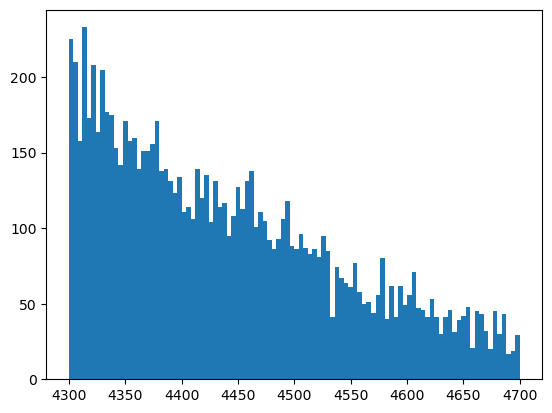

In [129]:
vel_flat = samples[:,0]
mass_flat = samples[:,1]

v_arr, v_bins, foo1 = plt.hist(vel_flat, bins = 100)
plt.show()

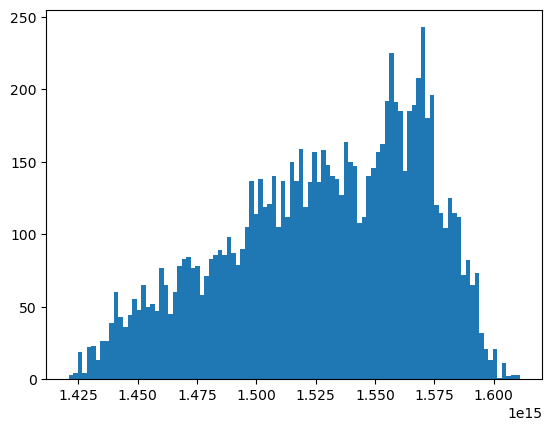

In [130]:
M_arr, M_bins, foo2 = plt.hist(mass_flat, bins = 100)
plt.show()

In [137]:
v_mode=v_bins[np.argmax(v_arr)]
M_mode=M_bins[np.argmax(M_arr)]
print(v_mode, M_mode)

4312.015694654106 1569198339081775.2


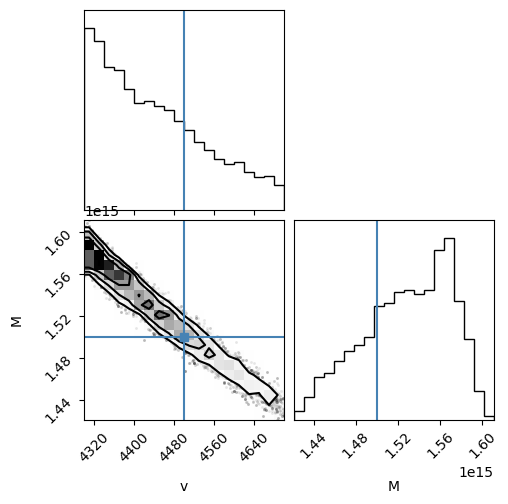

In [132]:
import corner 

labels = ["v", "M"]

fig = corner.corner(
    samples, labels = labels, truths = [4500, 1.5e15]
)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
		time taken for gettting deflection vector = 5.105733871459961e-05
check me. 
		time taken for get dot product = 5.443890889485677e-07


Text(0.5, 1.0, 'Predicted Signal')

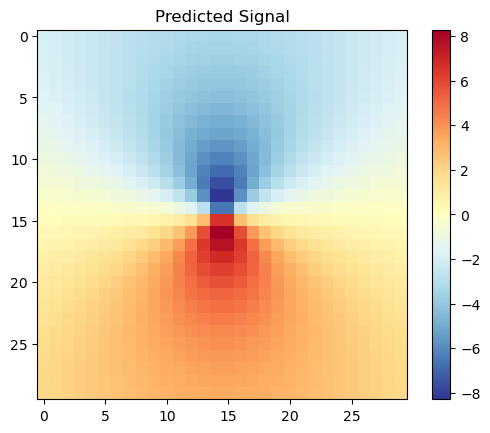

In [133]:
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [M_mode], redshift, v_phi, [v_mode], param_dict, bl = bl2d)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Predicted Signal")

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=20.000, z=0.30
		time taken for gettting deflection vector = 5.554755528767903e-05
check me. 
		time taken for get dot product = 4.0531158447265624e-07
get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 2.6035308837890626e-05
check me. 
		time taken for get dot product = 3.814697265625e-07


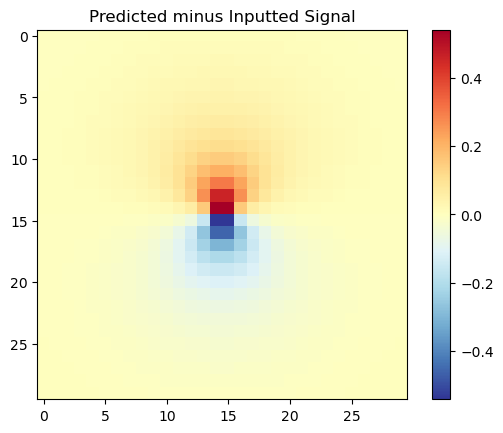

In [134]:
mvl_arr1, vel_dir_arr1, vel_mag_arr1 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [2e15], redshift, v_phi, [3450], param_dict, bl = bl2d)
mvl_arr2, vel_dir_arr2, vel_mag_arr2 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [1.5e15], redshift, v_phi, [4500], param_dict, bl = bl2d)
plt.imshow(mvl_arr1[0] - mvl_arr2[0], cmap = cmap); colorbar(); title("Predicted minus Inputted Signal"); show()

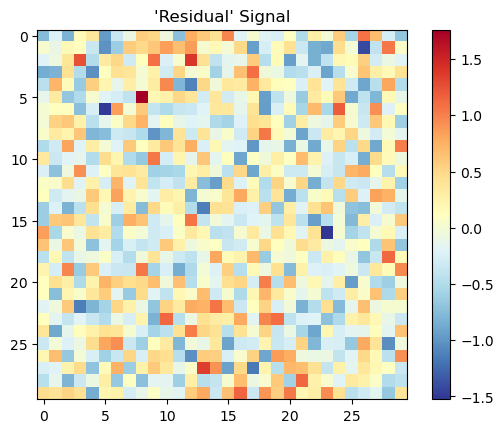

In [135]:
# Despite not being the same mass and velocity values, this mass and velocity gives a surprisingly accurate result.
# Maybe its because ML signal is prop to mass and velocity (so higher mass and lower velocity results in same signal)

plt.imshow(mock_signal - mvl_arr[0], cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

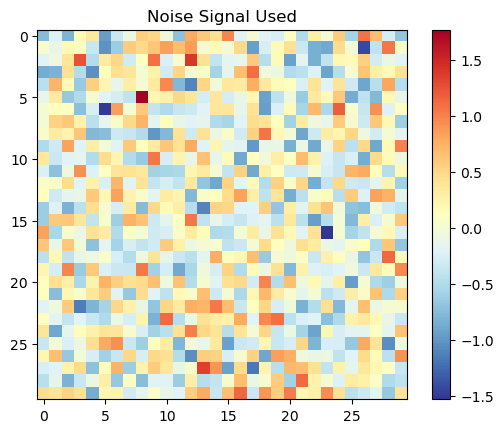

In [136]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

-------------------

# Add ML to fit if wanted #

In [11]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [12]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 0.0003946224848429362
check me. 
		time taken for get dot product = 8.043448130289714e-05
(1, 60, 60) (1,) (1,)
1
(1, 60, 60) (1,) (1,)


/home/dchanda2002/MovingLensBC/transverse_velocity/scripts/../modules/moving_lens.py:623: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec_tmp = np.asarray( [phi, theta, 0.] )


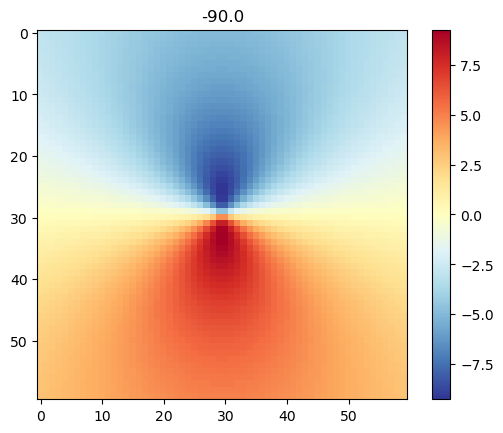

In [13]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

In [11]:
include_ml = True

----------------

# Simple CMB Modes Fitting #

Text(0.5, 0, 'Multipole $\\ell$')

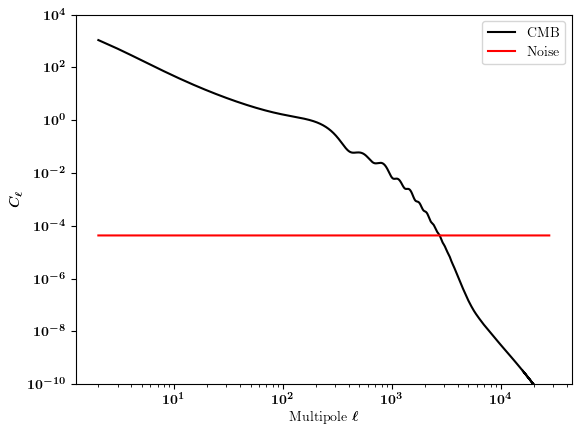

In [12]:
# Read in the Cls above
# Verify later -- what is the difference between files
# data/output_planck_r_0.0_lensedtotCls.dat  AND data/output_planck_r_0.0_2015_cosmo_lensedCls.dat
# For now I'm using the first one

from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu
rcParams['figure.dpi'] = 100
rcParams['font.family'] = 'Times new roman'

#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl_tt, 'k-', label = r'CMB')
plot(el, nl, 'r-', label = r'Noise')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

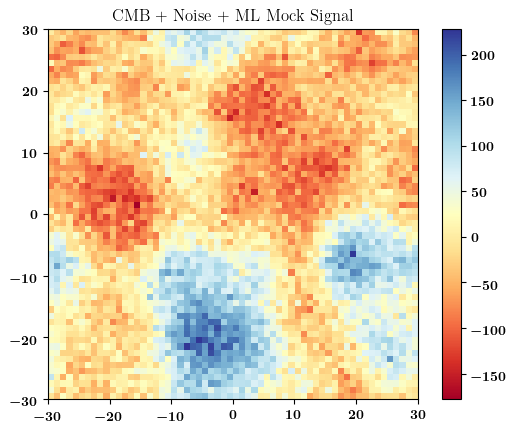

In [16]:
# Make a mock with CMB (with all k modes) and noise 

cmb_signal, g1 = flatsky.make_gaussian_realisation(mapparams, el, cl_tt, bl = bl2d)
noise_signal, g2 = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = cmb_signal + noise_signal

if include_ml:
    ml_signal = mvl_arr[0]
    mock_signal += ml_signal

rfft_idx = np.nonzero(np.fft.rfft2(g1, axes=[1, 0])) # check and maybe change this
assert rfft_idx[0].shape[0] == nx * (nx//2 + 1) # should be this size

d = mock_signal.flatten() 

mock_title = "CMB + Noise"
if include_ml:
    mock_title += " + ML"
mock_title += " Mock Signal"

plt.imshow(mock_signal, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(mock_title); show()

In [65]:
# Save the cmb and mock signals for comparison in loading files
# cmb_ml_firsttest_maps, cmb_only_1

# np.savez("output/samplers/maps/cmb_only_1.npz", cmb_map = cmb_signal, noise_map = noise_signal, 
#          mock_map = mock_signal, g1 = g1, g2 = g2)
# np.savez("output/samplers/maps/cmb_only_1.npz", cmb_map = cmb_signal, noise_map = noise_signal, 
#          mock_map = mock_signal, ml_map = ml_signal, g1 = g1, g2 = g2)

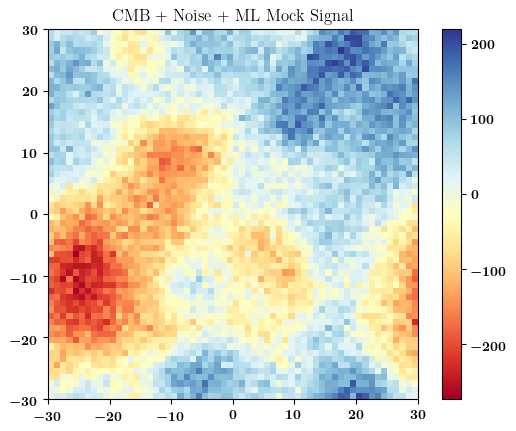

In [14]:
# Load in the cmb and mock signals for comparison in loading files
# cmb_l1500_60_dx1_1

my_maps = np.load("output/samplers/maps/cmb_ml_l3000_60_dx1_4.npz", allow_pickle = True)
cmb_signal = my_maps["cmb_map"]
noise_signal = my_maps["noise_map"]
mock_signal = my_maps["mock_map"]
g1 = my_maps["g1"]
g2 = my_maps["g2"]

if include_ml:
    ml_signal = my_maps["ml_map"]

rfft_idx = np.nonzero(np.fft.rfft2(g1, axes=[1, 0])) # check and maybe change this
assert rfft_idx[0].shape[0] == nx * (nx//2 + 1) # should be this size

d = mock_signal.flatten() 

mock_title = "CMB + Noise"
if include_ml:
    mock_title += " + ML"
mock_title += " Mock Signal"

plt.imshow(mock_signal, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(mock_title); show()

In [15]:
# Set up the prior cls, to help the realizations

nx, ny, dx, dy = mapparams
arcmins2radians = np.radians(1/60.)
dx *= arcmins2radians
dy *= arcmins2radians
norm = np.sqrt(1./ (dx * dy))

prior_cls = flatsky.cl_to_cl2d(el, cl_tt, mapparams)
prior_cls = prior_cls**0.5 * norm
prior_cls[np.isnan(prior_cls)] = 0.

In [18]:
# These include l(0,0)

# 2 x 2 deg^2

# 5 params --> lmax = 250
# 9 params --> lmax = 300
# 13 params --> lmax = 400
# 21 params --> lmax = 420
# 29 params --> lmax = 550
# 37 params --> lmax = 570

# 1 x 1 deg^2

# 9 params --> lmax = 570
# 21 params --> lmax = 1000
# 57 params --> lmax = 1500
# 97 params --> lmax = 2000
# 145 params --> lmax = 2500
# 221 params --> lmax = 3000

In [16]:
# Restrict to the number of amplitudes we want to fit for
# First experiment with the l value and the number of modes it corresponds to

lmax = 3000
lx, ly = flatsky.get_lxly(mapparams)
el_2d = np.sqrt(lx**2 + ly**2)
fft_filter = np.ones_like(lx)
fft_filter[el_2d>lmax] = 0.
fft_filter[0][0] = 0.   # to remove l(0,0) (mean)

# cov = noise_cov
cov_inv = noise_cov_inv

np.unique(fft_filter, return_counts=True)

(array([0., 1.]), array([3380,  220]))

In [17]:
mock_cmb_mat = np.fft.fft2(g1) * fft_filter
m_mock = flatsky.make_direct_realization(mapparams, el, prior_cls * mock_cmb_mat, bl = bl2d)
if include_ml:
    m_mock += ml_signal
diff_mock = (d - m_mock.flatten()).reshape(nx,nx)
diff_mock_flat = diff_mock.flatten()
mock_like = -0.5 * np.asarray( np.dot(diff_mock_flat.T, np.dot( cov_inv, diff_mock_flat ))).squeeze()
print(mock_like)

-1738.4016884187215


In [18]:
# Attempt an emcee with complex amplitudes for the gaussian deviations

import scipy

# cov = noise_cov
# cov_inv = noise_cov_inv
# data = mock_signal

# Set the stddev of the prior
# gaussian * nx due to normalization factor: https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft
# gaussian / sqrt(2) for each component (real, imag)
prior_std = nx/np.sqrt(2)
print("Std:", prior_std)

amps_idx = (fft_filter != 0.)
fitting_idx = flatsky.get_fitting_indices(amps_idx, nx, dx)

num_complex = len(fitting_idx[0])
num_params = 2 * num_complex

if include_ml:
    num_params += 1
    
print("Fitting with " + str(num_complex) + " independent complex numbers, for " + str(len(fft_filter[amps_idx])) + 
      " complex numbers in total")

def log_likelihood(amps_mat, ml_amp = None):
    
    complex_mat = prior_cls * amps_mat
    m = flatsky.r_make_direct_realization(mapparams, el, complex_mat, rfft_idx, bl = bl2d).flatten()
#     m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d).flatten()

    if include_ml:
        m += ml_amp * ml_signal.flatten()
    
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps):
    if include_ml:
        ml_amp = amps[len(amps) - 1]
        amps = amps[:len(amps) - 1]
        if (ml_amp > 5) or (ml_amp < -5):
            return -np.inf
        
    return np.sum(np.log(scipy.stats.norm.pdf(amps, loc = 0, scale = prior_std)))

def log_probability(amps):
    prior = log_prior(amps)
    if not np.isfinite(prior):
        return -np.inf
    
    ml_amp = None
    if include_ml:
        reals, imag = amps[:num_complex], amps[num_complex:len(amps) - 1]
        ml_amp = amps[len(amps) - 1]
    else: 
        reals, imag = amps[:num_complex], amps[num_complex:]
    complex_amps = reals + imag * 1.0j
    amps_mat = flatsky.fill_amplitudes_matrix(complex_amps, fitting_idx, fft_filter)

    res = prior + log_likelihood(amps_mat, ml_amp)
    print("T:", res - mock_like)
    return res

Std: 42.426406871192846
Fitting with 110 independent complex numbers, for 220 complex numbers in total


In [19]:
# I think maybe try larger number of walkers to explore better?

nwalkers = 3 * num_params

initial_real = np.random.standard_normal((nwalkers, num_complex)) * prior_std
initial_imag = np.random.standard_normal((nwalkers, num_complex)) * prior_std
if include_ml:
    initial_ml = (np.random.rand(nwalkers, 1) - 0.5) * 5
    initial = np.hstack([initial_real, initial_imag, initial_ml])
else:
    initial = np.hstack([initial_real, initial_imag])
nwalkers, ndim = initial.shape

In [9]:
# Save your progress: Create/Reset a new file

filename = "output/samplers/h5/cmb_only_1.h5"
my_backend = emcee.backends.HDFBackend(filename)
# my_backend.reset(nwalkers, ndim)   # To clear the file if it exists

In [6]:
# Save your progress: Load in an old file and continue

filename = "output/samplers/h5/cmb_ml_l2000_60_dx1_1.h5"
my_backend = emcee.backends.HDFBackend(filename)

In [25]:
# try using emcee

# import multiprocessing
# multiprocessing.set_start_method("fork")

# also try
# import os
# os.environ["OMP_NUM_THREADS"] = "1"

from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool, backend = my_backend)
    result = sampler.run_mcmc(initial, 2000, progress = True)
#     result = sampler.run_mcmc(None, 200, progress = True)
    samples = sampler.get_chain(flat = True)

T: -39061.7718444621
T: T:-22119.21866118416T: T:
T: T:-21457.711054847816 T:T:-24398.823769353876 -36006.9103775401

 
T:-34937.84014282256  -44377.05730534429
-29122.991291507195-28893.797667583953
T:T:
T: T:T: -25309.014358542132-29817.663819599453
 
 
 -34154.012384966794T:T: -37422.967438056134T:
T:T:
 -31034.69196505576T:  T:-36218.51529224485 -31635.108265562616-39507.65062616391
T:T:  
-25979.232953441875 -38784.224066023395
T:-27553.869351223668
-32667.758881973663-39096.32662759382  
 -24790.057924250585
T:
-42173.44622689187


T:
-29640.410834184964T:T:T:T: -63379.33542138558T:
T:  T:  T: -32402.28984010769-32353.65276455516 -20570.550005137018
T: 

-17898.004747716244T:
-19091.550041498464  -33100.99372592792-24347.568937937576 

-32637.485481542455
 
T:T:-24548.760672123622-30878.041104350945 -36147.97034969339

 T:
T:
-26954.485230355524-27248.789336351016 T:
T:T:  T:T:   -24497.69677971113 
-38490.51403375322T:
-29406.135311690407T:-24756.663036154034T:-27172.36372356726

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

T:T:T: -36068.023385600776 
T:T:T:T:  T: -22343.619857836355T: 
-54104.24180250944-41280.8791938576-27853.0438227315 
 -28733.561215567846 

-52863.29647649593
T:-70699.73009128592-29425.887088444557T:T:T: T:

-37485.46477493638  
 T:-28694.702002566148 T:-22968.859582865167T:T:
T:T:
 -43258.925333803614-41549.844930585874    
-46682.74730186405T:T: 
-31044.823649198508-64288.48005044002

-26869.344455665465
 -17999.215224870433-47387.76937586904
T:
T:
T:
 -25109.270204117904T:-21039.21044338369 T: 
T: 
 -57730.04569768316
-49942.908407694405-17637.629758999534 T:

T:T:-44256.60558979794T:T:   T:T:-65199.2612503612-39827.83713437783

  T: T:T:-21276.110104808795 
-34410.820726557235-50513.20339616425-20556.860148829073
   

 -30328.53747684051-108227.67393231185T:-29141.087380291916


T:-20495.093237847617T:  
 -19235.98858960465-41479.0054740796T:
T:T:T: 
T:T:-18195.611351606625-25324.13268420768
T:-60114.344487026385 
-36052.078063763365 T:-18502.61627056312 -24693.89457059773

 
-23

  0%|                                                                                | 1/2000 [00:15<8:25:49, 15.18s/it]

T: T:-24313.757638517076 
T: T:-29539.38615238516T:-15569.468563335007T:
T:
T:T: T: -74671.17560704905 T:-17784.92452394285T: -43137.717902717726 T:-64659.342986371805 

-21372.64086185817-26227.723160253965-24471.21903659393
 T:   T:
-75796.03922182308-36643.90975469357T:T:
 

   
-19336.627469738785T:-41495.24007971434-55553.9519122445T:

-41965.33386746826-19131.05590759737
T: -18145.917002744303



T:T: T:T:T: T: T:-21712.81343223199  T:T: -19096.39099750519-19051.632327972595 -51307.91697223238 T:-20254.26019754785
 
 -17395.838303334305-31413.96633356656 


 T:-22399.78820665397
-90963.454851212-57570.74647784762

 -23697.343002419T:-34291.58504896439 T:-21098.826624780802

T:T:T: 
T: 
-31775.3646517729-32929.87366933146
T:
 
 T: -27681.63223518108 T:-20050.793874871502T:T:T:-78633.25713793155-27482.35331444345
 
 -16867.03919287365-16731.332443159514-18803.344730810768
 T:

 T:-31286.649227835485T:-45358.91180550973
 T:T: 
 T: 
 -17795.815892359708T: 
 -33785.70240655542T:
-1884

  0%|                                                                                | 2/2000 [00:30<8:34:35, 15.45s/it]

T: -19193.19564999993T: -55297.358958377656
T:T:T:T:  -54355.51522068181-20288.911622283835 
T:T:
 T: T:T:T:-64649.247320349896-29580.680250324735  

T:T:
  T:-17791.932983525734-17427.412258318862-34552.70228435116T:  T:T:-15826.131061964736 

  -24949.76884291344T:-19972.887496665808-30496.405590828832
 -52977.66844602871-16987.001906377885
-101983.36835131193
 -27478.452712368384

-32570.32611754629

T: T: T:-19126.932753113393 
-17198.08522300957


T:-20456.43952019079T:  -17800.52123411338-20522.269287387142T:
 
-32657.03366999387

T:
T: T:T: -23326.54080667819
-29772.37135303166T:  -14128.572700880146
T:T:T:-31324.571225397893  T:-53129.331136957226T:-46715.5129342889 
 

T: -33075.60284697719  -17381.949230524995T:
 -54562.49029168294-68126.06370908779
 
T:-21526.285058947025-27675.20558771442T:
T:T:-47042.1106307788
 
T: -18207.77207239128
T: -31592.586062431546-56583.11432493458T: 

-21946.376449601805 
 T:
T:
-19477.671373833356T:T:  T: -21498.19314677396 -15665.105611728222-

  0%|                                                                                | 3/2000 [00:45<8:20:59, 15.05s/it]

T:T:T:T:T:T:   -19214.41176419344T:T:-16194.076685451606T:
    -21506.14394195988
 -16641.130356763908-20636.21857769224T:-43208.48514688164
 -17652.058688450696
T:T:
-28892.023997204225-30453.591491214716 T: T:T:-14670.548458584513
   T:-30065.06002141432


-16268.73885566883-16922.484309579628-34195.32707368141 

 -16179.258667870386

-34247.51168960867T:


T:T:T:T:T:T: T: T:-77766.81701251141 
T:  
-18177.845642920896-22040.95683830073 T:-43039.83625552575   -17968.811003146253T:T: T:
-15944.654747233455
-27523.823900550633   -19907.09261472164-35779.26046532376
T:
-18363.014192444283 


-24712.629206861096T:-34483.38120207986-19626.854698514133

T:

T:  T:T:T:  -41626.48533344259 -39333.06487373963-21941.999455647732
-18567.77699187745

T:T:
 T:T:-14361.193905896986 
-54116.30277206361 -21026.85766772597-27421.19414060961T:
 -13727.446784717866
 T:
 T:
 T:  -30039.685116803023-19297.733379182864-14333.074937670644
T:-18179.271852694-27335.145387356795
T:-27242.59479370326 
 
T:-199

  0%|▏                                                                               | 4/2000 [00:59<8:05:41, 14.60s/it]

T:T:T: -18702.698919073853
T: T:-50360.08721466699  T:
T:T:T:T:-17977.336218606688
 -18505.550983997855 T:-17454.095530508246  -30169.379113018964   
-24318.77066661552-14561.473872604793-16953.243796091145-15232.616312240481

T:T:
T: 
 -20639.24674579859
T:T:
 
-22452.133897459826T: -89896.79682386051-23070.09773170464 
T:-33104.09086715647T:
T:T:  T:

T: -33579.34467733051
-14754.576019905866 -24423.972493351117-108794.14903521384  -15380.408683908061

-15449.609145439457T:
 
-28571.351938731208 

-21563.95304774755T:-31539.198876875773T:

T:T: T:T:T:-19853.242828359846T: T:    
-18212.20967104888-26241.89241765333 
-18618.945922867475-33478.88788871524  -22256.404981177788
-28220.965474598772


T:T: -16502.523023010177 -22796.95133071772

-29459.44696661142
T:T:T: T: -22090.278604436557-23996.23713795619 

T:
T: T:-26779.08882302842  T:-19638.471234640914-22024.02240651702T: 
-39431.26109701918

 T:T: -54022.30156947235T:T:-44347.9180978027
T:-19755.56097199947
 T:-42081.06120442867

-19600.503150471795-16999.57768010407
 
T:-52955.22306650899-23858.753236968383  
 

T:T:-16562.55150025093T:T: -32399.50069134958-38716.189100521224 -35033.71013424165T: -15994.74505294729

T: -38760.18387425764 T:
  
-20825.627201990235

T:-20603.92343456662T:T:-22292.189125519297 
-74824.47165820646T: 
-50874.584844166-20854.43162425844
T:
 T: -41415.631176882634
T:T:-37555.94434683776  T: 
-21076.648005004172
-11754.685036817002 -36477.48003704494 -51233.04816567615

T:
-28980.676998632665T:T:T:
-35673.95200067385T: 
 -18656.595209445604
T:T:  -11859.934711649343-18437.896813762738  -23666.550284093213-23627.495444330496

-25113.98040129459

 T:
T:
-29268.69344046046T: T:

T: T:  -19388.68616769881T:T:
 T:T:  T:  T:-26229.104961773483-56121.40835097256  -20689.07419473951T:-38835.457009453
-18170.514038470537-37407.27107790213 -42098.12247193955
 -20197.342062700503

-13974.653495507435-14844.828044869822T:
T:
-18604.916911334494 T:
-18685.555994921076
-21370.714010314583



 T:T:T

  0%|▏                                                                               | 5/2000 [01:12<7:49:15, 14.11s/it]

T:T:T:T:T:T: T:T: T: -15397.014592195848 T:
-18870.82077832231 
-29641.557488072915-25829.463733849916 T:
  
T:-19112.08869978627T:-15667.843707904425 -20331.546478058546 -19814.54227292867 -17662.63717372491


T:-18469.904124733785

 T: -17437.08146966875T:
-66569.07784402337
T:T: 
-38556.10139292256 T:-27396.151239122337T: T: 
-35349.34927087595
T:  -15883.124449350335
  -19498.785117409894-21048.66637765137T:T:-34963.53805140791

-16161.827825167524T: 
 
 -19877.568911679296
-17641.83960662463
 T:-23458.37007868921T:
-23017.285714672984T:
T: -48652.522167495954 -63052.77120399566

-14869.543282198954 T: 
T:
T:T:T:  T:T:T:-15022.186009245741T:-19180.20446432243 -59333.97704370275 T:-23175.89516842884     

-31174.566197157154-54101.25552354581-25982.723852338528
-61468.013571138-46455.230676572166


-43400.15749393277-24162.12300637592 



-18162.39835574461
T: T: -26474.466347812344
T:T:T:T:T: T:-16561.03571278675 -20048.863414474097
 
-19705.16153671249 
-25404.760483265934
T:-1711

 
-40326.00268449432-32769.862056377
-17870.861711478905
-18104.808501298692-22294.059884857907 T:T:T: T: T:-29829.187492061756 
 T:


 -19820.14691036168
-23383.37037854426 -22408.462207854755-27204.09583839639
 -22646.00793861249-17050.492728969206T:


 T: -14398.139673962656T:
 T:T: T:T: -16986.80821166503
-37026.20839050294T:-36704.87884275861
  
 -33159.585386536375
 -16701.623313547956
T:-34581.3473826321T:-26983.946486228582
T: T:-21480.3155315123

-16506.963310585023T: T: T:
T:  T: T: T:-27169.99262700268  -17474.38756401037-14646.248938705767
-22754.4708495697


-17490.438533275523 -17320.92232753208 

T: -16887.67353545464-18606.19740585646
T:T:T:-22396.533404678357
 T:
 -31528.433280142315T:T:
 -28944.599171697377T: -54874.80813189035
-13464.487717495143 T:
-14587.576024297085
 -29149.800272681096
 

T:-15803.381013850225 T:-21560.50604272441 -18510.681521088805T:
T:

  T:T:T:T:-19141.137916280386 T:  -19323.334810842854 -26633.753295818315


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   

-71245.12379989265-15798.681055397365-19237.911573679834T:T: -16129.308989579893-21560.833208175463
T:

-17708.473693940923

 

  T:-23956.340139136093T:T:T:-18693.74362117991 
T: -13553.548393505425T:-18261.005415530362

 -20029.78416105049
 T: -25884.312678057024T:-14798.830517059543  
-49495.830224935766
T:
-15410.86902687817
  -19837.5395012793T:T: 
 T:T:T:-20602.176350720994 -11220.314574791231
 -12557.58275562067

-59117.81505640592
T:  -15401.605703903844
-35928.947515214495-16921.392433007168
T:

T:T:-23974.648031375684T: T: -26181.590635294633

T:  -18173.89203845727
-23338.35545488854T:   T:T: 
 -32827.6323619907
-32951.77975574845-17247.122720412688
-16082.340260236995
-47036.38545918128T:
T:-19550.71544960121
T: -22079.188997086407T:  
T:
-23425.531926428273T:T:   T:-19922.25545500825-21239.71861059869
 -16646.996759776113T:-15175.081223567026-18350.061079935294
  

-31802.509364045683

T:T: -14631.64763269077T:-13269.183836151706


T:  -16526.05448794193
 -15445.79922

  0%|▎                                                                               | 7/2000 [01:39<7:40:15, 13.86s/it]

T: T: T:T:T:T:T: T:-14726.68366785532T:-21986.6452210949 
T:  -16297.53432704969 -17690.557752168606-15205.85584041468-17507.85457180225-16158.957372897674
 

T:T:
-27637.88655784968 

-42127.373311958065
  
T:-13949.763639657402
T:-11374.48810007207
T:T:T:T: T:T:   T:T:-26142.065520610242-15756.762159283518   -19343.328208147374 -26069.005201963468

 -15341.332412871367

-15864.206437993676  -15251.928580987033
-25732.096785410577-15397.594005348668

-17843.213384156694T:T:
T:-35030.096435391446
 
T:T:
T:T: -27163.202256371304T:
T: -27272.498407020586 -13976.81603356484
T:  -27890.3895042018
-18736.442642452814   T:T:-25996.149154652427
 -16335.203062303439T: 
-19532.445779701906 


-23619.76237609224-19474.00360306996 -31092.18690159439T:
T: -29004.28465609756T:

T: T:  
-16274.135812621635 T:-14942.84218567172-18097.414758450443T:-25497.426255938557 

 

T:T:T:T:T:-18733.535898379585T:
T:-16276.340598810371   -17659.721992535677
-31542.745333359315

-71165.9976048587-21925.352187733

In [9]:
# Plot a sample result
# check if discard can use negative values to pick last 500 for instance

all_samples = np.load("output/samplers/samples/l2500_60_dx1_1.npz", allow_pickle = True)
all_samples.files
# samples = sampler.get_chain(flat = True, discard = -10000)

['cmb_l2500_60_dx1_1', 'cmb_ml_l2500_60_dx1_1']

(4350000, 145)


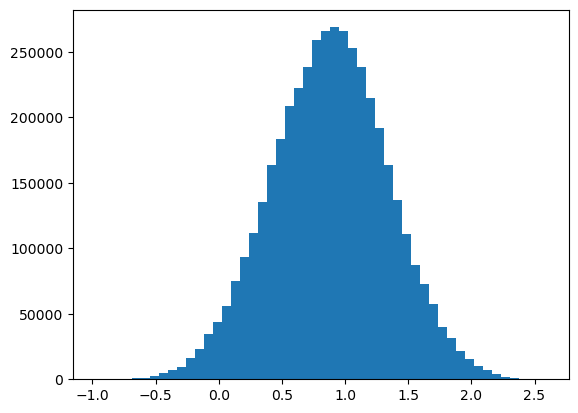

In [12]:
# samples = all_samples["cmb_ml_l2500_60_dx1_1"]
print(samples.shape)
plt.hist(samples[:,144], bins = 50)
plt.show()

In [13]:
np.std(samples[:,144])

# 1. convergence stats (how much of burn in is needed; check correlation length) 
# 2. pick reasonable lmax (2500) , pick 5 cmb realsizations, run on all, look at correlation coeff ,and constraint on ML amplitude
# include cmb lensing? and decide which lmax to choose
# play w/ getDist
# CARC Office Hours
# 
# store ml hist. (and maybe others) if convergence tests reduce file size a lot
# ML amplitude vs. other params 2d plot

0.4594264339234125

In [79]:
# Get the parameters from the samples

args = list()

for i in tqdm(range(ndim)):
    vals, bins, foo = plt.hist(samples[:,i], bins = 60)
    args.append(bins[np.argmax(vals)])
#     args.append(np.mean(samples[:,i]))

plt.close()
args = np.asarray(args)
if include_ml:
    fitted_cmb_amps = args[:num_complex] + args[num_complex:ndim - 1]*1.0j
    fitted_ml_amp = args[ndim - 1]
else:
    fitted_cmb_amps = args[:num_complex] + args[num_complex:]*1.0j

# np.save("output/parameters/l_570_params_500steps.npy", fitted_amps)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:12<00:00, 11.84it/s]


In [20]:
# Load in the parameters
# cmb_l2500_60_dx1_1_b60

args = np.load("output/parameters/cmb_ml_l3000_60_dx1_4_b60.npy", allow_pickle = True)
if include_ml:
    fitted_cmb_amps = args[:num_complex] + args[num_complex:ndim - 1]*1.0j
    fitted_ml_amp = args[ndim - 1]
else:
    fitted_cmb_amps = args[:num_complex] + args[num_complex:]*1.0j

In [21]:
# Compare results to what actually happened during the mock generation (for the respective frequencies being tested)
# ask about the symmetry in the actual case; can be applied or just present in this case?

mock_cmb_mat = np.fft.fft2(g1) * fft_filter
fitted_cmb_mat = np.zeros_like(fft_filter, dtype = complex128)
fitted_cmb_mat = flatsky.fill_amplitudes_matrix(fitted_cmb_amps, fitting_idx, fft_filter)

print("Fitted CMB Values:", fitted_cmb_amps, "\n\nActual CMB Values:", mock_cmb_mat[fitting_idx])
print("\nDifference (CMB): ", fitted_cmb_amps - mock_cmb_mat[fitting_idx])

if include_ml:
    print("\nML Value:", fitted_ml_amp)
    
d = mock_signal.flatten() ## - np.mean(MAP.flatten())
m_mock = flatsky.make_direct_realization(mapparams, el, prior_cls * mock_cmb_mat, bl = bl2d)
m_fit = flatsky.make_direct_realization(mapparams, el, prior_cls * fitted_cmb_mat, bl = bl2d)
# m_mock = flatsky.r_make_direct_realization(mapparams, el, prior_cls * mock_cmb_mat, rfft_idx, bl = bl2d)
# m_fit = flatsky.r_make_direct_realization(mapparams, el, prior_cls * fitted_cmb_mat, rfft_idx, bl = bl2d)
diff_mock = (d - m_mock.flatten()).reshape(nx,nx)
diff_fit = (d - m_fit.flatten()).reshape(nx,nx)

if include_ml:
    diff_wml_mock = diff_mock - ml_signal
    diff_wml_fit = diff_fit - fitted_ml_amp * ml_signal
    diff_wnl_mock = diff_mock - noise_signal
    diff_wnl_fit = diff_fit - noise_signal

Fitted CMB Values: [-1.50738857e+01-7.47470851e+00j -3.86380155e+00-1.15771399e+01j
 -5.23836721e+01+9.87753395e+00j -2.68368196e+01-4.93486810e+01j
 -1.23548473e+01-3.29933479e+01j -4.94829051e+01+6.09506318e+01j
 -1.95160270e+01-7.74677367e+01j -1.94940261e+01-1.03065375e+02j
 -7.55127856e+00+1.92624891e+00j  3.17517813e+00-4.54369431e+00j
  2.88429961e+01-3.94028298e+01j -3.22924332e+00-1.44961419e+01j
  1.64843956e+01+1.35128415e+01j  2.09429136e+00+1.12748306e+01j
  1.93604339e+01-2.26182143e+01j  3.83056094e+00-1.84932487e+01j
 -3.85321470e+01-3.13286520e+01j  2.30485000e+01+1.00161087e+01j
 -1.06525382e+01+3.58074319e+00j  2.74391886e+01-1.81634575e+01j
  2.74137723e+01+7.67067242e+00j  7.40786681e+00+3.40953401e+00j
 -5.22150875e+01+3.12962142e+01j  1.26955969e+02-1.00768413e+01j
  1.37795346e+01+2.51504904e+01j  2.36961776e+01+3.83233504e+01j
  3.42880456e+01+7.08112765e+01j -1.05230258e-01+4.11952414e-02j
 -9.26684242e+00+1.71959025e+01j  2.98205763e+01-1.25345169e+01j
  1.87

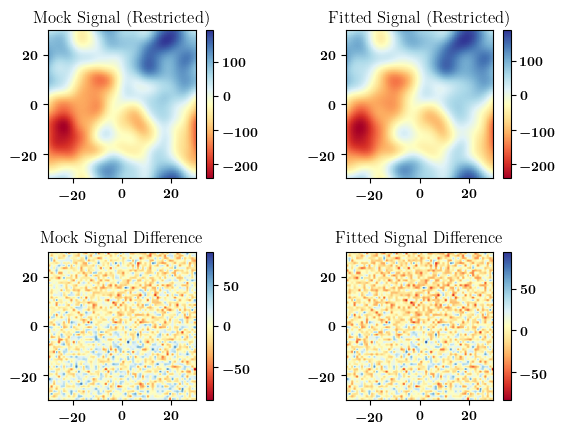

Mock Signal Difference Log Like -1812.1332763375544
Fit Signal Difference Log Like -1785.8739031098185


In [22]:
clf()
subplots_adjust(hspace = 0.5, wspace = 0.5)
splt_r = 2

subplot(splt_r,2,1); imshow(m_mock, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal (Restricted)")
subplot(splt_r,2,2); imshow(m_fit, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Fitted Signal (Restricted)")
subplot(splt_r,2,3); imshow(diff_mock, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal Difference")
subplot(splt_r,2,4); imshow(diff_fit, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Fitted Signal Difference")
plt.show()

diff_mock_flat = diff_mock.flatten()
diff_fit_flat = diff_fit.flatten()

print("Mock Signal Difference Log Like", -0.5 * np.asarray( np.dot(diff_mock_flat.T, np.dot( cov_inv, diff_mock_flat ))).squeeze())
print("Fit Signal Difference Log Like", -0.5 * np.asarray( np.dot(diff_fit_flat.T, np.dot( cov_inv, diff_fit_flat ))).squeeze())

Mock Signal Difference (removing ML) Log Like -1738.4016884187213
Fit Signal Difference (removing ML) Log Like -1678.6705591454347


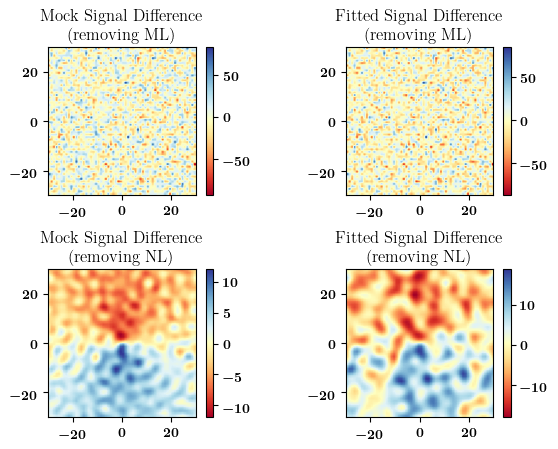

In [23]:
if include_ml:
    clf()
    
    subplots_adjust(hspace = 0.5, wspace = 0.5)
    subplot(splt_r,2,1); imshow(diff_wml_mock, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal Difference \n(removing ML)")
    subplot(splt_r,2,2); imshow(diff_wml_fit, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Fitted Signal Difference \n(removing ML)")
    subplot(splt_r,2,3); imshow(diff_wnl_mock, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal Difference \n(removing NL)")
    subplot(splt_r,2,4); imshow(diff_wnl_fit, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Fitted Signal Difference \n(removing NL)")
    
    diff_wml_mock_flat = diff_wml_mock.flatten()
    diff_wml_fit_flat = diff_wml_fit.flatten()
    
    print("Mock Signal Difference (removing ML) Log Like", -0.5 * np.asarray( np.dot(diff_wml_mock_flat.T, np.dot( cov_inv, diff_wml_mock_flat ))).squeeze())
    print("Fit Signal Difference (removing ML) Log Like", -0.5 * np.asarray( np.dot(diff_wml_fit_flat.T, np.dot( cov_inv, diff_wml_fit_flat ))).squeeze())

Text(0.5, 1.0, 'Residual between the two')

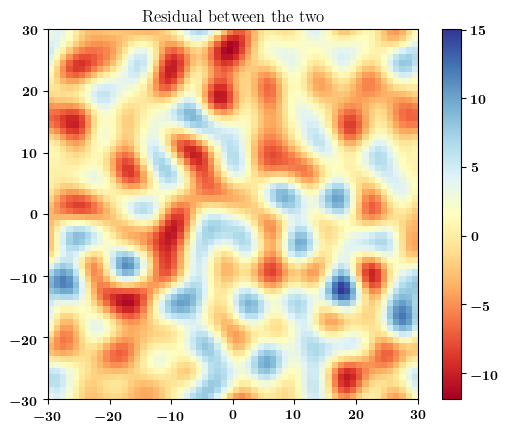

In [24]:
residual = m_mock - m_fit
# residual2 = diff_wml_fit - diff_wml_mock
# residual3 = residual - residual2

imshow(residual, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Residual between the two")

In [ ]:
# Display a corner plot

import corner 

actual_reals = list(mock_cmb_mat[fitting_idx].real)
actual_imags = list(mock_cmb_mat[fitting_idx].imag)
actuals = actual_reals + actual_imags

labels = [str(i) for i in range(len(actuals))]

fig = corner.corner(
    samples, labels = labels, truths = actuals
)

In [ ]:
# Implement code to determine convergence without using the comparison test above.



(array([ 1.,  0.,  1.,  2.,  1.,  0.,  2.,  4.,  3.,  2., 12., 38., 21.,
        11.,  6.,  1.,  1.,  2.,  1.,  1.]),
 array([-91.9084936 , -84.05801332, -76.20753304, -68.35705277,
        -60.50657249, -52.65609221, -44.80561193, -36.95513166,
        -29.10465138, -21.2541711 , -13.40369082,  -5.55321055,
          2.29726973,  10.14775001,  17.99823029,  25.84871056,
         33.69919084,  41.54967112,  49.40015139,  57.25063167,
         65.10111195]),
 <BarContainer object of 20 artists>)

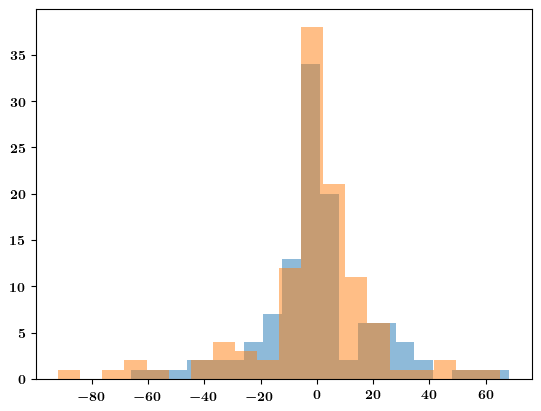

In [25]:
diff_table = fitted_cmb_amps - mock_cmb_mat[fitting_idx]
plt.hist(diff_table.real, bins = 20, alpha = 0.5)
plt.hist(diff_table.imag, bins = 20, alpha = 0.5)

---------------

In [69]:
# Figure out the distribution of the fft2 version of the gaussian distribution w sims (if not using the mathematical outcome)

fft_sims_real = list()
fft_sims_imag = list()
fft_sims_abs = list()

for i in tqdm(range(3*nx**2)):
    rands = np.random.standard_normal([nx,nx])
    fft_sims_real.append(np.fft.fft2(rands).real)
    fft_sims_imag.append(np.fft.fft2(rands).imag)
    fft_sims_abs.append(abs(np.fft.fft2(rands)))

fft_sims_real = np.asarray(fft_sims_real).flatten()
fft_sims_imag = np.asarray(fft_sims_imag).flatten()
fft_sims_abs = np.asarray(fft_sims_abs).flatten()

100%|███████████████████████████████████████████████████████████████████████████| 10800/10800 [00:03<00:00, 3463.22it/s]


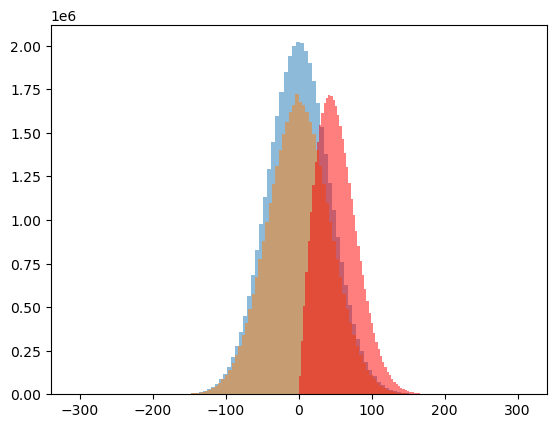

In [70]:
plt.hist(fft_sims_real, bins = 100, alpha = 0.5)
plt.hist(fft_sims_imag, bins = 100, alpha = 0.5)
plt.hist(fft_sims_abs, bins = 100, alpha = 0.5, color = "red")
plt.show()

In [26]:
# Later Mathify this

sims_std = (np.std(fft_sims_imag) + np.std(fft_sims_real)) / 2
sims_std

42.4349472277458

In [69]:
# Very rudimentary, but they appear to be gaussian about mean of 0 and stddeviation of 84.85???

print(np.mean(fft_sims_real), np.std(fft_sims_real))
print(np.mean(fft_sims_imag), np.std(fft_sims_imag))
print(np.mean(fft_sims_abs), np.std(fft_sims_abs))

0.009351426626269203 42.4598395943265
1.0234154630289508e-19 42.403467242311805
53.172990365946696 27.812320930441256


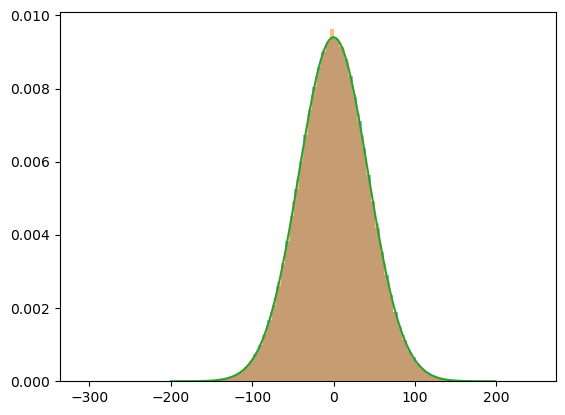

In [82]:
# Mathify test-- it works! now use it above

import scipy
my_dist = scipy.stats.norm.pdf(np.arange(-200,200), loc = 0, scale = (nx/np.sqrt(2)))
plt.hist(fft_sims_real, bins = 100, alpha = 0.5, density = "norm")
plt.hist(fft_sims_imag, bins = 100, alpha = 0.5, density = "norm")
plt.plot(np.arange(-200,200), my_dist)
plt.show()

---------------

# Foregrounds + ML #

In [138]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 3.708998362223307e-05
check me. 
		time taken for get dot product = 5.483627319335937e-07
(1, 30, 30) (1,) (1,)
1
(1, 30, 30) (1,) (1,)


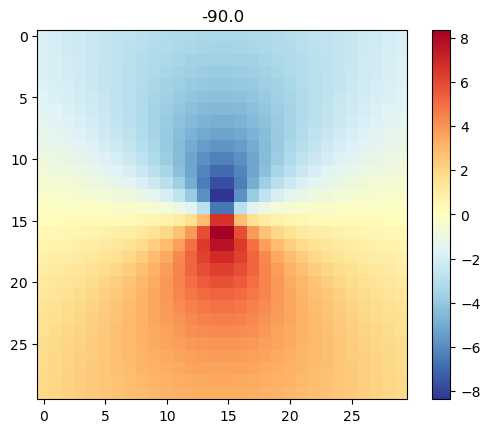

In [139]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

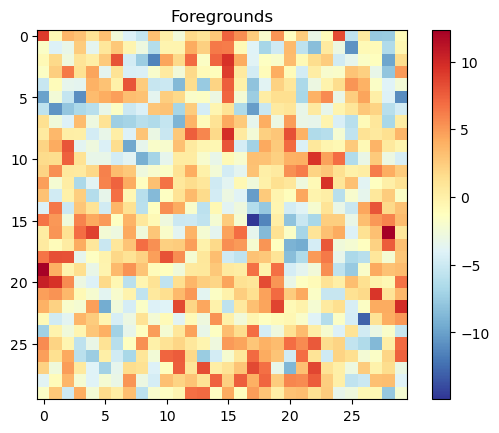

In [148]:
# Get foregrounds 
# ask if polarizations matter in this case
# ask why ls do not align, and if setting new el here is alright; or do I need to truncate all?
# why are the foregrounds randomly generated (model) too? or will it be specific to the data 

tsz_cl = fg.get_foreground_power_george_2015('tSZ')
ksz_cl = fg.get_foreground_power_george_2015('kSZ')
DG_Cl_cl = fg.get_foreground_power_george_2015('DG-Cl')
DG_Po_cl = fg.get_foreground_power_george_2015('DG-Po')
RG_cl = fg.get_foreground_power_george_2015('RG')
fg_cl = tsz_cl + ksz_cl + DG_Cl_cl + DG_Po_cl + RG_cl
el = np.arange(len(fg_cl))

fg_map, a1 = flatsky.make_gaussian_realisation(mapparams, el, fg_cl, bl = bl2d)
plt.imshow(fg_map, cmap = cmap); colorbar(); title("Foregrounds"); show()

# Scratch #

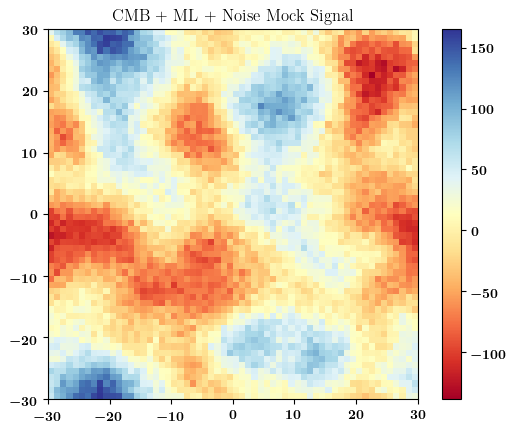

In [48]:
# Make a mock with CMB (with all k modes) + noise + ML signal


cmb_signal, g1 = flatsky.make_gaussian_realisation(mapparams, el, cl_tt, bl = bl2d)
noise_signal, g2 = flatsky.make_gaussian_realisation(mapparams, el, nl) 
mock_signal = cmb_signal + ml_signal + noise_signal

d = mock_signal.flatten() 

plt.imshow(mock_signal, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("CMB + ML + Noise Mock Signal"); show()

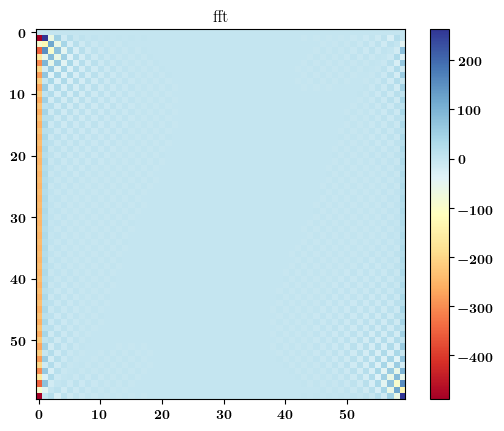

In [60]:
imshow(np.fft.fft2(mvl_arr[0]).real, cmap = cmap); colorbar(); title("fft"); show()

In [147]:
np.allclose(my_mat, np.fft.fft2(g1))

True

In [64]:
pd.Series((np.round(np.fft.irfft2(mock_cmb_mat, s = mock_cmb_mat.shape),10) == np.round(np.fft.ifft2(mock_cmb_mat).real,10)).flatten()).describe()

count     3600
unique       1
top       True
freq      3600
dtype: object

In [53]:
# Set the stddev of the prior
# gaussian * nx due to normalization factor: https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft
# gaussian / sqrt(2) for each component (real, imag)
prior_std = nx/np.sqrt(2)
print("Std:", prior_std)

# Determines the indices of the independent elements and returns them
def get_fitting_indices(amps_idx, nx, dx):
    mdx = np.radians(dx/60.)                              # shouldn't make a difference but whatever
    ix, iy = np.meshgrid( np.fft.fftfreq( nx, mdx ), np.fft.fftfreq( ny, mdx ) )
    bottom_right_idx = amps_idx & (ix <= 0.) & (iy <= 0.) # only need bottom right of matrix + (0,0), and ...
    bottom_left_idx = amps_idx & (ix >= 0.) & (iy < 0.)   # bottom left corner, and ...
    top_right_idx = amps_idx & (iy == 0.) & (ix < 0.)     # top right 0th row elements.
    fitting_idx = (bottom_right_idx | bottom_left_idx | top_right_idx).nonzero()  # x and y indices of the matrix elements to fill in
    return fitting_idx

# Creates the matrix including the amplitudes being fitted for (and fills in the complex conjugates needed)
# Assume fitting_idx, fft_filter global to save (some) memory

def fill_amplitudes_matrix(complex_amps):
    amps_mat = np.zeros_like(fft_filter, dtype = complex128)
    d1_size = len(fft_filter)
    x, y = fitting_idx
    amps_mat[x, y] = complex_amps
    for i in range(len(x)):
        if x[i] == 0 and y[i] == 0:
            continue
        elif x[i] == 0:
            amps_mat[x[i], d1_size - y[i]] = np.conj(amps_mat[x[i], y[i]])
        elif y[i] == 0:
            amps_mat[d1_size - x[i], y[i]] = np.conj(amps_mat[x[i], y[i]])
        else:
            amps_mat[d1_size - x[i], d1_size - y[i]] = np.conj(amps_mat[x[i], y[i]])
    return amps_mat

Std: 42.426406871192846


In [21]:
# Attempt an emcee with complex amplitudes for the gaussian deviations

import scipy

# cov = noise_cov
# cov_inv = noise_cov_inv
# data = mock_signal

amps_idx = (fft_filter != 0.)
fitting_idx = get_fitting_indices(amps_idx, nx, dx)

num_complex = len(fitting_idx[0])
num_params = 2 * num_complex
print("Fitting with " + str(num_complex) + " independent complex numbers, for " + str(len(fft_filter[amps_idx])) + 
      " complex numbers in total")

def log_likelihood(amps_mat):
    
    complex_mat = prior_cls * amps_mat
    
#     d = data.flatten()
    m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps):
    return np.sum(np.log(scipy.stats.norm.pdf(amps, loc = 0, scale = prior_std)))

def log_probability(amps):
    reals, imag = amps[:num_complex], amps[num_complex:]
    complex_amps = reals + imag * 1.0j
    amps_mat = fill_amplitudes_matrix(complex_amps)
    
    res = log_prior(amps) + log_likelihood(amps_mat)
    print("T:", res - mock_like)
    return res

Fitting with 28 independent complex numbers, for 56 complex numbers in total


In [113]:
chosen_mat = actual_mat # actual_mat
complex_mat = prior_cls * chosen_mat
    
d = mock_signal.flatten() ## - np.mean(MAP.flatten())
m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d)
diff = d - m.flatten()

In [24]:
# Attempt an emcee with real amplitudes for the gaussian deviations
# Then, the actual deviations can be found by fft2'ing the real amplitudes used.
# (I tried ifft2, but they are not always consistent??)

import scipy

cov = noise_cov
cov_inv = noise_cov_inv
data = mock_signal
amps_mat = np.zeros_like(prior_cls, dtype = complex128)
amps_idx = (prior_cls != 0.)
num_params = len(amps_mat[amps_idx])

def log_likelihood(amps_mat):
    
    complex_mat = prior_cls * amps_mat
    
    d = data.flatten() ## - np.mean(MAP.flatten())
    m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps_mat):
    iamps_mat = np.fft.ifft2(amps_mat)
    r = abs(iamps_mat)
    return np.log(np.mean(scipy.stats.norm.pdf(r)))    # Is this logically sound??? # iamps.real

def log_probability(theta):
    amps, phases = theta[:num_params], theta[num_params:]
    if (np.any(phases) > 2*pi) or (np.any(phases) < 0):
        return -np.inf
    complex_amps = amps * np.exp(1.j * phases)
    amps_mat[amps_idx] = complex_amps
    
    # figure out how to properly incorp prior
    prior = log_prior(amps_mat)
    res = prior + log_likelihood(amps_mat)
    print(theta, np.exp(prior), np.exp(res))
    return res


# try with complex next -- otherwise we cant use k space...

In [46]:

nx, ny, dx, dy = mapparams
arcmins2radians = np.radians(1/60.)

dx *= arcmins2radians
dy *= arcmins2radians

################################################
#map stuff
norm = np.sqrt(1./ (dx * dy))
    
cl2d_test = flatsky.cl_to_cl2d(el, cl_tt, mapparams)
cl2d_test = cl2d_test**0.5 * norm
cl2d_test[np.isnan(cl2d_test)] = 0.

test_amps = (np.copy(cl2d_test) * np.fft.fft2( np.random.standard_normal([nx,nx])))

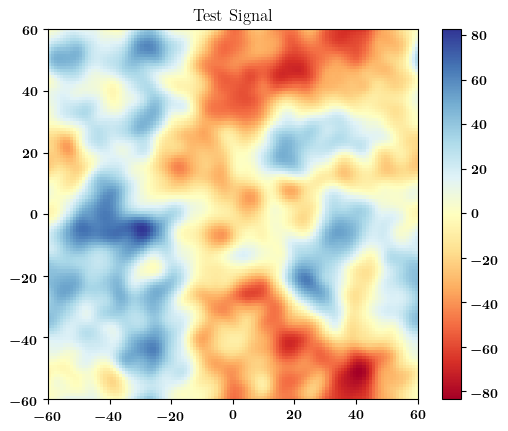

In [47]:
test = flatsky.make_direct_realization(mapparams, el, test_amps, bl = bl2d)
plt.imshow(test, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()

In [15]:
(3 * np.exp(1.j * np.pi))**2

(9-2.204364238465236e-15j)

In [49]:
np.copy(cl2d_test) * np.fft.fft2( np.random.standard_normal([nx,nx]))

array([[ 2.27378261e+06    +0.j        ,  2.32037520e+05-30068.40040273j,
        -2.31392622e+04-27907.70640425j, ...,
         1.83202435e+04+17969.03781333j, -2.31392622e+04+27907.70640425j,
         2.32037520e+05+30068.40040273j],
       [-2.32317256e+05-74794.24341058j, -6.49357707e+04-27607.7040265j ,
         5.17659406e+04 -9689.70769619j, ...,
         1.48157129e+03-12188.55857763j,  3.27873096e+03+45429.20389681j,
        -1.13794944e+05-73802.92380307j],
       [ 4.58372427e+04-10987.81984888j,  5.20729218e+04 -7575.35923853j,
         3.49187495e+04-27257.12999691j, ...,
        -8.85364186e+02+32529.04112364j,  1.90436846e+04+22714.98208163j,
         1.85556921e+04 -3506.6939092j ],
       ...,
       [ 1.49561273e+04 -7681.31382073j,  1.11393568e+04+15820.52662358j,
         1.21330619e+04-26630.08963927j, ...,
        -2.37711809e+03-10736.05568068j, -1.55338009e+04 +1224.48667853j,
        -6.64445292e+03+20516.69843718j],
       [ 4.58372427e+04+10987.81984888j,  1.

In [74]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = noise_cov_inv
data = mock_signal

sigma = 1
mu = 0

def log_likelihood(amps, phases):
    complex_amps = amps * np.exp(1.j * phases)
    d = data.flatten() ## - np.mean(MAP.flatten())
    m = flatsky.make_direct_realization(mapparams, el, complex_amps, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps, phases):
    if (np.any(phases < 0)) or (np.any(phases > 2*np.pi)):
        return -np.inf
    return np.log(1.0/np.sqrt(2*np.pi)) * (-0.5 * (amps)**2)

# def log_prior(amps, phases):
#     if (np.any(phases < 0)) or (np.any(phases > 2*np.pi)):
#         return -np.inf
    
#     complex_amps = amps * np.exp(1.j * phases)
#     prior_vals = abs(np.fft.ifft2(complex_amps / prior_cls))
# #     return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(prior_vals-mu)**2/sigma**2
#     return np.log(1.0/np.sqrt(2*np.pi)) * (-0.5 * (prior_vals)**2)     # for a standard normal distribution

def log_probability(amps, phases):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [39]:
import pandas as pd

rands = np.random.standard_normal([nx,nx])
rands_fft2 = np.fft.fft2( np.random.standard_normal([nx,nx])) 
pd.Series(rands_fft2.flatten()).describe()

count    1440000000.0+0.000000j
mean    -0.34043100-0.00000000j
std      119.7731008+0.0000000j
min      -288.384374-51.265917j
25%     -57.0425950-33.1282040j
50%      0.05716700-0.00000000j
75%      55.7596690-13.9231420j
max      292.824056+112.127469j
dtype: complex128

In [40]:
rands = np.random.standard_normal([nx,nx])
rands_fft2 = np.fft.fft2( np.random.standard_normal([nx,nx])) 
t = prior_cls * rands_fft2
rands_fft2

array([[-178.41475878  +0.j        ,   49.73734591 -88.99010662j,
         114.94655293 -61.67908946j, ...,  -13.66971395 +31.217261j  ,
         114.94655293 +61.67908946j,   49.73734591 +88.99010662j],
       [   6.88952207 -43.89073757j,  -31.01374412+158.96395322j,
         -67.06588263 -82.92653781j, ...,   27.06445892 -82.09538587j,
         -11.25466634 +92.1092741j ,   76.33394827 -42.30993111j],
       [-187.51028946-121.10167274j,   -3.12712829+112.32013387j,
         -70.94831908 -29.54745072j, ...,   80.89100743 -68.53891361j,
         -34.89840102 +31.06361794j,  -87.48053615 -93.8100982j ],
       ...,
       [-157.97687573 -15.67578896j,   11.62835471+106.1274244j ,
          79.38689735 -60.53456767j, ...,   77.98477155  -3.4873943j ,
          83.47495658 -33.70167137j,  -67.6089602  +33.41459455j],
       [-187.51028946+121.10167274j,  -87.48053615 +93.8100982j ,
         -34.89840102 -31.06361794j, ...,  -86.31849569 -89.33872565j,
         -70.94831908 +29.54745072j

In [46]:
my_rands = np.fft.ifft2(t/prior_cls).real
my_rands

array([[-0.08695027, -0.60814006, -0.24479408, ..., -0.85393719,
         1.04284916, -0.44684201],
       [ 0.52914166, -1.33201464, -0.06287991, ..., -0.76156135,
        -1.45692593,  0.55754243],
       [-0.93856343, -2.38262167,  0.41118073, ...,  0.39984158,
        -1.41230759,  0.00406307],
       ...,
       [ 0.93742048,  2.07437341, -0.90479727, ..., -0.26932127,
         0.63758154,  0.11642294],
       [-1.94680659, -0.07921611,  0.28446799, ...,  0.06435067,
         2.37253505, -0.39119988],
       [ 0.14120557,  0.43284945,  0.5143608 , ...,  0.71518304,
        -1.06219343,  0.70533574]])

/home/dchanda2002/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/dchanda2002/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([  76.,  349., 1412., 3075., 4064., 3228., 1552.,  522.,  112.,
          10.]),
 array([-276.30215758, -215.97319932, -155.64424106,  -95.3152828 ,
         -34.98632454,   25.34263372,   85.67159198,  146.00055025,
         206.32950851,  266.65846677,  326.98742503]),
 <BarContainer object of 10 artists>)

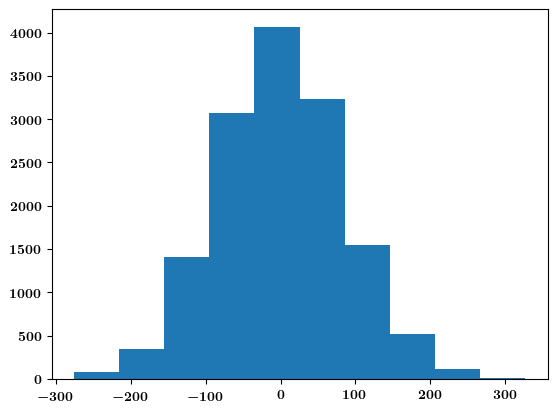

In [51]:
plt.hist(rands_fft2.flatten())

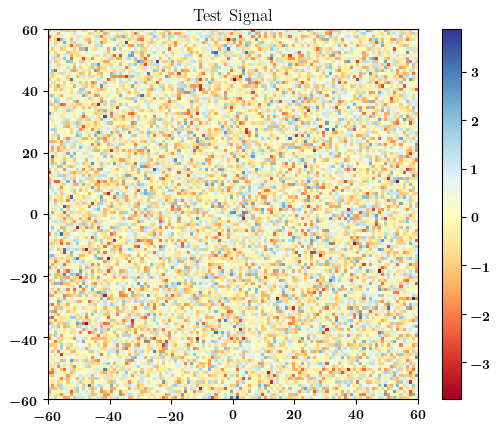

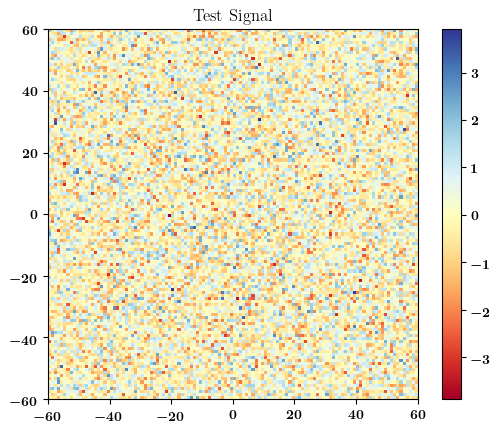

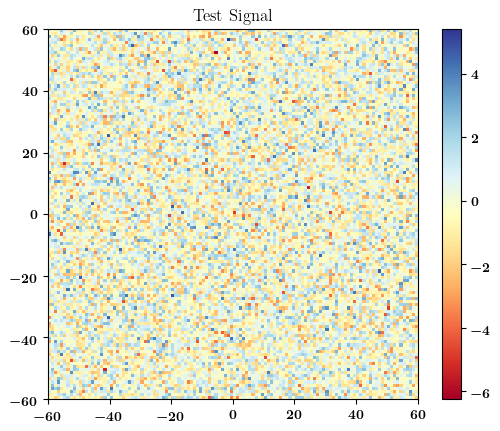

In [34]:
plt.imshow(my_rands, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()
plt.imshow(rands, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()

In [77]:
np.min(test_results)

1.000000478450108

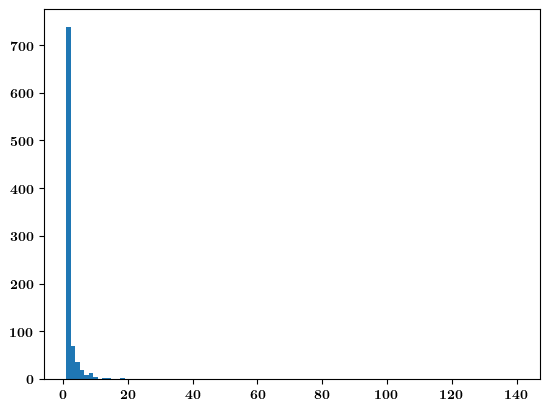

In [80]:
plt.hist(test_results.flatten(), bins = 100)
plt.show()

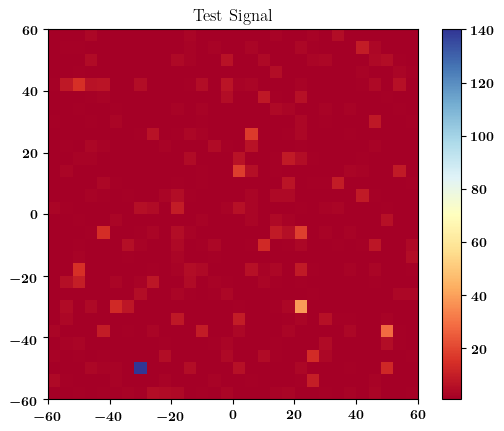

In [78]:
plt.imshow(test_results.real, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()